In [13]:
from ml_collections import ConfigDict
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
import numpy as np
import joblib
import wandb
import torch
import json
import sys
import os

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

# from Base.lla import dgala
from Base.utilities import *
from Base.mcmc import MCMCDAtoy

from torch.profiler import profile, record_function, ProfilerActivity
from elliptic_files.elliptic_mcmc import EllipticMCMCDA
from elliptic_files.utilities import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Tiaming Experiment

$$-\frac{d}{dx}(e^{k(x,\theta)}\frac{du(x)}{dx}) = 4x, \quad x\in (0,1),\theta \in [-1,1]$$
$$u(0) = 0, u(1)=2$$

where $k(x,\theta)$ has the following form:
 
$$  
k(x,\theta) =exp \left( \sum_{n=1}^{2} \sqrt a_{n} \theta_{n} b_{n}(x)  \right)
$$

where $a_{n} = \frac{8}{w_{n}^{2} + 16}$ and $b_{n} = A_{n}\left(  \text{sin}(w_{n}x) + \frac{w_{n}}{4} \text{cos}(w_{n}x) \right)$, $w_{n}$ is the $n_{th}$ solution of the equation $\text{tan} (w_{n}) = \frac{8w_{n}}{w_{n}^{2}-16}$ and $A_{n}$ is a constant of normalization which makes $\|b_{n}\| = 1$.

In [14]:
def path_results(model_type,marginal_approximation=False,num_layers=2,hidden_dim=20,nn_samples=10,batch_size=10,KL_expansion=2,
                 kernel_spatial="Matern52",kernel_parameter ="SquaredExponential" ,observed_spatial_points=6,observed_solutions=10):
    aprox_type = "marginal" if marginal_approximation else "mean"
    if model_type == "dgala":
        model_id = (
            f"_{aprox_type}"
            f"_hl{num_layers}"
            f"_hd{hidden_dim}"
            f"_s{nn_samples}"
            f"_b{batch_size}"
            f"_kl{KL_expansion}")

    elif model_type == "pigp":
        model_id = (
            f"_{aprox_type}"
            f"_kernel_spatial{kernel_spatial}"
            f"_kernel_parameter{kernel_parameter}"
            f"_spatial{observed_spatial_points}"
            f"_nsol{observed_solutions}"
            f"_kl{KL_expansion}")
        
    elif model_type == "gp":
        model_id = (
            f"_{aprox_type}"
            f"_kernel{kernel_parameter}"
            f"_spatial{observed_spatial_points}"
            f"_nsol{observed_solutions}"
            f"_kl{KL_expansion}")
            
    return os.path.join("./results",f"{model_type}{model_id}.json")


In [15]:
def final_results(model_type,KLs,Nts,batch_size=None,hidden_dim=None,marginal_approximation=False,num_layers=2,
                  kernel_spatial="Matern52",kernel_parameter ="SquaredExponential",observed_spatial_points=6):
    
    metrics = ["alpha", "m_error", "total_cpu_time","total_cuda_time","total_flops"]
    # Initialize dictionaries for mean and std
    results_experiment = {m: {} for m in metrics}
    #results_experiment_std = {m: {} for m in metrics}

    # Initialize lists for each metric
    for metric in metrics:
        for kl in KLs:
            results_experiment[metric][f"{kl}"] = []
            #results_experiment_std[metric][f"{kl}"] = []
    
    if model_type == "dgala":
        for kl, nts,b,hd in zip(KLs, Nts,batch_size,hidden_dim):
            path = path_results(model_type=model_type,KL_expansion=kl,nn_samples = nts,batch_size=b, hidden_dim=hd,
                                marginal_approximation= marginal_approximation,num_layers=num_layers)
            try:
                with open(path, "r") as file:
                    data = json.load(file)  # this will give you a dictionary
            except FileNotFoundError:
                print(f"Warning: File not found at {path}")
                continue

            for metric in data.keys():
                statistic = np.array(data[metric]).mean(), np.array(data[metric]).std()
                results_experiment[metric][f"{kl}"].append(statistic)
                #results_experiment_std[std_res][f"{kl}"].append(statistic[1])
    elif model_type == "dgala2":
        for kl, nts in product(KLs, Nts):
            batch_size_ = 10 if nts < 100 else batch_size
            path = path_results(model_type="dgala",KL_expansion=kl,nn_samples = nts,batch_size=batch_size_, hidden_dim=hidden_dim,
                                marginal_approximation= marginal_approximation,num_layers=num_layers)
            try:
                with open(path, "r") as file:
                    data = json.load(file)  # this will give you a dictionary
            except FileNotFoundError:
                print(f"Warning: File not found at {path}")
                continue

            for metric in data.keys():
                if metric =="total_cpu_time":
                    datos = data[metric][1:]
                else:
                    datos = data[metric]
                
                statistic = np.array(datos).mean(), np.array(datos).std()
                results_experiment[metric][f"{kl}"].append(statistic)


    else:
        for kl, nts in product(KLs, Nts):
            path = path_results(model_type=model_type,KL_expansion=kl,observed_solutions=nts,marginal_approximation= marginal_approximation,
                                kernel_spatial=kernel_spatial,kernel_parameter =kernel_parameter,
                                observed_spatial_points=observed_spatial_points)

            try:
                with open(path, "r") as file:
                    data = json.load(file)  # this will give you a dictionary
            except FileNotFoundError:
                print(f"Warning: File not found at {path}")
                continue # this will give you a dictionary

            for metric  in data.keys():
                if metric =="total_cpu_time":
                    datos = data[metric][1:]
                else:
                    datos = data[metric]
                
                statistic = np.array(datos).mean(), np.array(datos).std()
                results_experiment[metric][f"{kl}"].append(statistic)
                #results_experiment_std[std_res][f"{kl}"].append(statistic[1])

    return results_experiment

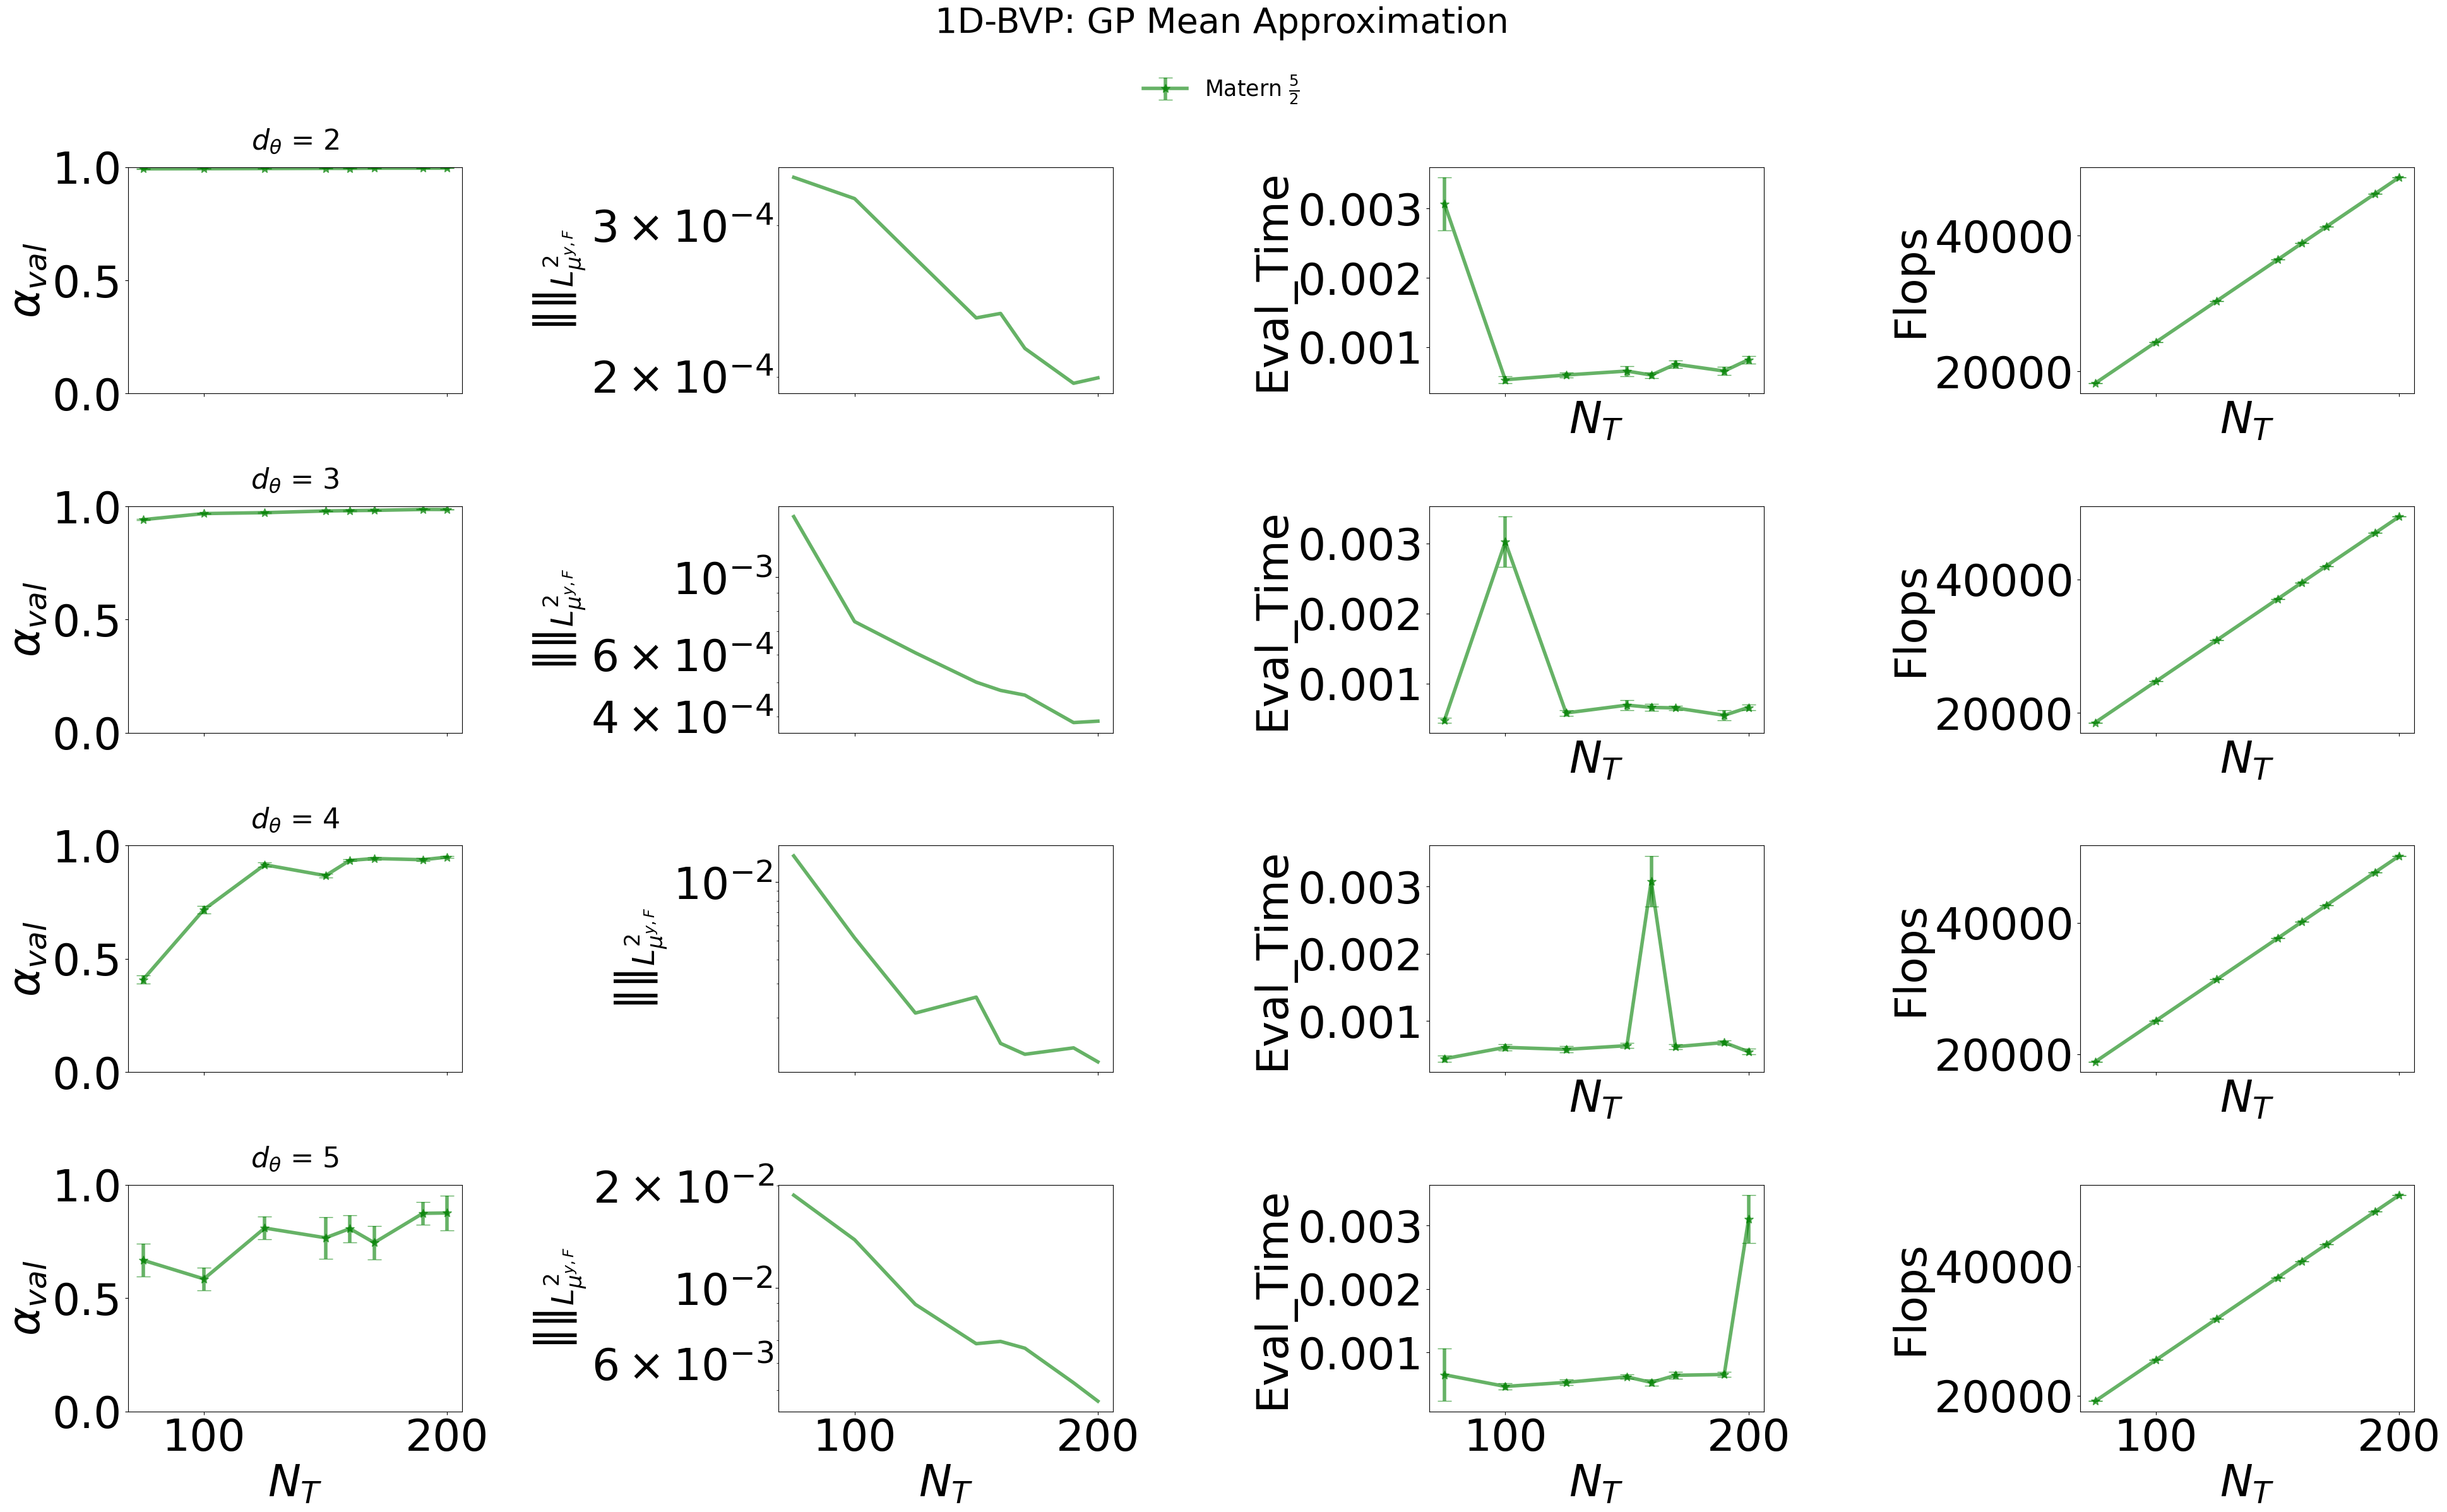

In [16]:
model_type = ["pigp"]
#Nts = [5,6,7,8,9,10,11,12,14,15,20,25,30,31,32,33,34,35,40,45,50,60,65,75,100,125,150,160,170,190,200]
Nts = [75,100,125,150,160,170,190,200]
KLs = [2, 3, 4, 5]


results_gp = final_results("pigp",KLs,Nts,kernel_spatial="Matern52",kernel_parameter ="Matern52")

fig, axs = plt.subplots(len(KLs),4, figsize=(40, 25), sharex=True)
fig.suptitle("1D-BVP: GP Mean Approximation", fontsize = 40)
plt.rcParams.update({'font.size': 50})

for i,k in enumerate(KLs):
    axs[i, 0].set_title(f"$d_{{\\theta}}$ = {k}", fontsize=32, pad=20)

    # Example usage:
    mean, std = np.array(results_gp["alpha"][str(k)]).T
    #axs[i,0].errorbar(Nts, res_mean_se[model]["alpha_res"][str(k)], yerr=res_std_se[model]["alpha_res"][str(k)], fmt="o-", capsize=8, label=f"SE",color="blue",linewidth=4,markersize=10, alpha=0.6)
    axs[i,0].errorbar(Nts, mean, yerr=std, fmt="*-", capsize=8, label=f"Matern $\\frac{{5}}{{2}}$", color="green",linewidth=4,markersize=10,alpha=0.6)

    axs[i,0].set_ylim((0,1))
    axs[i,0].set_ylabel("$\\alpha_{{val}}$")

    mean, std = np.array(results_gp["m_error"][str(k)]).T
    #axs[i,1].semilogy(Nts, res_mean_se[model]["error"][str(k)],label=f"SE",color="blue",linewidth=4,markersize=10, alpha=0.6)
    axs[i,1].semilogy(Nts, mean,label=f"Matern $\\frac{{5}}{{2}}$", color="green",linewidth=4,markersize=10, alpha=0.6)
    axs[i,1].set_ylabel("$\\| \\|_{L_{\\mu^{y,F}}^{2}}$")
        
    mean, std = np.array(results_gp["total_cpu_time"][str(k)]).T
    #axs[i,2].errorbar(Nts, res_mean_se[model]["total_cpu_time"][str(k)],yerr=res_std_se[model]["total_cpu_time"][str(k)], fmt="o-", capsize=8, label=f"SE",color="blue",linewidth=4,markersize=10, alpha=0.6)
    axs[i,2].errorbar(Nts, mean,std, fmt="*-", capsize=8, label=f"Matern $\\frac{{5}}{{2}}$", color="green",linewidth=4,markersize=10,alpha=0.6)
    axs[i,2].set_xlabel("$N_{{T}}$")
    axs[i,2].set_ylabel("Eval_Time")

    mean, std = np.array(results_gp["total_flops"][str(k)]).T
    #axs[i,3].errorbar(Nts, res_mean_se[model]["total_flops"][str(k)],yerr=res_std_se[model]["total_flops"][str(k)], fmt="o-", capsize=8, label=f"SE",color="blue",linewidth=4,markersize=10, alpha=0.6)
    axs[i,3].errorbar(Nts, mean,yerr=std, fmt="*-", capsize=8, label=f"Matern $\\frac{{5}}{{2}}$", color="green",linewidth=4,markersize=10,alpha=0.6)
    axs[i,3].set_xlabel("$N_{{T}}$")
    axs[i,3].set_ylabel("Flops")

axs[-1,0].set_xlabel("$N_{{T}}$"), axs[-1,1].set_xlabel("$N_{{T}}$"),axs[-1,2].set_xlabel("$N_{{T}}$")

plt.tight_layout(rect=[0, 0, 1, 0.985])  # leave space for both title and legend

# --- ADD HORIZONTAL LEGEND ON TOP ---
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels,loc="upper center", ncol=2, fontsize=25, frameon=False, bbox_to_anchor=(0.5, 0.95))
#plt.savefig(f"./results/images/bvp1d_gp_mean_convergence.jpg", bbox_inches='tight') 

In [17]:
k = str(5)  # whatever k is, ensure it's a string

data = {"alpha": results_gp["alpha"][k],"m_error": results_gp["m_error"][k],"time": results_gp["total_cpu_time"][k],"time_gpu": results_gp["total_cuda_time"][k]}
df = pd.DataFrame(data)
df = df.set_index(pd.Index(Nts))
print(df)

                                          alpha  \
75     (0.667590007185936, 0.07206017453941091)   
100   (0.5849800080060958, 0.05009209079683941)   
125   (0.8095800042152405, 0.04971228133169794)   
150   (0.7665700018405914, 0.09164485405070481)   
160   (0.8069199979305267, 0.05959535382257289)   
170    (0.7449100077152252, 0.0738409973129648)   
190  (0.8745000123977661, 0.049402607322355144)   
200   (0.8761099994182586, 0.07597733973026188)   

                                             m_error  \
75    (0.018753966388103036, 1.7180902155064698e-05)   
100     (0.013863809926786014, 1.83138650441926e-05)   
125    (0.008935690530088572, 2.204321710321947e-05)   
150  (0.0068434391945942806, 1.4860177410733599e-05)   
160    (0.00694986930448476, 1.2783505744867502e-05)   
170    (0.006637372627141693, 1.248212736282562e-05)   
190     (0.005249280938140854, 8.91998017903664e-06)   
200     (0.004633098734443981, 1.31861606328605e-05)   

                                   

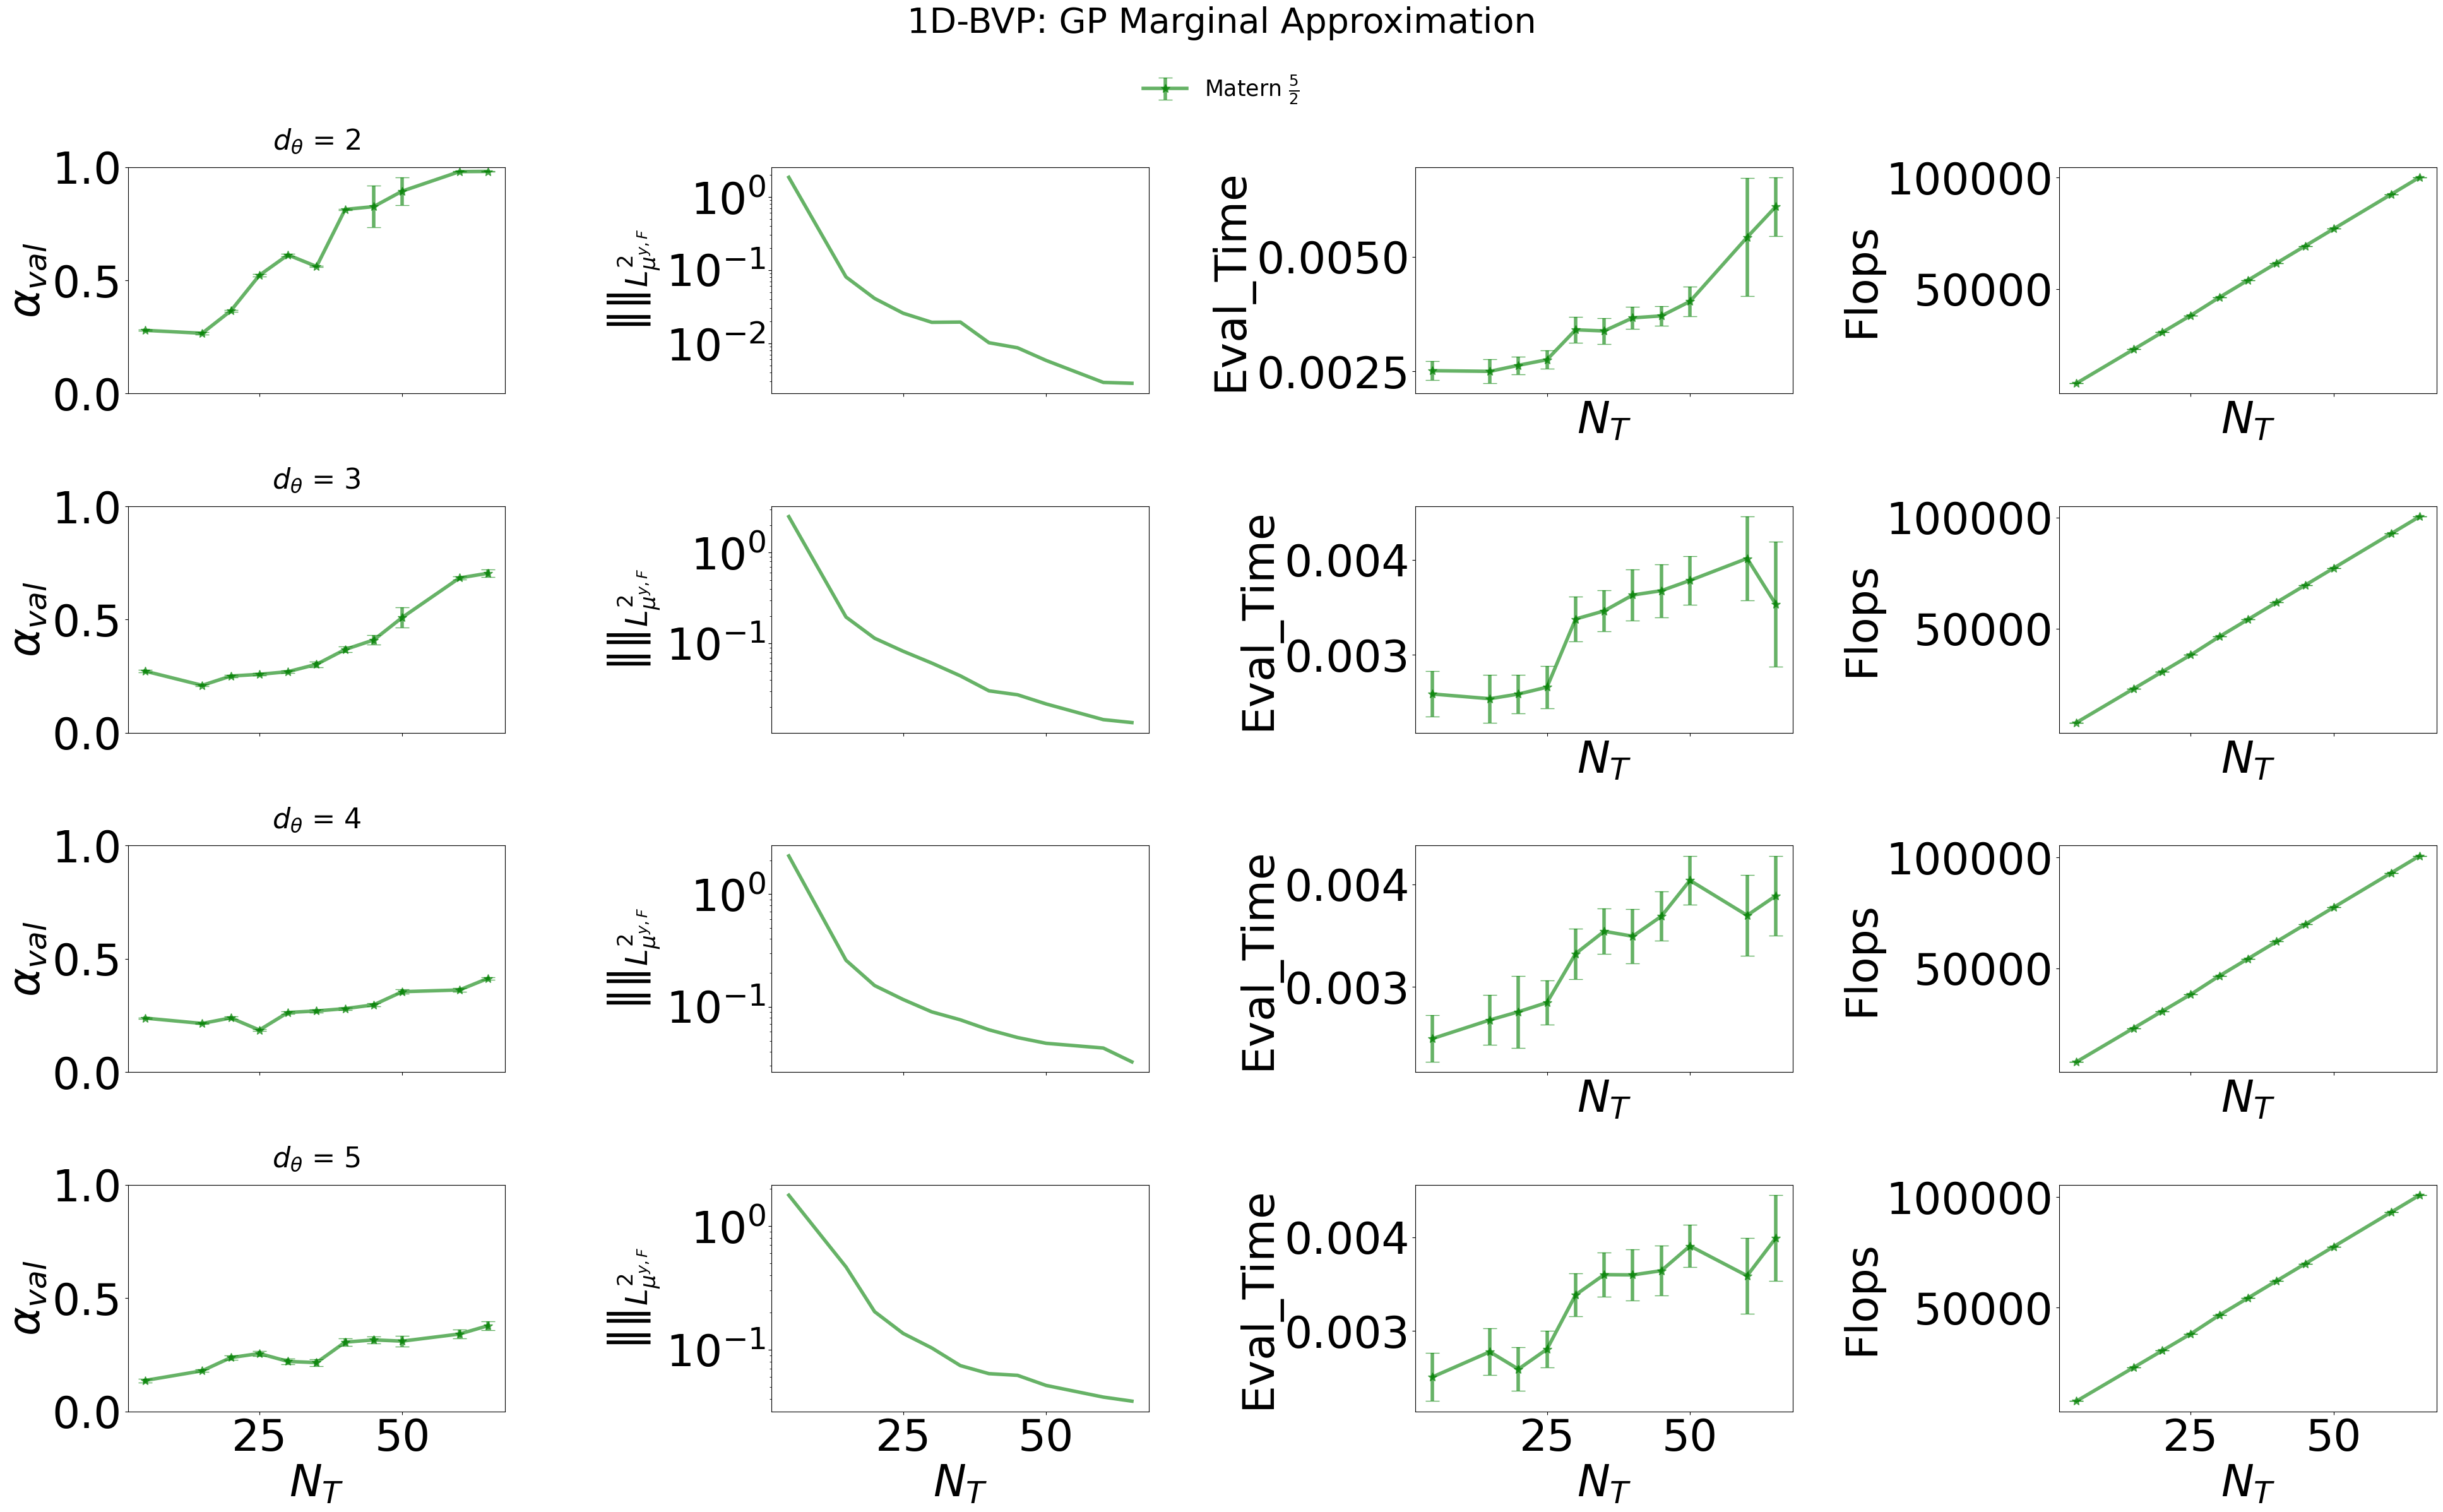

In [18]:
model_type = ["pigp"]
Nts = [5,15,20,25,30,35,40,45,50,60,65]
KLs = [2, 3, 4, 5]

results_gp_marg = final_results("pigp",KLs,Nts,kernel_spatial="Matern52",kernel_parameter ="Matern52",marginal_approximation=True)

fig, axs = plt.subplots(len(KLs),4, figsize=(40, 25), sharex=True)
fig.suptitle("1D-BVP: GP Marginal Approximation", fontsize = 40)
plt.rcParams.update({'font.size': 50})

for i,k in enumerate(KLs):
    axs[i, 0].set_title(f"$d_{{\\theta}}$ = {k}", fontsize=32, pad=20)

    # Example usage:
    mean, std = np.array(results_gp_marg["alpha"][str(k)]).T
    #axs[i,0].errorbar(Nts, res_mean_se[model]["alpha_res"][str(k)], yerr=res_std_se[model]["alpha_res"][str(k)], fmt="o-", capsize=8, label=f"SE",color="blue",linewidth=4,markersize=10, alpha=0.6)
    axs[i,0].errorbar(Nts, mean, yerr=std, fmt="*-", capsize=8, label=f"Matern $\\frac{{5}}{{2}}$", color="green",linewidth=4,markersize=10,alpha=0.6)

    axs[i,0].set_ylim((0,1))
    axs[i,0].set_ylabel("$\\alpha_{{val}}$")

    mean, std = np.array(results_gp_marg["m_error"][str(k)]).T
    #axs[i,1].semilogy(Nts, res_mean_se[model]["error"][str(k)],label=f"SE",color="blue",linewidth=4,markersize=10, alpha=0.6)
    axs[i,1].semilogy(Nts, mean,label=f"Matern $\\frac{{5}}{{2}}$", color="green",linewidth=4,markersize=10, alpha=0.6)
    axs[i,1].set_ylabel("$\\| \\|_{L_{\\mu^{y,F}}^{2}}$")
        
    mean, std = np.array(results_gp_marg["total_cpu_time"][str(k)]).T
    #axs[i,2].errorbar(Nts, res_mean_se[model]["total_cpu_time"][str(k)],yerr=res_std_se[model]["total_cpu_time"][str(k)], fmt="o-", capsize=8, label=f"SE",color="blue",linewidth=4,markersize=10, alpha=0.6)
    axs[i,2].errorbar(Nts, mean,std, fmt="*-", capsize=8, label=f"Matern $\\frac{{5}}{{2}}$", color="green",linewidth=4,markersize=10,alpha=0.6)
    axs[i,2].set_xlabel("$N_{{T}}$")
    axs[i,2].set_ylabel("Eval_Time")

    mean, std = np.array(results_gp_marg["total_flops"][str(k)]).T
    #axs[i,3].errorbar(Nts, res_mean_se[model]["total_flops"][str(k)],yerr=res_std_se[model]["total_flops"][str(k)], fmt="o-", capsize=8, label=f"SE",color="blue",linewidth=4,markersize=10, alpha=0.6)
    axs[i,3].errorbar(Nts, mean,yerr=std, fmt="*-", capsize=8, label=f"Matern $\\frac{{5}}{{2}}$", color="green",linewidth=4,markersize=10,alpha=0.6)
    axs[i,3].set_xlabel("$N_{{T}}$")
    axs[i,3].set_ylabel("Flops")

axs[-1,0].set_xlabel("$N_{{T}}$"), axs[-1,1].set_xlabel("$N_{{T}}$"),axs[-1,2].set_xlabel("$N_{{T}}$")

plt.tight_layout(rect=[0, 0, 1, 0.985])  # leave space for both title and legend

# --- ADD HORIZONTAL LEGEND ON TOP ---
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels,loc="upper center", ncol=2, fontsize=25, frameon=False, bbox_to_anchor=(0.5, 0.95))
#plt.savefig(f"./results/images/bvp1d_gp_marginal_convergence.jpg", bbox_inches='tight') 

In [19]:
k = str(5)  # whatever k is, ensure it's a string

data = {"alpha": results_gp_marg["alpha"][k],"m_error": results_gp_marg["m_error"][k],"time": results_gp_marg["total_cpu_time"][k]}
df = pd.DataFrame(data)
df = df.set_index(pd.Index(Nts))
print(df)

                                          alpha  \
5   (0.13667000010609626, 0.008225453909421332)   
15   (0.17947999984025956, 0.00577283271993119)   
20     (0.23766999989748, 0.010028167595523805)   
25  (0.25571000427007673, 0.011641261046571816)   
30   (0.2208099976181984, 0.012235070296927178)   
35  (0.21564000099897385, 0.014648427385856465)   
40  (0.30591999888420107, 0.016637723204192278)   
45    (0.3158200025558472, 0.01531925325755233)   
50  (0.31038999557495117, 0.023397411735224093)   
60   (0.3417699962854385, 0.019354744703657455)   
65   (0.3785899966955185, 0.019117239381712423)   

                                           m_error  \
5       (1.76737384383667, 0.00023611974412117456)   
15    (0.46592495658900906, 5.134671856941953e-05)   
20   (0.20283293089564158, 1.9512993510637423e-05)   
25    (0.13532700997670233, 1.050168793385573e-05)   
30   (0.10332797007726661, 2.0735084737500674e-06)   
35   (0.07440068422429705, 1.7440800585415008e-05)   
40   (0.0

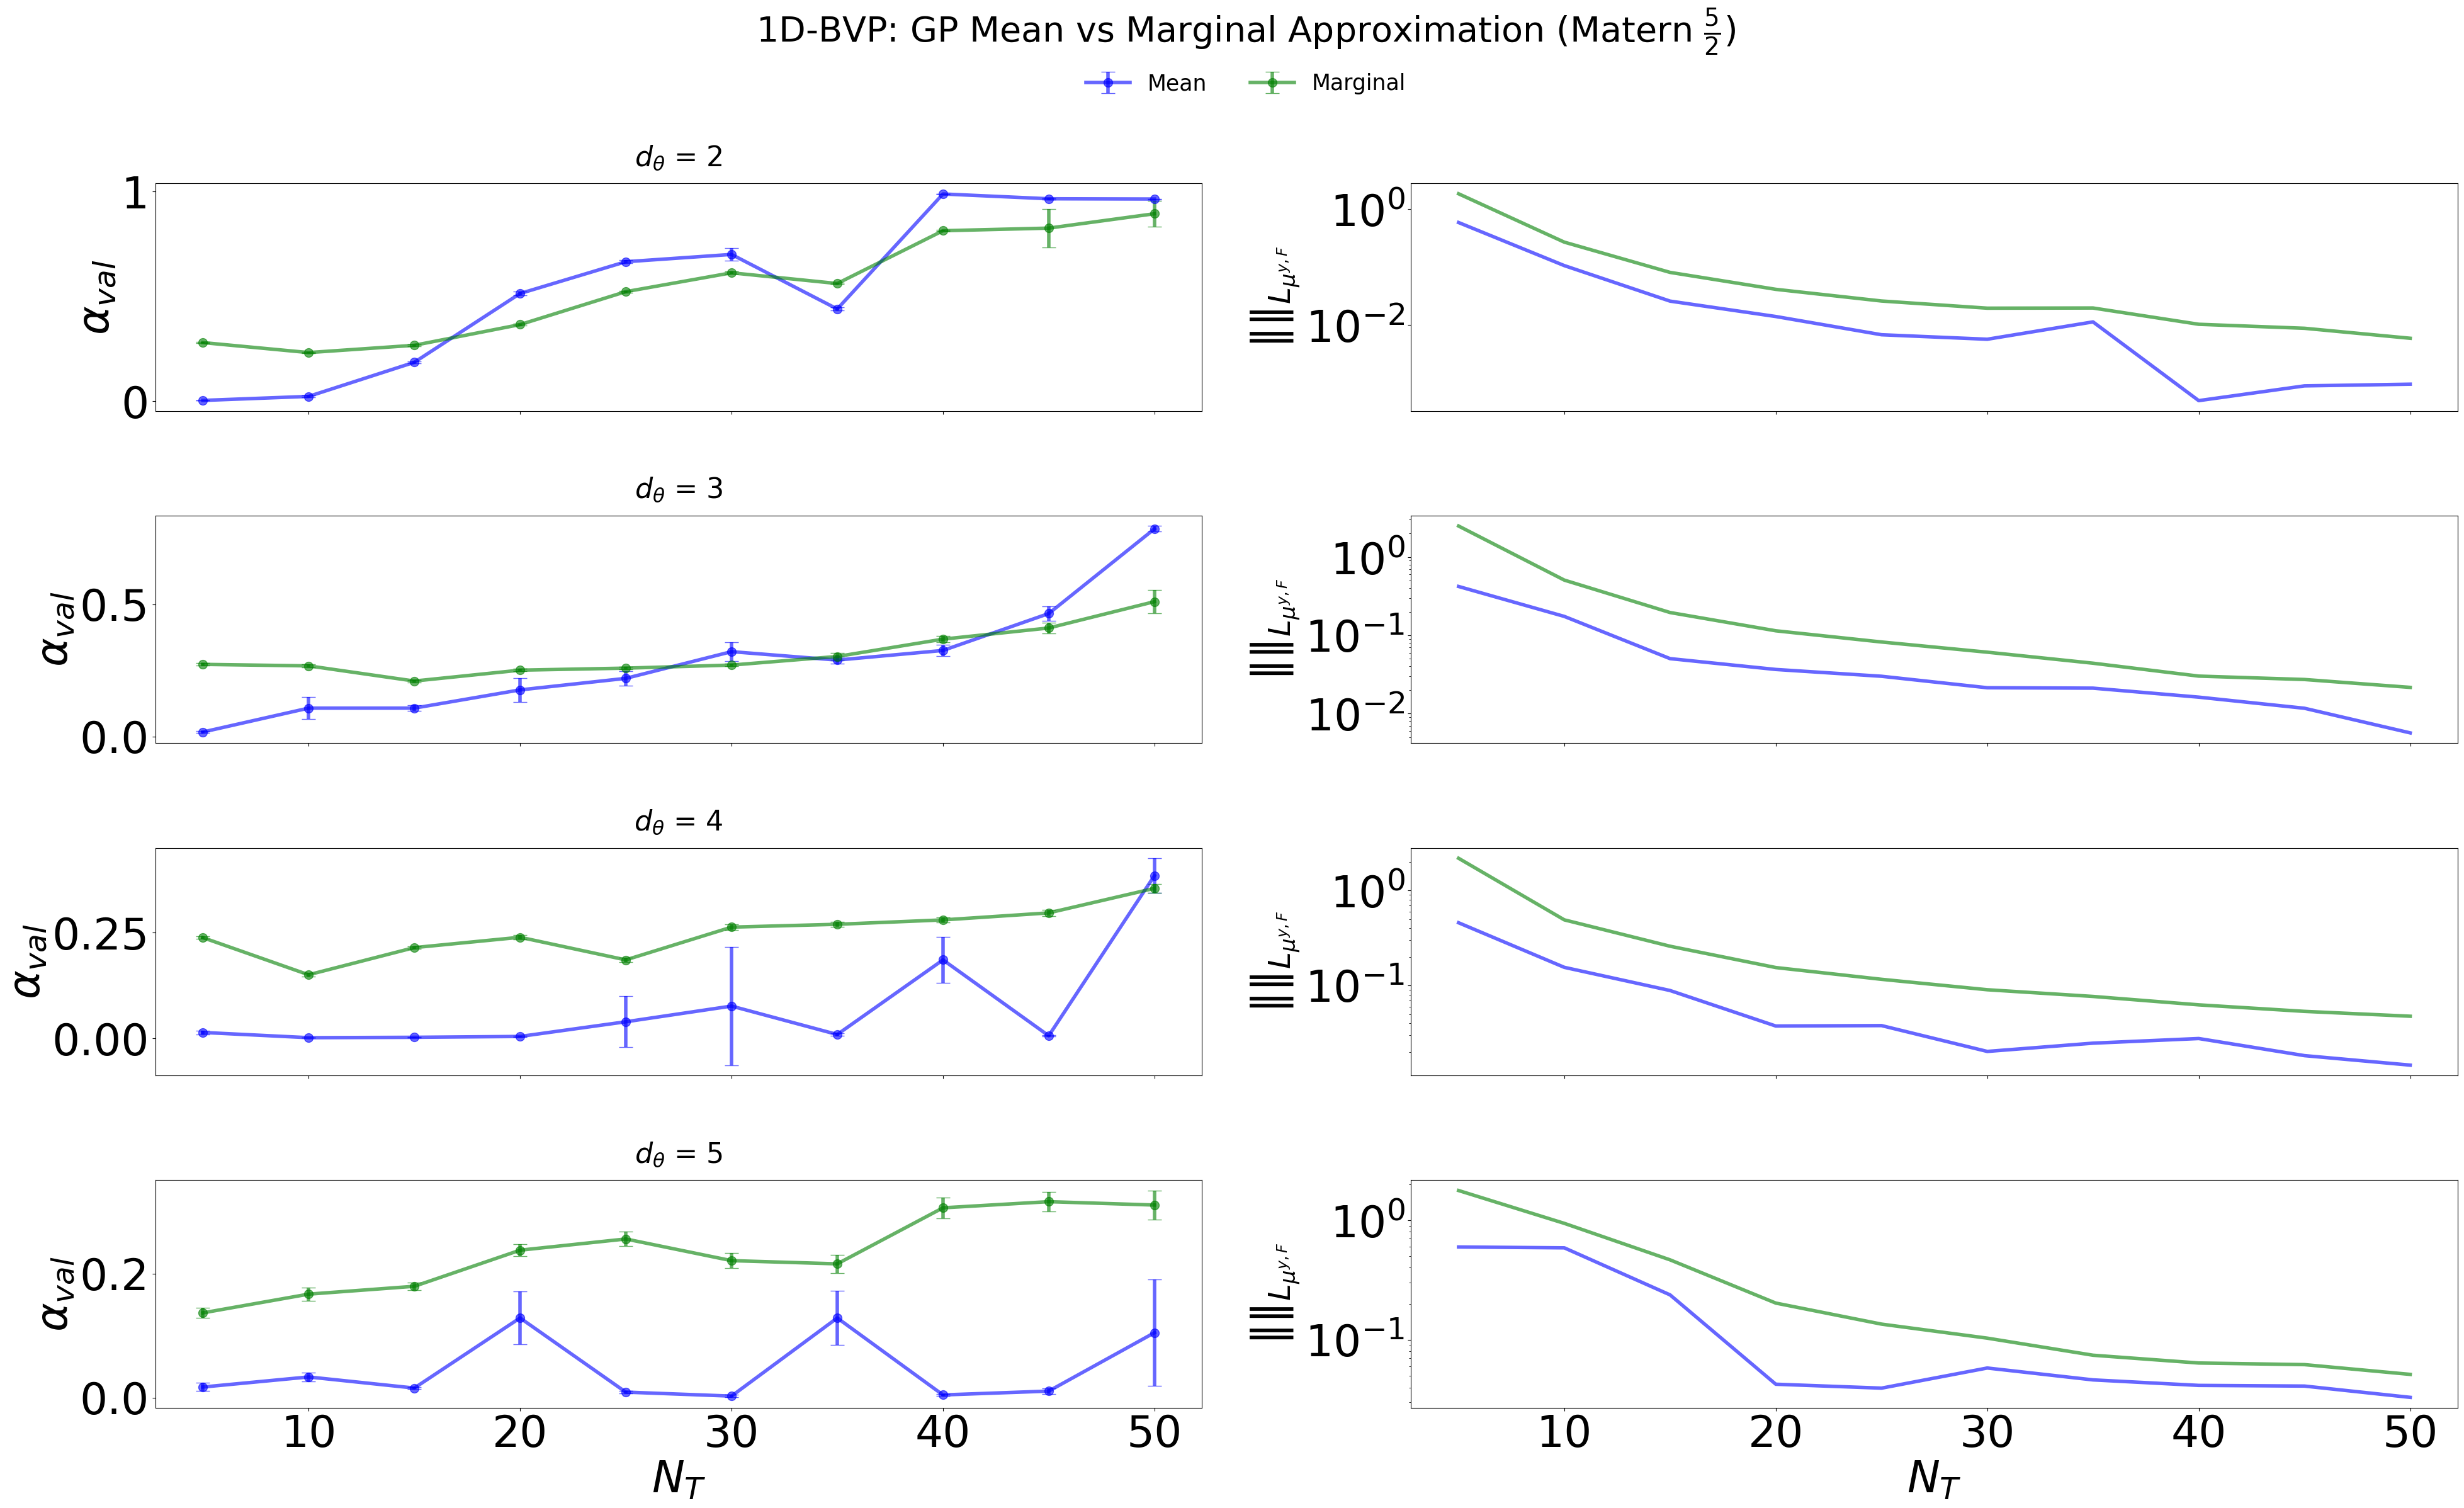

In [20]:
model_type = ["pigp"]
#Nts = [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
Nts = [5,10,15,20,25,30,35,40,45,50]

KLs = [2, 3, 4, 5]

res_mean = {}
res_mean_ma = {}

res_mean = final_results("pigp",KLs,Nts,marginal_approximation=False,
                                                    kernel_spatial="Matern52",kernel_parameter ="Matern52")

res_mean_ma = final_results("pigp",KLs,Nts,marginal_approximation=True,
                                                    kernel_spatial="Matern52",kernel_parameter ="Matern52")


fig, axs = plt.subplots(len(KLs),2, figsize=(40, 25), sharex=True)
fig.suptitle("1D-BVP: GP Mean vs Marginal Approximation (Matern $\\frac{{5}}{{2}}$)", fontsize = 40)
plt.rcParams.update({'font.size': 50})

for i,k in enumerate(KLs):
    axs[i, 0].set_title(f"$d_{{\\theta}}$ = {k}", fontsize=32, pad=20)

    # Example usage:
    mean, std = np.array(res_mean["alpha"][str(k)]).T
    axs[i,0].errorbar(Nts, mean, yerr=std, fmt="o-", capsize=8, label=f"Mean",color="blue",linewidth=4,markersize=10, alpha=0.6)
    
    mean, std = np.array(res_mean_ma["alpha"][str(k)]).T
    axs[i,0].errorbar(Nts, mean, yerr=std, fmt="o-", capsize=8, label=f"Marginal",color="green",linewidth=4,markersize=10, alpha=0.6)

    #axs[i,0].set_ylim((0,1))
    axs[i,0].set_ylabel("$\\alpha_{{val}}$")

    mean, std = np.array(res_mean["m_error"][str(k)]).T
    axs[i,1].semilogy(Nts, mean,label=f"Mean",color="blue",linewidth=4,markersize=10, alpha=0.6)
    
    mean, std = np.array(res_mean_ma["m_error"][str(k)]).T
    axs[i,1].semilogy(Nts, mean,label=f"Marginal", color="green",linewidth=4,markersize=10, alpha=0.6)
    axs[i,1].set_ylabel("$\\| \\|_{L_{\\mu^{y,F}}}$")


axs[-1,0].set_xlabel("$N_{{T}}$"), axs[-1,1].set_xlabel("$N_{{T}}$")

plt.tight_layout(rect=[0, 0, 1, 0.985])  # leave space for both title and legend

# --- ADD HORIZONTAL LEGEND ON TOP ---
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels,loc="upper center", ncol=2, fontsize=25, frameon=False, bbox_to_anchor=(0.5, 0.95))

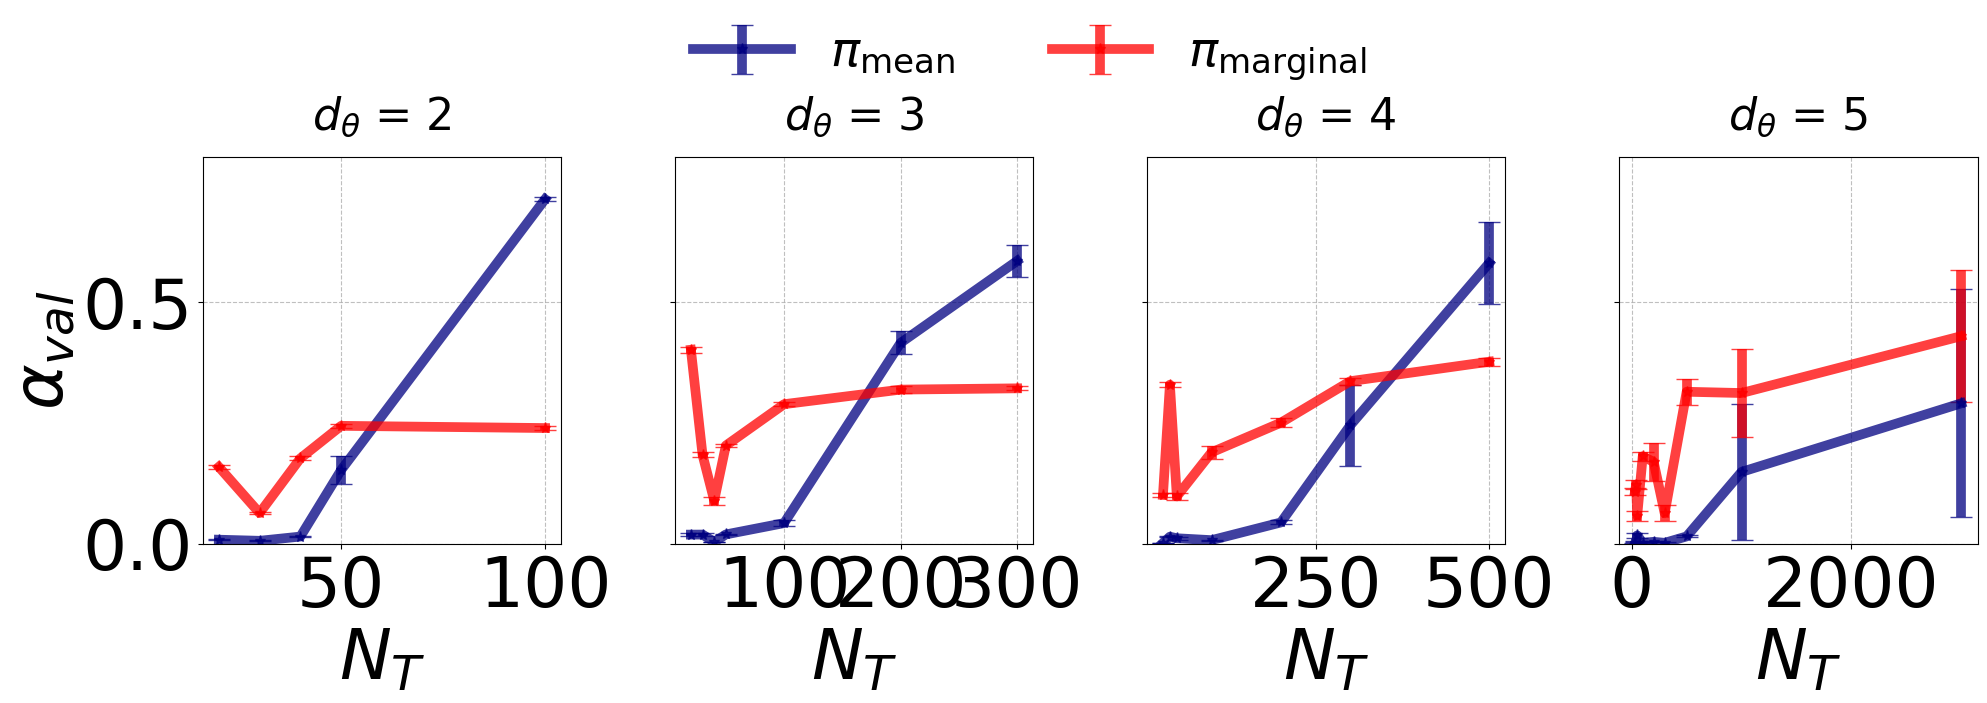

In [21]:
Ns = [ 20, 30,40, 50, 100, 200, 300,500,1000,3000,5000]
KLs = [2,3,4,5]

fig, axs = plt.subplots(1,len(KLs), figsize=(20, 8),sharex="col",sharey="row")
#fig.suptitle("1D-BVP: DeepGaLA-Low Data Regime", fontsize = 40)
plt.rcParams.update({'font.size': 35})

batch = 500
for i,k in enumerate(KLs):
    if k==2:
        n = -6
    elif k==3:
        n=-4
    elif k==4:
         n=-3
    else:
        n =-1
    t = 1 if k>3 else 0
    results = final_results(model_type="dgala2",KLs=[k],Nts=Ns[t:n],batch_size=batch,hidden_dim=60,marginal_approximation=False)
    results_mag = final_results(model_type="dgala2",KLs=[k],Nts=Ns[t:n],batch_size=batch,hidden_dim=60,marginal_approximation=True)

    axs[i].set_title(f"$d_{{\\theta}}$ = {k}", fontsize=32, pad=20)

    # Example usage:
    mean, std = np.array(results["alpha"][str(k)]).T
    axs[i].errorbar(Ns[t:n], mean, yerr=std, fmt="*-", capsize=8, label="$\pi_{\\text{mean}}$",linewidth=7,markersize=8,alpha=0.75,color="navy")
    axs[i].set_ylim((0,.8))

    # mean, std = np.array(results["m_error"][str(k)]).T
    # axs[1,i].semilogy(Ns[t:n], mean,label=rf"$\| \mathcal{{G}}_{{X}}^{{F}} -  m_{{S,N}}^{{\mathcal{{G}}}} \|_{{L_{{\mu^{{y,F}}}}^{{2}}}}$",linewidth=7,markersize=10, alpha=0.75,color="navy")

    mean, std = np.array(results_mag["alpha"][str(k)]).T
    axs[i].errorbar(Ns[t:n], mean, yerr=std, fmt="*-", capsize=8, label="$\pi_{\\text{marginal}}$",linewidth=7,markersize=8, alpha=0.75,color="red")
    #axs[0,i].set_ylim((0,.2))
    #axs[0,i].set_ylabel("$\\alpha_{{val}}$")

    # mean, std = np.array(results_mag["m_error"][str(k)]).T
    # axs[1,i].semilogy(Ns[t:n], mean,label=rf"$\left\|  \mathbb{{E}}_{{\mu^{{S,N}}}}\left[ \| \mathcal{{G}}_{{X}}^{{F}} -  \mathcal{{G}}_{{X}}^{{S,N}}\|_{2}^{2}\right] ^{{1/2}} \right\|_{{L_{{\mu^{{y,F}}}}}}$",linewidth=7,markersize=8, alpha=0.75,color="red")
    # # axs[1,i].set_ylabel("$\\| \\|_{L_{\\mu^{y,F}}^{2}}$")

    axs[i].set_xlabel("$N_{{T}}$")
    #, axs[1].set_xlabel("$N_{{T}}$")
    axs[i].grid(True, linestyle='--', alpha=0.8)
    #axs[1,i].grid(True, linestyle='--', alpha=0.8)


plt.tight_layout(rect=[0, 0, 1, 0.88])  # leave space for both title and legend
axs[0].set_ylabel("$\\alpha_{{val}}$")
#axs[1,0].set_ylabel("$\\| \cdot \\|$")

# --- ADD HORIZONTAL LEGEND ON TOP ---
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels,loc="upper center", ncol=2, fontsize=35, frameon=False, bbox_to_anchor=(0.5, 0.95))

# handles, labels = axs[1, 0].get_legend_handles_labels()
# fig.legend(handles, labels,loc="center", ncol=2, fontsize=35, frameon=False, bbox_to_anchor=(0.54, 0.48))

plt.savefig(f"./results/images/bvp1d_dgala_low_data.pdf", bbox_inches='tight') 

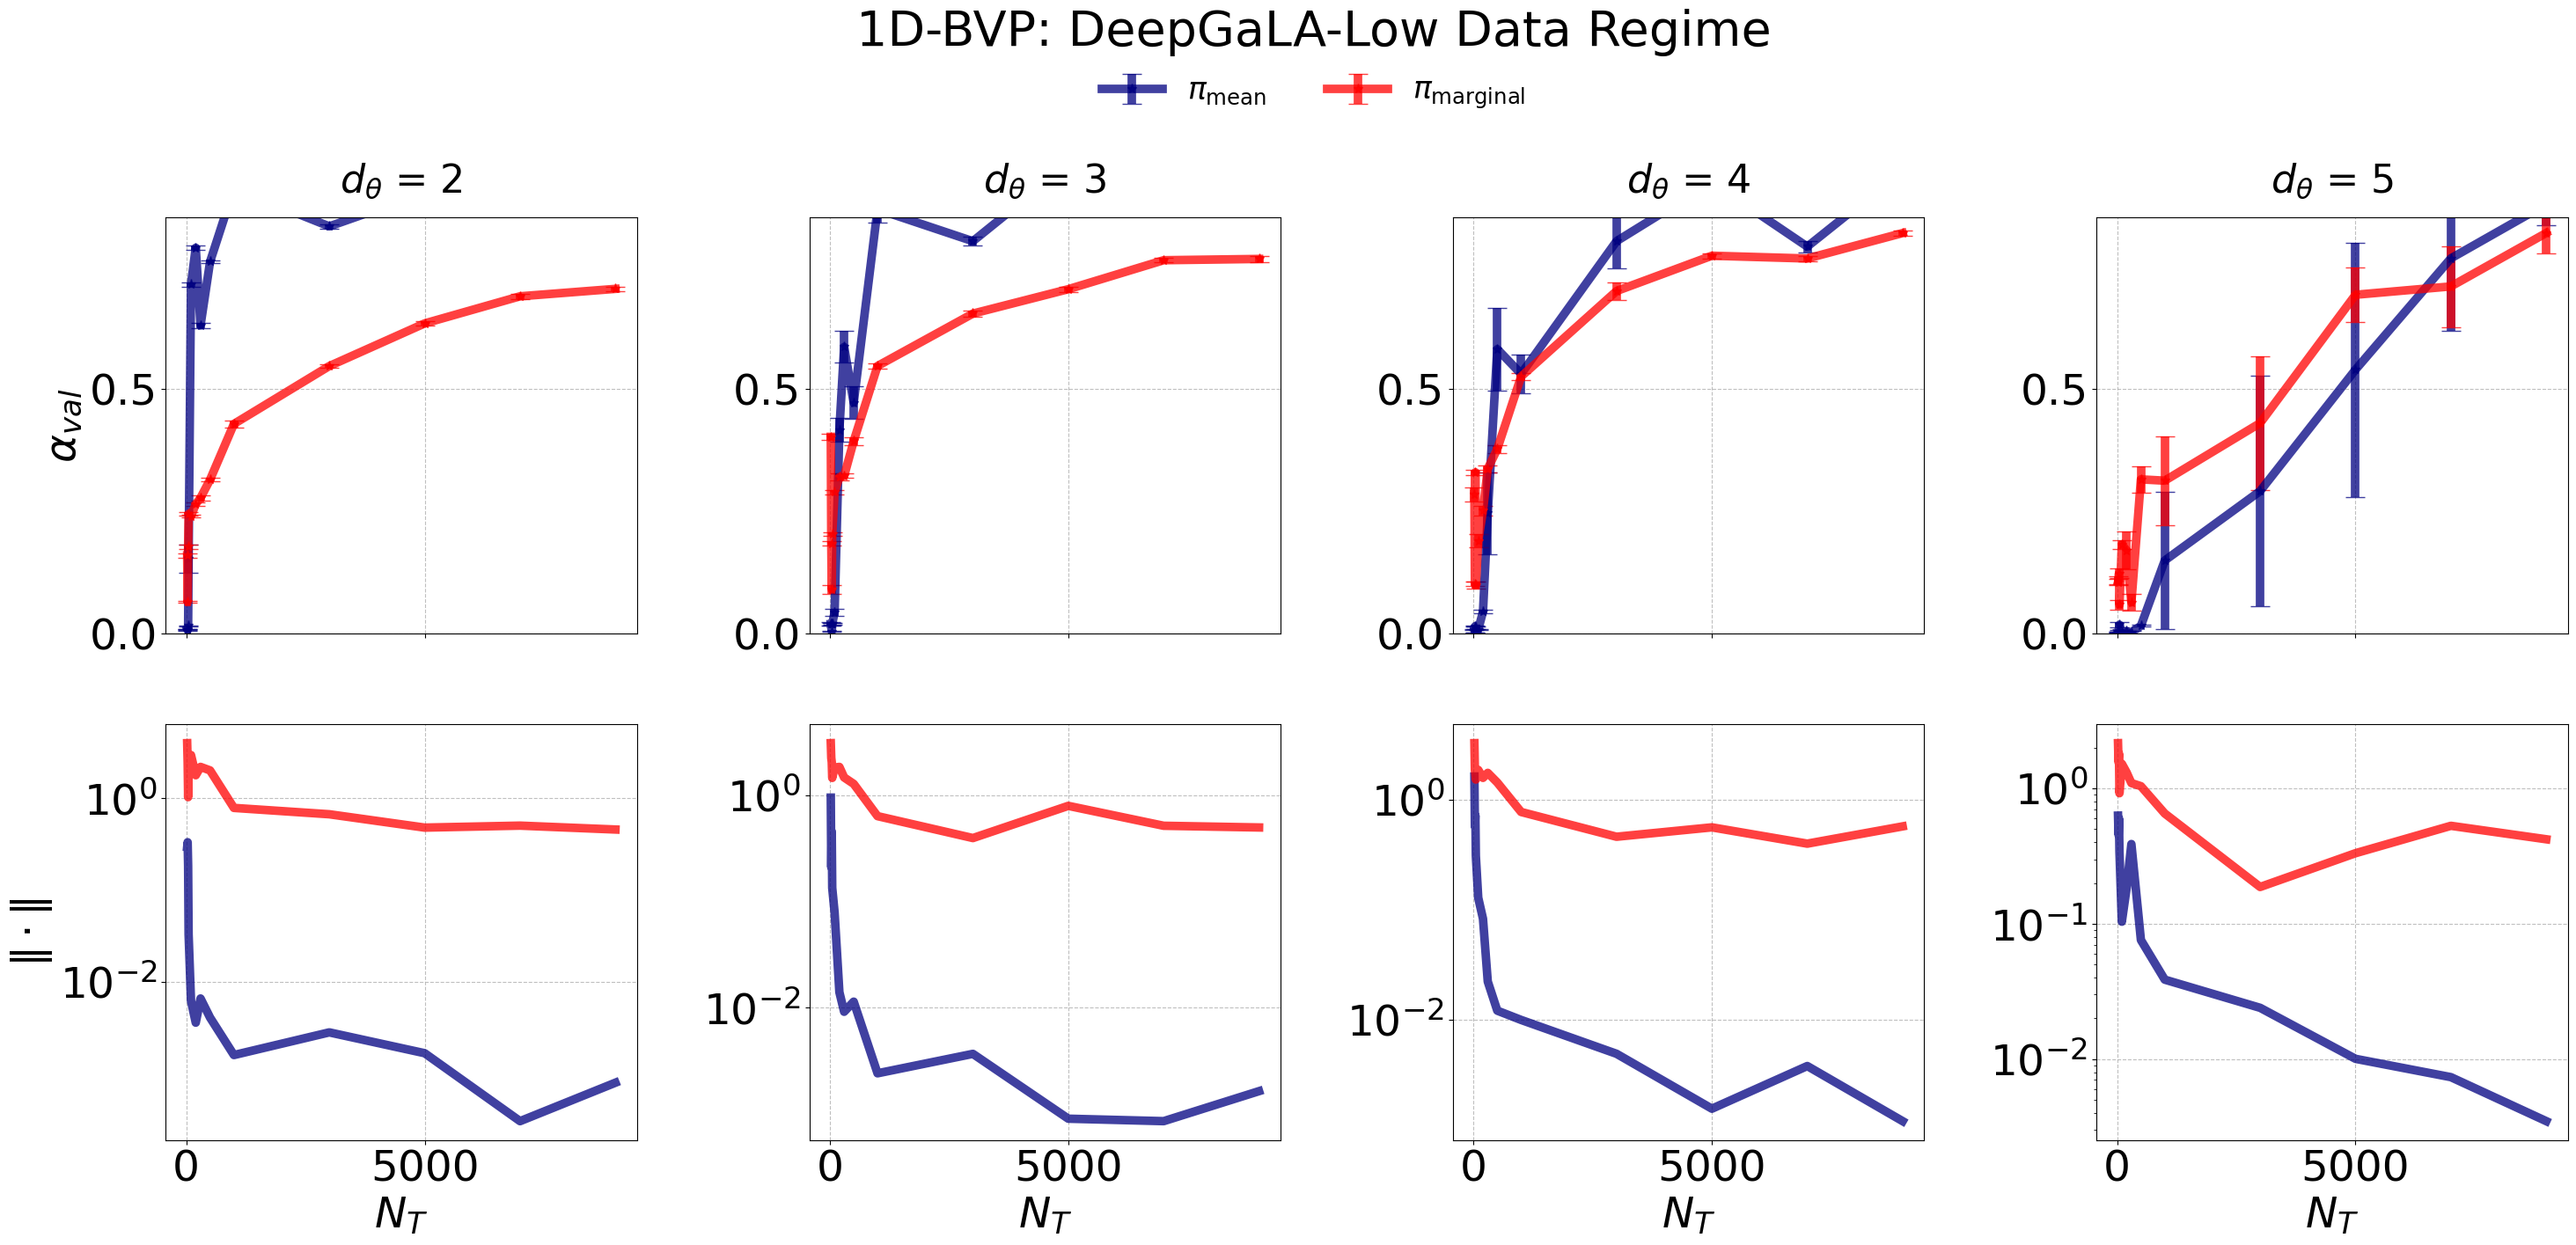

In [22]:
Ns = [ 20, 30,40, 50, 100, 200, 300,500,1000,3000,5000,7000,9000]
KLs = [2,3,4,5]

fig, axs = plt.subplots(2,len(KLs), figsize=(30, 15),sharex="col")
fig.suptitle("1D-BVP: DeepGaLA-Low Data Regime", fontsize = 40)
plt.rcParams.update({'font.size': 50})

batch = 500
for i,k in enumerate(KLs):

    results = final_results(model_type="dgala2",KLs=[k],Nts=Ns,batch_size=batch,hidden_dim=60,marginal_approximation=False)
    results_mag = final_results(model_type="dgala2",KLs=[k],Nts=Ns,batch_size=batch,hidden_dim=60,marginal_approximation=True)

    axs[0,i].set_title(f"$d_{{\\theta}}$ = {k}", fontsize=32, pad=20)

    # Example usage:
    mean, std = np.array(results["alpha"][str(k)]).T
    axs[0,i].errorbar(Ns, mean, yerr=std, fmt="*-", capsize=8, label="$\pi_{\\text{mean}}$",linewidth=7,markersize=8,alpha=0.75,color="navy")
    axs[0,i].set_ylim((0,.85))

    mean, std = np.array(results["m_error"][str(k)]).T
    axs[1,i].semilogy(Ns, mean,label=f"Mean",linewidth=7,markersize=10, alpha=0.75,color="navy")

    mean, std = np.array(results_mag["alpha"][str(k)]).T
    axs[0,i].errorbar(Ns, mean, yerr=std, fmt="*-", capsize=8, label="$\pi_{\\text{marginal}}$",linewidth=7,markersize=8, alpha=0.75,color="red")
    #axs[0,i].set_ylim((0,.2))
    #axs[0,i].set_ylabel("$\\alpha_{{val}}$")

    mean, std = np.array(results_mag["m_error"][str(k)]).T
    axs[1,i].semilogy(Ns, mean,label=f"Marginal",linewidth=7,markersize=8, alpha=0.75,color="red")
    # axs[1,i].set_ylabel("$\\| \\|_{L_{\\mu^{y,F}}^{2}}$")

    axs[-1,i].set_xlabel("$N_{{T}}$"), axs[-1,1].set_xlabel("$N_{{T}}$")
    axs[0,i].grid(True, linestyle='--', alpha=0.8)
    axs[1,i].grid(True, linestyle='--', alpha=0.8)


    plt.tight_layout(rect=[0, 0, 1, 1])  # leave space for both title and legend
axs[0,0].set_ylabel("$\\alpha_{{val}}$")
axs[1,0].set_ylabel("$\\| \cdot \\|$")

# --- ADD HORIZONTAL LEGEND ON TOP ---
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels,loc="upper center", ncol=2, fontsize=25, frameon=False, bbox_to_anchor=(0.5, 0.95))
plt.savefig(f"./results/images/bvp1d_dgala_low_data.pdf", bbox_inches='tight') 

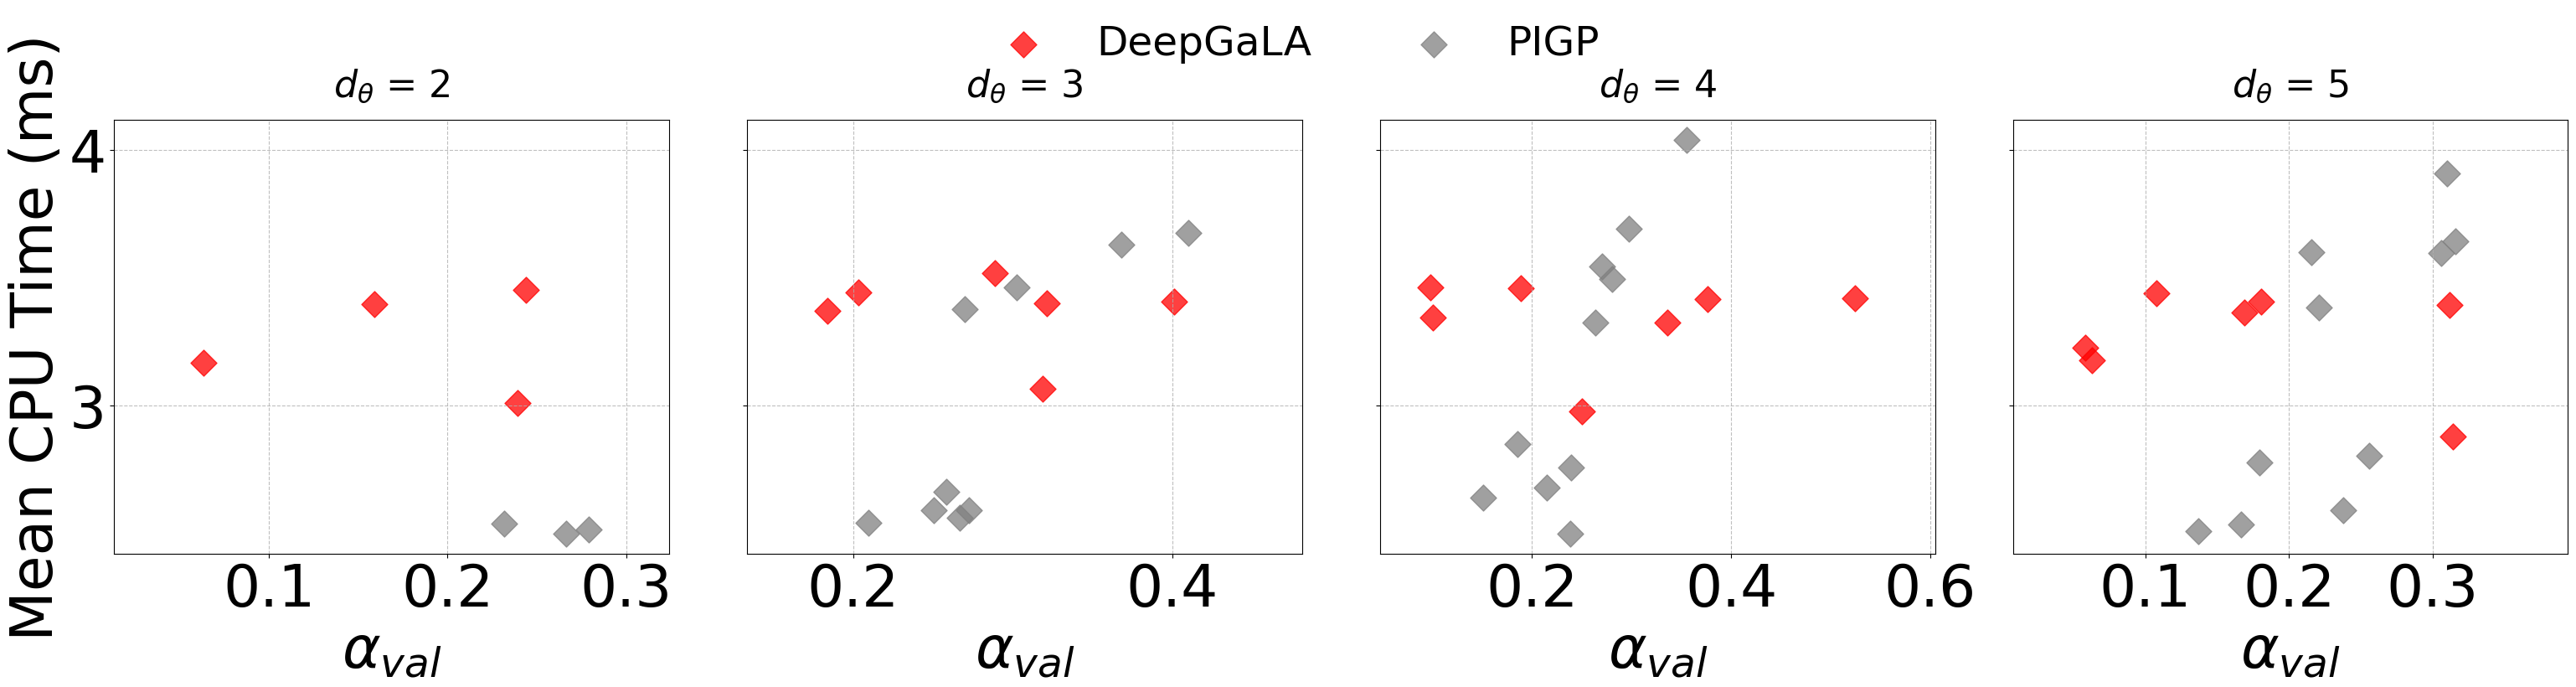

In [23]:
Ns = [ 20, 30, 50, 100, 200, 300,500,1000,2000]
BATCHES = [100, 100, 100, 100]
hd5 = [90]*len(Ns)
KLs = [2,3,4,5]

fig, axs = plt.subplots(1,len(KLs), figsize=(32, 10),sharey="row", sharex="col")
#fig.suptitle("1D-BVP: Marginal Likelihood Evaluation time (Low Data Regime) ", fontsize = 40)
plt.rcParams.update({'font.size': 50})

batch = 500
for i,k in enumerate(KLs):
    if k==2:
        n = -5
    elif k==3:
        n=-3
    else:
        n =-1
    t = 1 if k>3 else 0
    #results = final_results(model_type="dgala2",KLs=[k],Nts=Ns[t:n],batch_size=batch,hidden_dim=60,marginal_approximation=False)
    results_mag = final_results(model_type="dgala2",KLs=[k],Nts=Ns[t:n],batch_size=batch,hidden_dim=60,marginal_approximation=True)

    mean_mag_time, std_mag_time = np.array(results_mag["total_cpu_time"][str(k)]).T
    mean_error, std_mag_ = np.array(results_mag["alpha"][str(k)]).T

    mean_mag_time_gp, std_gp_time = np.array(res_mean_ma["total_cpu_time"][str(k)]).T
    mean_mag_error_gp, std_gp_ = np.array(res_mean_ma["alpha"][str(k)]).T
    axs[i].set_title(f"$d_{{\\theta}}$ = {k}", fontsize=32, pad=20)

    axs[i].scatter(mean_error, mean_mag_time*1000,label=f"DeepGaLA", s=250,marker="D", alpha=0.75,color="red") 
    axs[i].scatter(mean_mag_error_gp, mean_mag_time_gp*1000,label=f"PIGP", s=250,marker="D", alpha=0.75,color="gray")
    # axs[i].errorbar(mean_error,mean_mag_time,xerr=std_mag_,yerr=std_mag_time,
    #     fmt='o', markersize=10,capsize=5,elinewidth=3,alpha=0.75,color="red",label="DeepGaLA")

    # axs[i].errorbar(mean_mag_error_gp,mean_mag_time_gp,xerr=std_gp_,yerr=std_gp_time,
    # fmt='o', markersize=10,capsize=5,elinewidth=3,alpha=0.75,color="gray",label="PIGP")

    axs[i].set_xlim(np.min(mean_error)-0.05,np.max(mean_error) +0.08)
    axs[i].set_xlabel("$\\alpha_{{val}}$")

    axs[i].grid(True, linestyle='--', alpha=0.8)


plt.tight_layout(rect=[0, 0, 1, 0.88])  # leave space for both title and legend
axs[0].set_ylabel("Mean CPU Time (ms)")

# --- ADD HORIZONTAL LEGEND ON TOP ---
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels,loc="upper center", ncol=2, fontsize=35, frameon=False, bbox_to_anchor=(0.5, 0.90))
plt.savefig(f"./results/images/bvp1d_eval_time_low_data.pdf", bbox_inches='tight') 

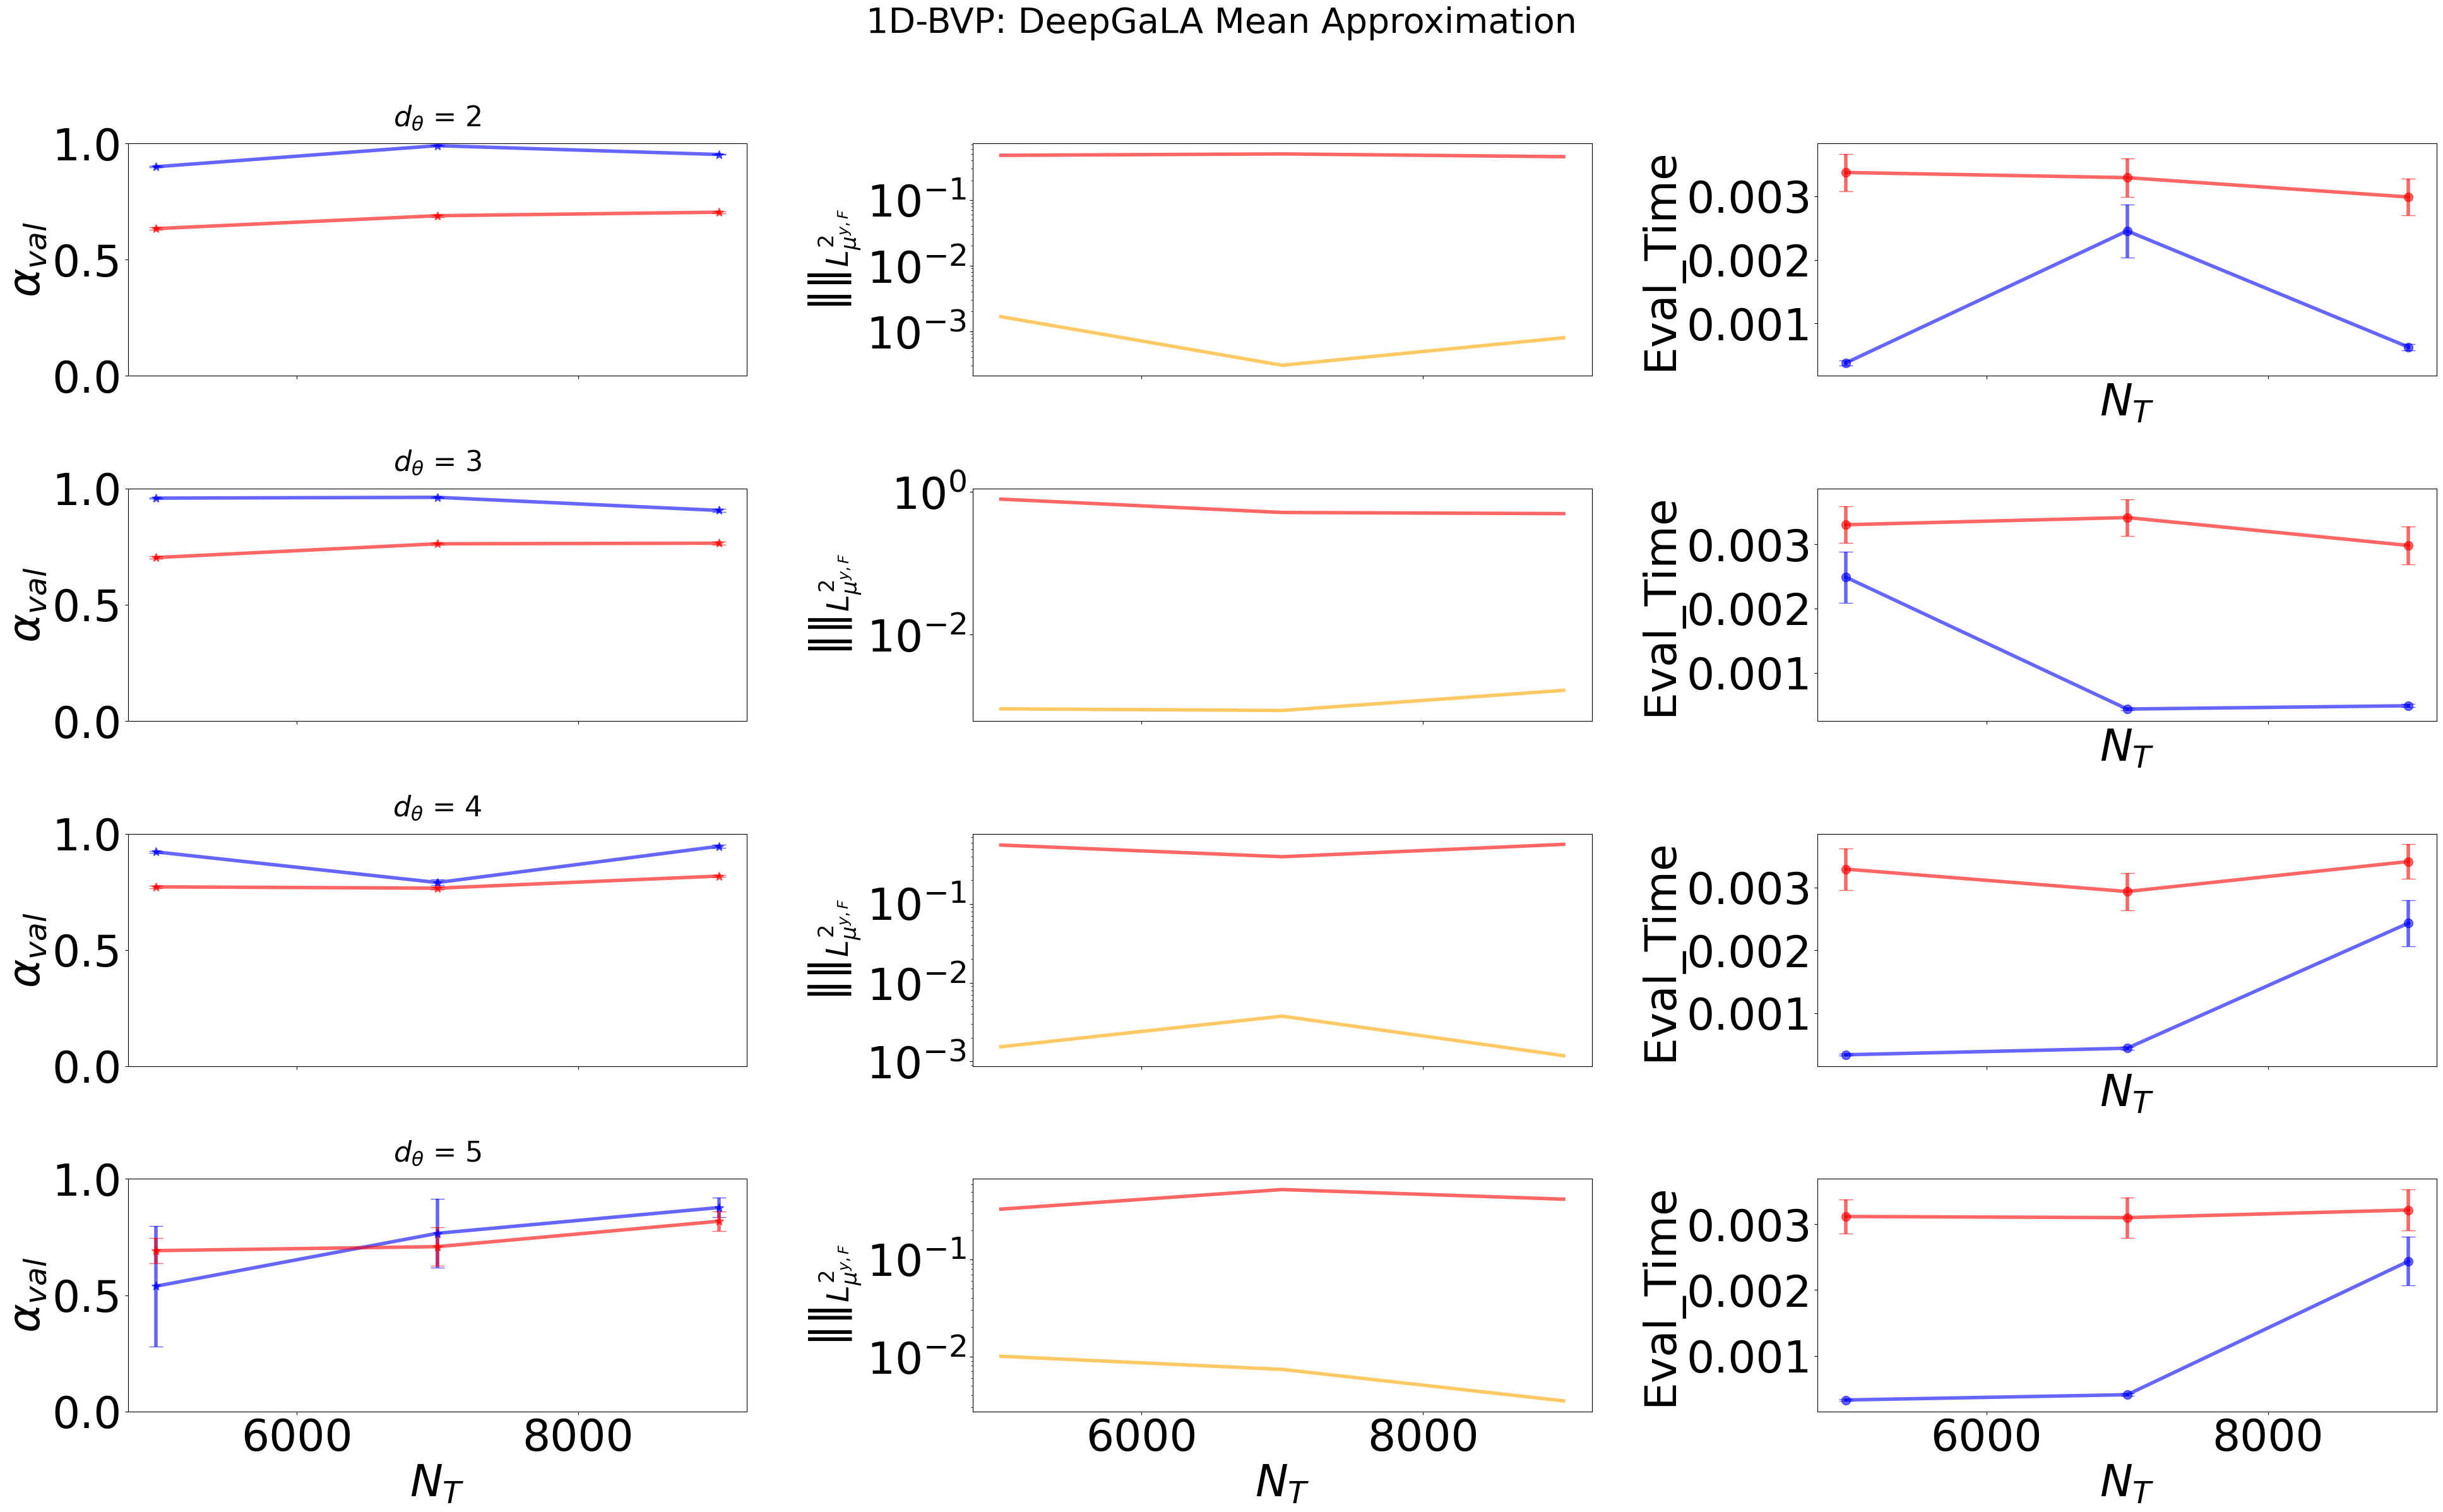

In [18]:
Ns = [ 5000,7000,9000]

BATCHES = [100, 200, 400, 500]
hd5 = [90]*len(Ns)
KLs = [2,3,4,5]

batch =500

results = final_results(model_type="dgala2",KLs=KLs,Nts=Ns,batch_size=batch,hidden_dim=60,marginal_approximation=False)
results_mag = final_results(model_type="dgala2",KLs=KLs,Nts=Ns,batch_size=batch,hidden_dim=60,marginal_approximation=True)

fig, axs = plt.subplots(len(KLs),3, figsize=(40, 25), sharex=True)
fig.suptitle("1D-BVP: DeepGaLA Mean Approximation", fontsize = 40)
plt.rcParams.update({'font.size': 50})

for i,k in enumerate(KLs):
    axs[i, 0].set_title(f"$d_{{\\theta}}$ = {k}", fontsize=32, pad=20)

    # Example usage:
    mean, std = np.array(results["alpha"][str(k)]).T
    axs[i,0].errorbar(Ns, mean, yerr=std, fmt="*-", capsize=8, label=f"Mean", color="blue",linewidth=4,markersize=10,alpha=0.6)
    axs[i,0].set_ylim((0,1))
    axs[i,0].set_ylabel("$\\alpha_{{val}}$")

    mean, std = np.array(results["m_error"][str(k)]).T
    axs[i,1].semilogy(Ns, mean,label=f"Mean", color="orange",linewidth=4,markersize=10, alpha=0.6)
    axs[i,1].set_ylabel("$\\| \\|_{L_{\\mu^{y,F}}^{2}}$")

    mean, std = np.array(results["total_cpu_time"][str(k)]).T
    axs[i,2].errorbar(Ns, mean,yerr=std, fmt="o-", capsize=8, label=f"Mean",color="blue",linewidth=4,markersize=10, alpha=0.6)
    axs[i,2].set_xlabel("$N_{{T}}$")
    axs[i,2].set_ylabel("Eval_Time")


    # Example usage:
    mean, std = np.array(results_mag["alpha"][str(k)]).T
    axs[i,0].errorbar(Ns, mean, yerr=std, fmt="*-", capsize=8, label=f"Marginal$", color="red",linewidth=4,markersize=10,alpha=0.6)
    axs[i,0].set_ylim((0,1))
    axs[i,0].set_ylabel("$\\alpha_{{val}}$")

    mean, std = np.array(results_mag["m_error"][str(k)]).T
    axs[i,1].semilogy(Ns, mean,label=f"Marginal", color="red",linewidth=4,markersize=10, alpha=0.6)
    axs[i,1].set_ylabel("$\\| \\|_{L_{\\mu^{y,F}}^{2}}$")

    mean, std = np.array(results_mag["total_cpu_time"][str(k)]).T
    axs[i,2].errorbar(Ns, mean,yerr=std, fmt="o-", capsize=8, label=f"Marginal",color="red",linewidth=4,markersize=10, alpha=0.6)
    axs[i,2].set_xlabel("$N_{{T}}$")
    axs[i,2].set_ylabel("Eval_Time")
    # mean, std = np.array(results["total_flops"][str(k)]).T
    # axs[i,3].errorbar(Ns, mean,yerr=std, fmt="o-", capsize=8, label=f"SE",color="blue",linewidth=4,markersize=10, alpha=0.6)
    # axs[i,3].set_xlabel("$N_{{T}}$")
    # axs[i,3].set_ylabel("Flops")

axs[-1,0].set_xlabel("$N_{{T}}$"), axs[-1,1].set_xlabel("$N_{{T}}$")

plt.tight_layout(rect=[0, 0, 1, 1])  # leave space for both title and legend

# --- ADD HORIZONTAL LEGEND ON TOP ---
#handles, labels = axs[0, 0].get_legend_handles_labels()
#fig.legend(handles, labels,loc="upper center", ncol=2, fontsize=25, frameon=False, bbox_to_anchor=(0.5, 0.95))
#plt.savefig(f"./results/images/bvp1d_nn_mean_convergence.jpg", bbox_inches='tight') 

In [22]:
ks = 5
print(results["alpha"][str(ks)])
print(results["m_error"][str(ks)])
print(results["total_cpu_time"][str(ks)])
print(results["total_cuda_time"][str(ks)])

[(0.5387600038200617, 0.25997226788733796), (0.7662900000810623, 0.14746234015746712), (0.8769900083541871, 0.042361127619636445)]
[(0.010033217898919655, 1.428352435714362e-05), (0.007344086981838653, 6.568384354316106e-06), (0.0034711870978354313, 7.3760702632935924e-06)]
[(0.00032861406140614056, 1.3663924640464309e-05), (0.0004085741574157416, 1.781533650676034e-05), (0.0024372643264326433, 0.00036922464181326803)]
[(0.0, 0.0), (0.0, 0.0), (0.000235628, 1.8123223112901302e-05)]


In [45]:
ks = 2
print(results_mag["alpha"][str(ks)])
print(results_mag["m_error"][str(ks)])
print(results_mag["total_cpu_time"][str(ks)])
print(results_mag["total_cuda_time"][str(ks)])

[(0.6332800030708313, 0.00484000402543097), (0.6887200057506562, 0.00498213630637434), (0.703880000114441, 0.004317580410995483)]
[(0.48077411689804944, 1.9673863418157943e-06), (0.5051762018411187, 8.835772035765426e-07), (0.4583242935848511, 4.3931918585631304e-07)]
[(0.0033949991999999993, 0.0024770815399981004), (0.0033054088999999996, 0.0016031102172030436), (0.0031591702000000003, 0.017334447154577267)]
[(0.0007150883999999999, 3.9969219957362276e-06), (0.0007092736, 3.264895563413933e-06), (0.0007149302000000001, 3.745494354554558e-06)]


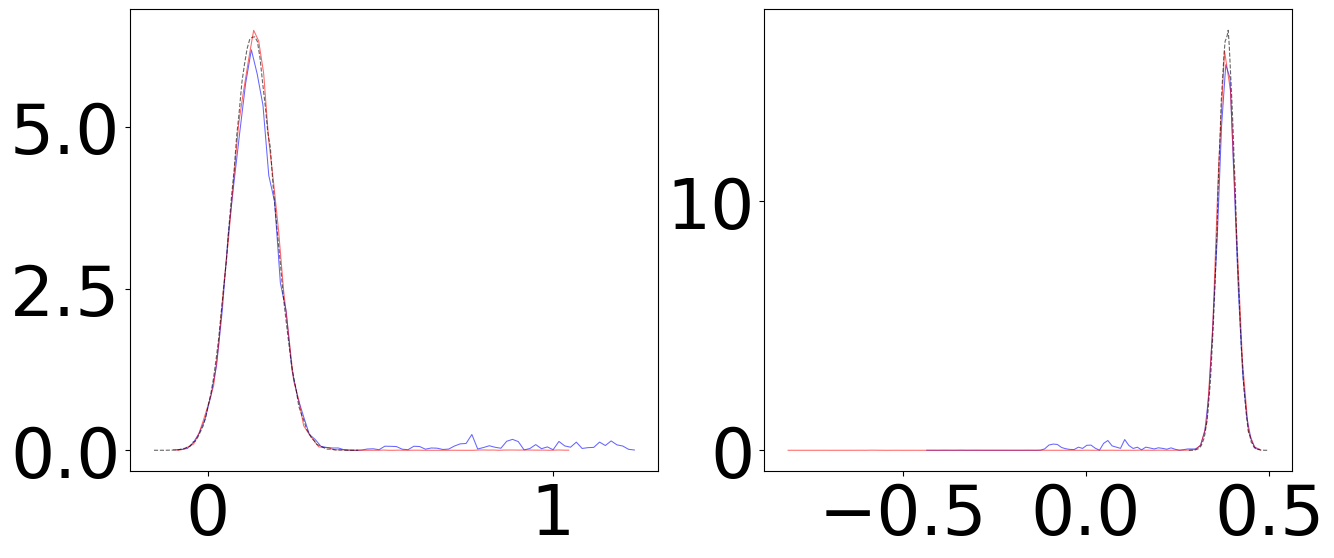

In [25]:
kl =2 
n = 50
bc = 10

fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharex="col")

sample = np.load(f'./results/FEM_mcmc_kl{kl}_0.npy')
sampler = np.load(f'./results/dgala_da_chain_mean_hl2_hd60_s{n}_b{bc}_kl{kl}_0.npy')
sampler_mg = np.load(f'./results/dgala_da_chain_marginal_hl2_hd60_s{n}_b{bc}_kl{kl}_0.npy')

for j in range(kl):
        bin_centers, counts = histogram_(sampler[:, j], bins=80)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75,
                    color="blue", label=f"mean" if j == 0 else None)  # Label only once per N
        
        bin_centers, counts = histogram_(sampler_mg[:, j], bins=80)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75,
                    color="red", label=f"marginal" if j == 0 else None)  # Label only once per N
        
        
        bin_centers, counts = histogram_(sample[:, j],bins=80)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.8, label = r"$\pi_{\text{FEM}}$",color = "black")


# DeepGALA

In [ ]:
import arviz as az
chain_fem = [np.load(f'./results/FEM_kl{2}_var0.0001_{i}.npy') for i in range(3)]
chain_fem = [np.load(f'./results/FEM_kl{5}_var0.0001_{i}.npy') for i in range(3)]
#chain_fem = [np.load(f"./results/PIGP_mean_spatial6_nsol{75}_kl{4}_var0.0001_{i}.npy") for i in range(4)]
#chain_nn = [np.load(f"./results/mcmc_da_nn_hl2_nn100_s4000_batch{250}_kl{5}_0.0001_{i}.npy") for i in range(4)]

chains = np.stack(chain_fem, axis=0)

print(chains.shape)  

idata = az.from_dict(posterior={"param": chains})
# Effective sample size
ess = az.ess(idata)
print("ESS:\n", ess)

# R-hat statistic
rhat = az.rhat(idata)
print("R-hat:\n", rhat)

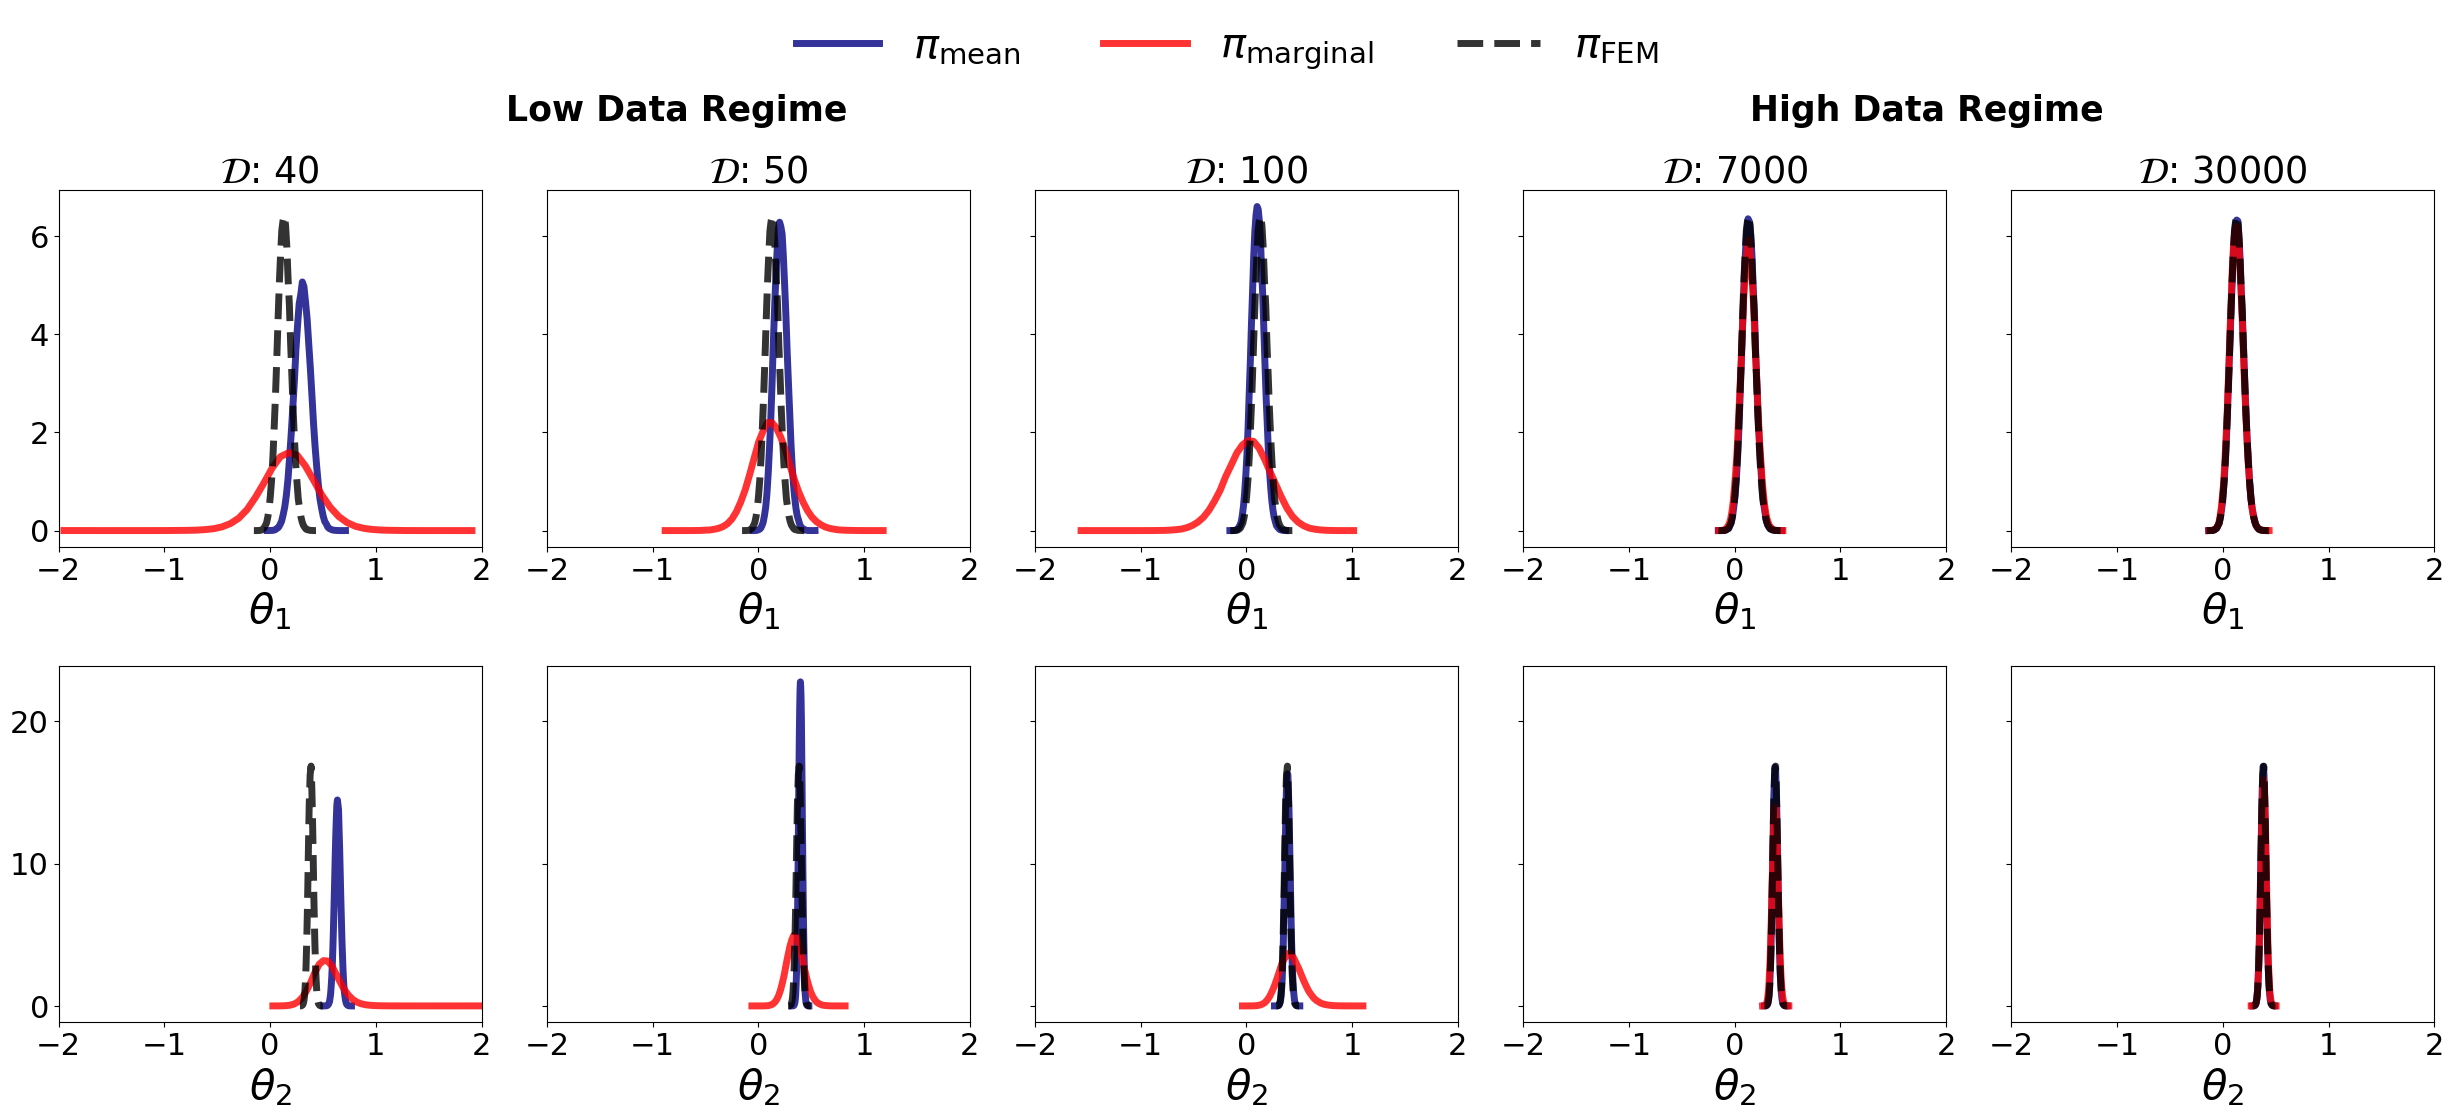

In [31]:
vr = 1e-4
theta_th = np.array([0.098, 0.430, 0.206, 0.090, -0.153, 0.292])

Nl = [40,50]
Nh = [100, 7000,30000]
N = Nl + Nh
batches = [10]*len(Nl) +[500] +[500]+[500]
# N = [10,30,50,100,200,500,2000,3000]
# batches = [10,10,10,100,100,100,100,100]
bins = 50
kl = 2
nn = 60

fig, axs = plt.subplots(2,len(N), figsize=(25, 12), sharex="row",sharey="row")
#fig.suptitle(f"Posterior Distributions")
plt.rcParams.update({'font.size': 22})
ylims = []

# --- Add subtitles for column groups ---
fig.text(0.28, 0.85, 'Low Data Regime', ha='center', fontsize=25,fontweight='bold')   # center above columns 1-2
fig.text(0.78, 0.85, 'High Data Regime', ha='center', fontsize=25,fontweight='bold')  # center above columns 3-4


for i,(nobs,batch) in  enumerate(zip(N,batches)):

    sample = np.load(f'./results/dgala_mcmc_mean_hl{2}_hd{nn}_s{nobs}_b{batch}_kl{kl}_0.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0,i].plot(bin_centers, counts, alpha=0.8, linestyle="-", linewidth=5, label = r"$\pi_{\text{mean}}$",color = "navy")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1,i].plot(bin_centers, counts, alpha=0.8, linestyle="-", linewidth=5, label = r"$\pi_{\text{mean}}$",color = "navy")

    sample = np.load(f'./results/dgala_mcmc_marginal_hl{2}_hd{nn}_s{nobs}_b{batch}_kl{kl}_0.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0,i].plot(bin_centers, counts, alpha=0.8, linestyle="-", linewidth=5, label =r"$\pi_{\text{marginal}}$",color = "red")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1,i].plot(bin_centers, counts, alpha=0.8, linestyle="-", linewidth=5, label = r"$\pi_{\text{marginal}}$",color = "red")
    
    sample = np.load(f'./results/FEM_mcmc_kl{kl}_0.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0,i].plot(bin_centers, counts, alpha=0.8, linestyle="--", linewidth=5, label = r"$\pi_{\text{FEM}}$",color = "black")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1,i].plot(bin_centers, counts, alpha=0.8, linestyle="--", linewidth=5, label = r"$\pi_{\text{FEM}}$",color = "black")
    
    axs[0,i].set_xlabel("$\\theta_{1}$",color="black",fontsize = 30),axs[1,i].set_xlabel("$\\theta_{2}$",color="black",fontsize = 30)
    axs[0,i].set_title(f"$\mathcal{{D}}$: {nobs}", color ="black")

    # axs[0,0].set_xlim((-0.55,0.8))
    # axs[1,0].set_xlim((0,0.85))
    axs[0,0].set_xlim((-2,2))
    axs[1,0].set_xlim((-2,2))
    
    axs[0,i].tick_params(axis='both', labelsize=22)
    axs[1,i].tick_params(axis='both', labelsize=22)

plt.tight_layout(rect=[0, 0, 1, 0.85])  # leave space for both title and legend

# --- ADD HORIZONTAL LEGEND ON TOP ---
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels,loc="upper center", ncol=3, fontsize=30, frameon=False, bbox_to_anchor=(0.5, 0.96))
plt.savefig(f"./results/images/bvp1d_dgala_marginal_convergence.pdf", bbox_inches='tight') 

In [ ]:

def error_checker(model,n_resample,KL_expansion):
    obs_points, _ = generate_noisy_obs(obs=6,std=np.sqrt(1e-4),nparam=KL_expansion,vert=50)
    obs_points = torch.tensor(obs_points,device = device, dtype = torch.float64)

    fem_eval_path = f"./results/FEM_mcmc_eval_kl{KL_expansion}_{0}.npy"
    fem_chain_path = f"./results/FEM_mcmc_kl{KL_expansion}_{0}.npy"

    chain_fem = torch.tensor(np.load(fem_chain_path),device = device, dtype = torch.float64)
    eval_fem =  torch.tensor(np.load(fem_eval_path),device = device, dtype = torch.float64)
    N = chain_fem.shape[0]

    bound_error = []
    for s in range(3):
        # seed = 42 + s
        # torch.manual_seed(seed)

        indices = torch.randint(low=0, high=N, size=(n_resample,))
        chain_fem_resampled = chain_fem[indices,:]
        eval_fem_resampled = eval_fem[indices,:]
        
        error_mcmc = error_norm_mean(model, eval_fem_resampled, obs_points,chain_fem_resampled, device, gp=False)
        
        bound_error.append(error_mcmc)

    return bound_error

Ns = [ 20, 30,40, 50, 100, 200, 300,500,1000,3000,5000]

results = {10:[],1_000:[], 100_000:[], 250_000:[]}

for nres in results.keys():
    for n in Ns:
        b = 10 if n<100 else 500

        model = torch.load(f"./models/dgala_mean_hl2_hd60_s{n}_b{b}_kl{2}.pth")

        res = error_checker(model,nres,2)

        results[nres].append(res)


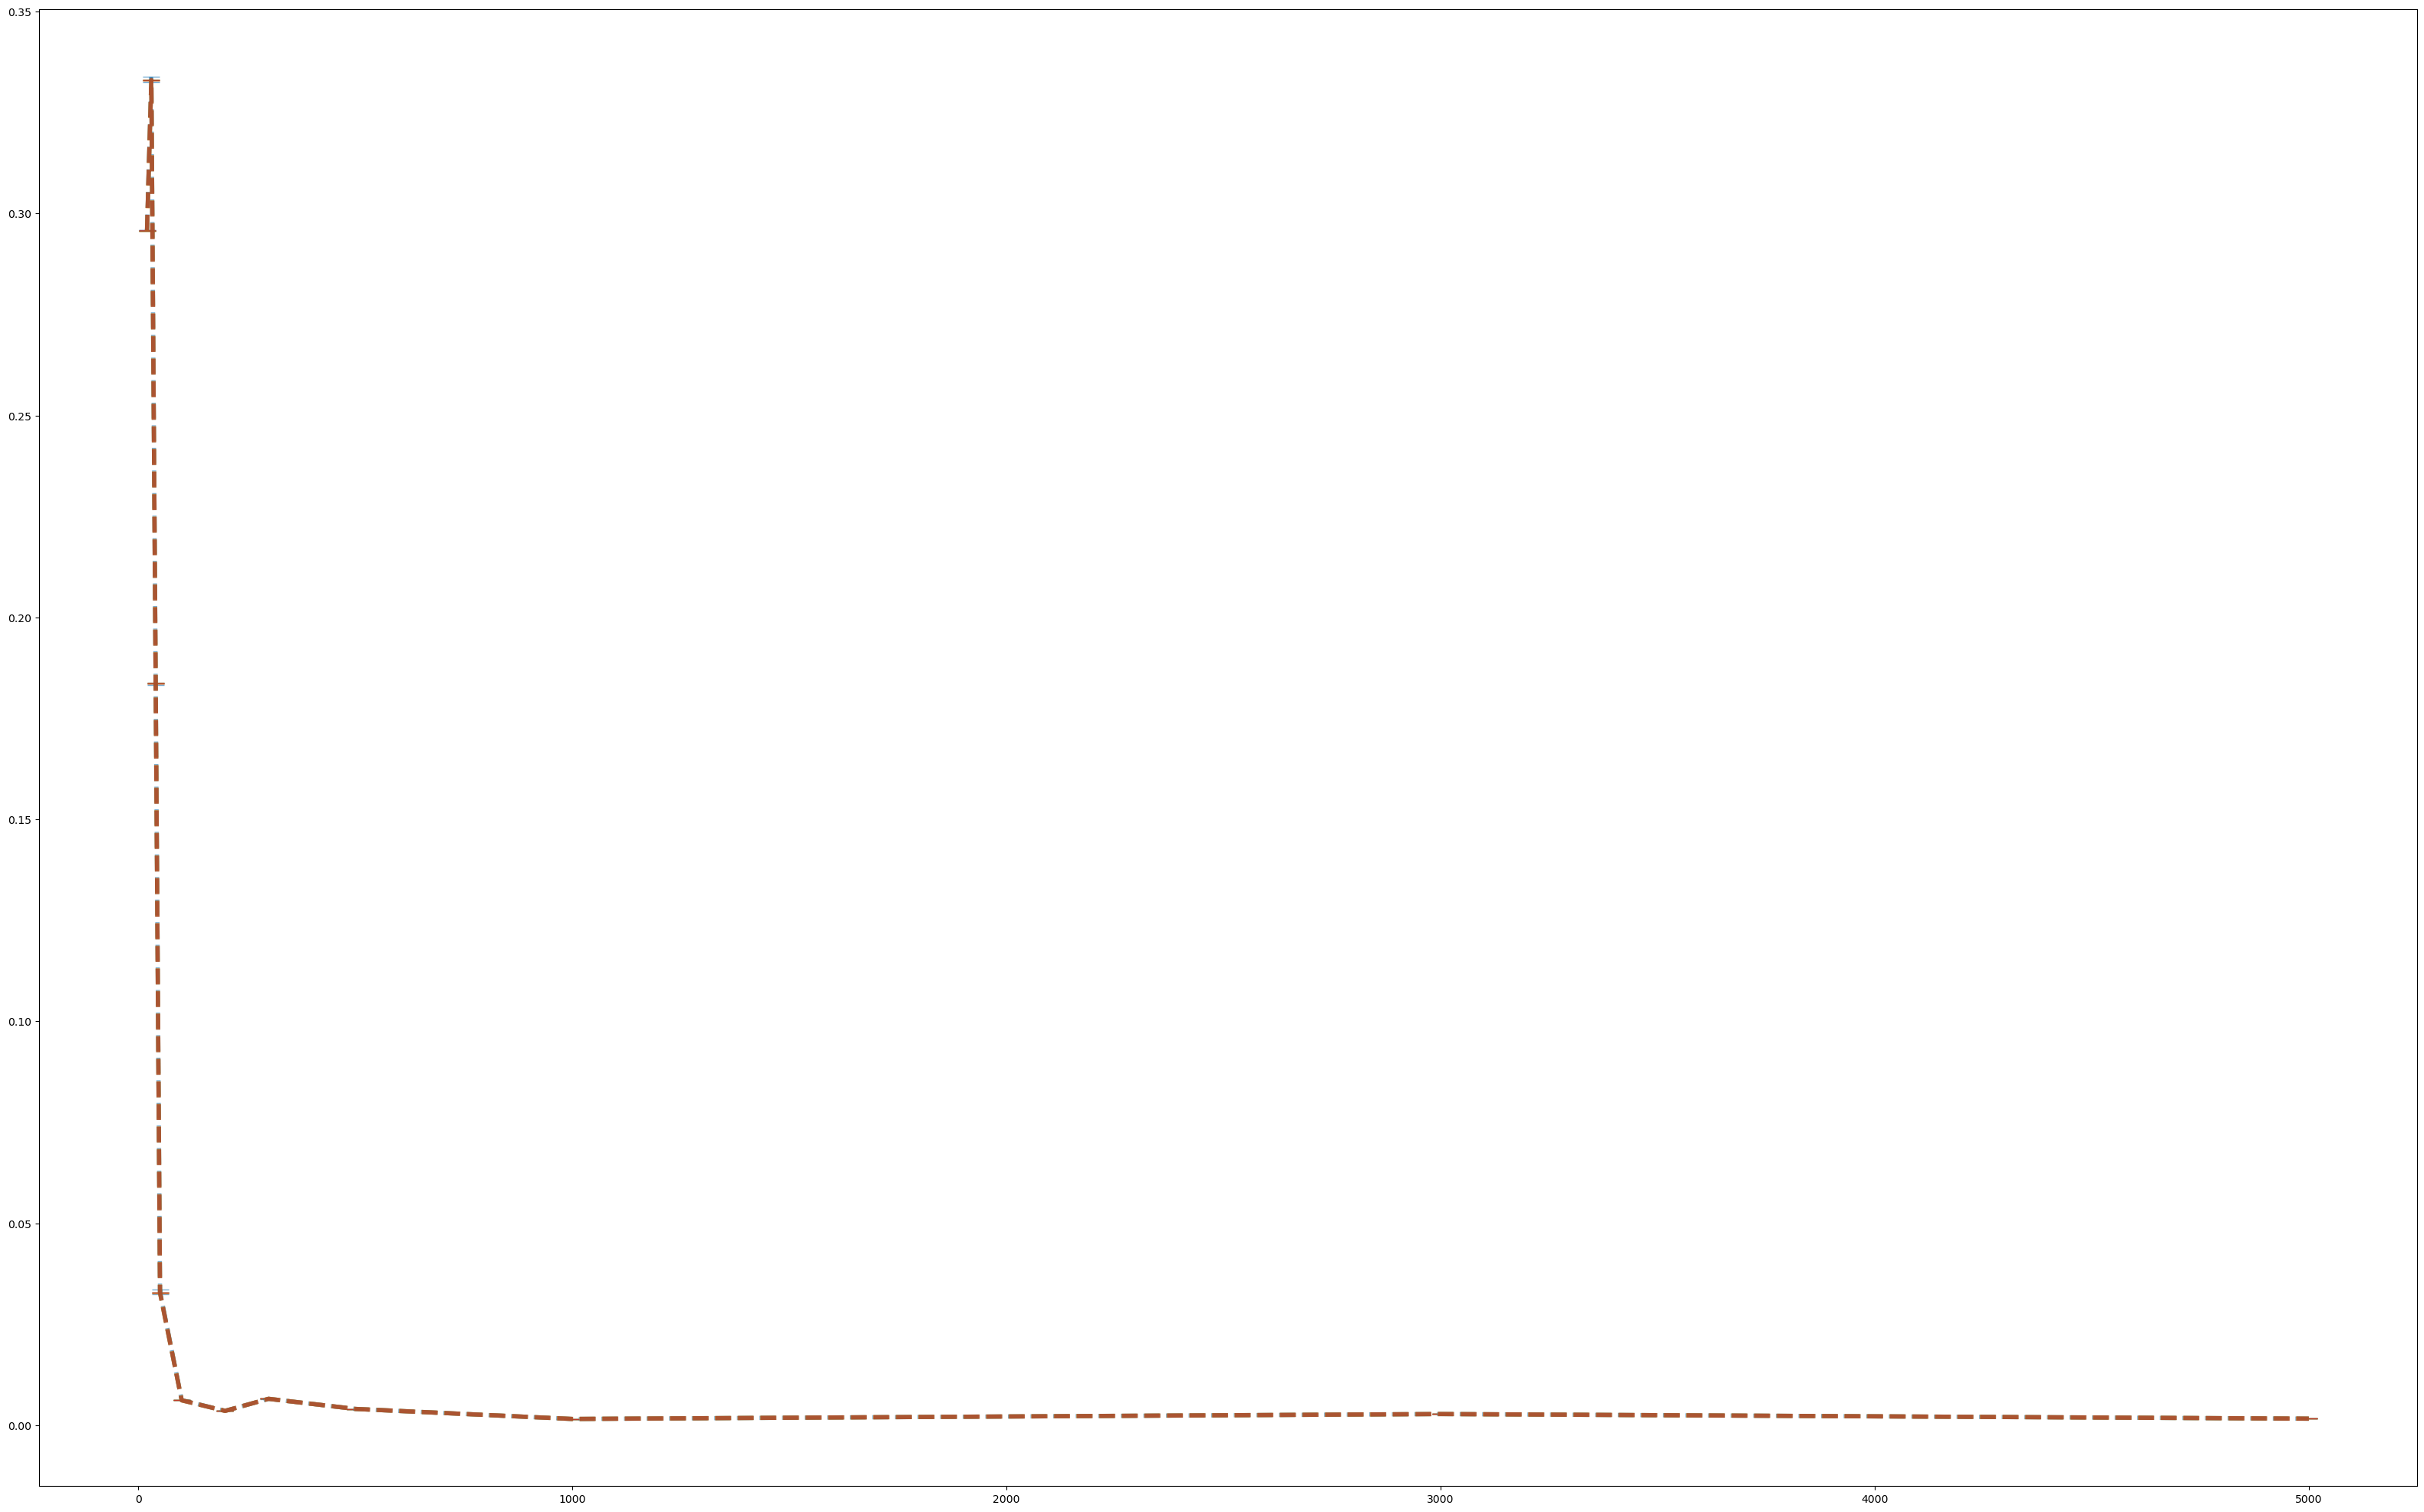

In [45]:
fig, axs = plt.subplots(1, figsize=(40, 25), sharex=True)

for nres in results.keys():
    data = np.array(results[nres])
    mean, std = data.mean(axis=1), data.std(axis=1)
    # axs.scatter(Ns[:2], mean[:2],label=f"Marginal",linewidth=4,alpha=0.6)
    axs.errorbar(Ns, mean, yerr=std, fmt="--", capsize=8, label=f"Marginal$", linewidth=4,markersize=10,alpha=0.6)



In [41]:
results[100_000]

[[0.2957689354547548, 0.29576791817496384, 0.2957823808027293],
 [0.3330031417177255, 0.3330009688510803, 0.33299689001603616],
 [0.1836665371789361, 0.18367651509187913, 0.18363539331658765],
 [0.032855547847692554, 0.032841282116420616, 0.03284232321547401],
 [0.0062015716808990345, 0.006205495516704682, 0.006202548106179372],
 [0.00358130060437501, 0.0035815639444407715, 0.003582606712532881],
 [0.006575462772483025, 0.00657587278394837, 0.006576029558450008],
 [0.004068895500708611, 0.004069173520920306, 0.004069209528376696],
 [0.0015885782733891143, 0.0015887134649549607, 0.0015890361981401714],
 [0.0028069380225730274, 0.0028069046621647773, 0.002806896816139068],
 [0.0016635050555962444, 0.0016634429503456056, 0.00166358777690612]]

In [42]:
results[1_000]

[[0.29567939160909495, 0.29563686018874574, 0.29577844898340616],
 [0.33301013253867506, 0.3332092482242886, 0.3328639451479781],
 [0.18377544137203203, 0.18356245436121438, 0.18371935866821734],
 [0.0328206322704123, 0.03263950246173333, 0.03268369212418078],
 [0.006200503567208929, 0.0061957621276117125, 0.006182025882286842],
 [0.0035765920176467807, 0.003591296327942782, 0.003586778297309532],
 [0.006566937873943662, 0.006576374051890814, 0.00658147748772523],
 [0.004066734121990604, 0.0040696237769652375, 0.004069020562861137],
 [0.0015894531582311094, 0.0015880410269047763, 0.0015894008888790497],
 [0.0028057310785319627, 0.0028037569749743275, 0.0028061243104483117],
 [0.001661226888431211, 0.001665139208917801, 0.0016618790831937525]]

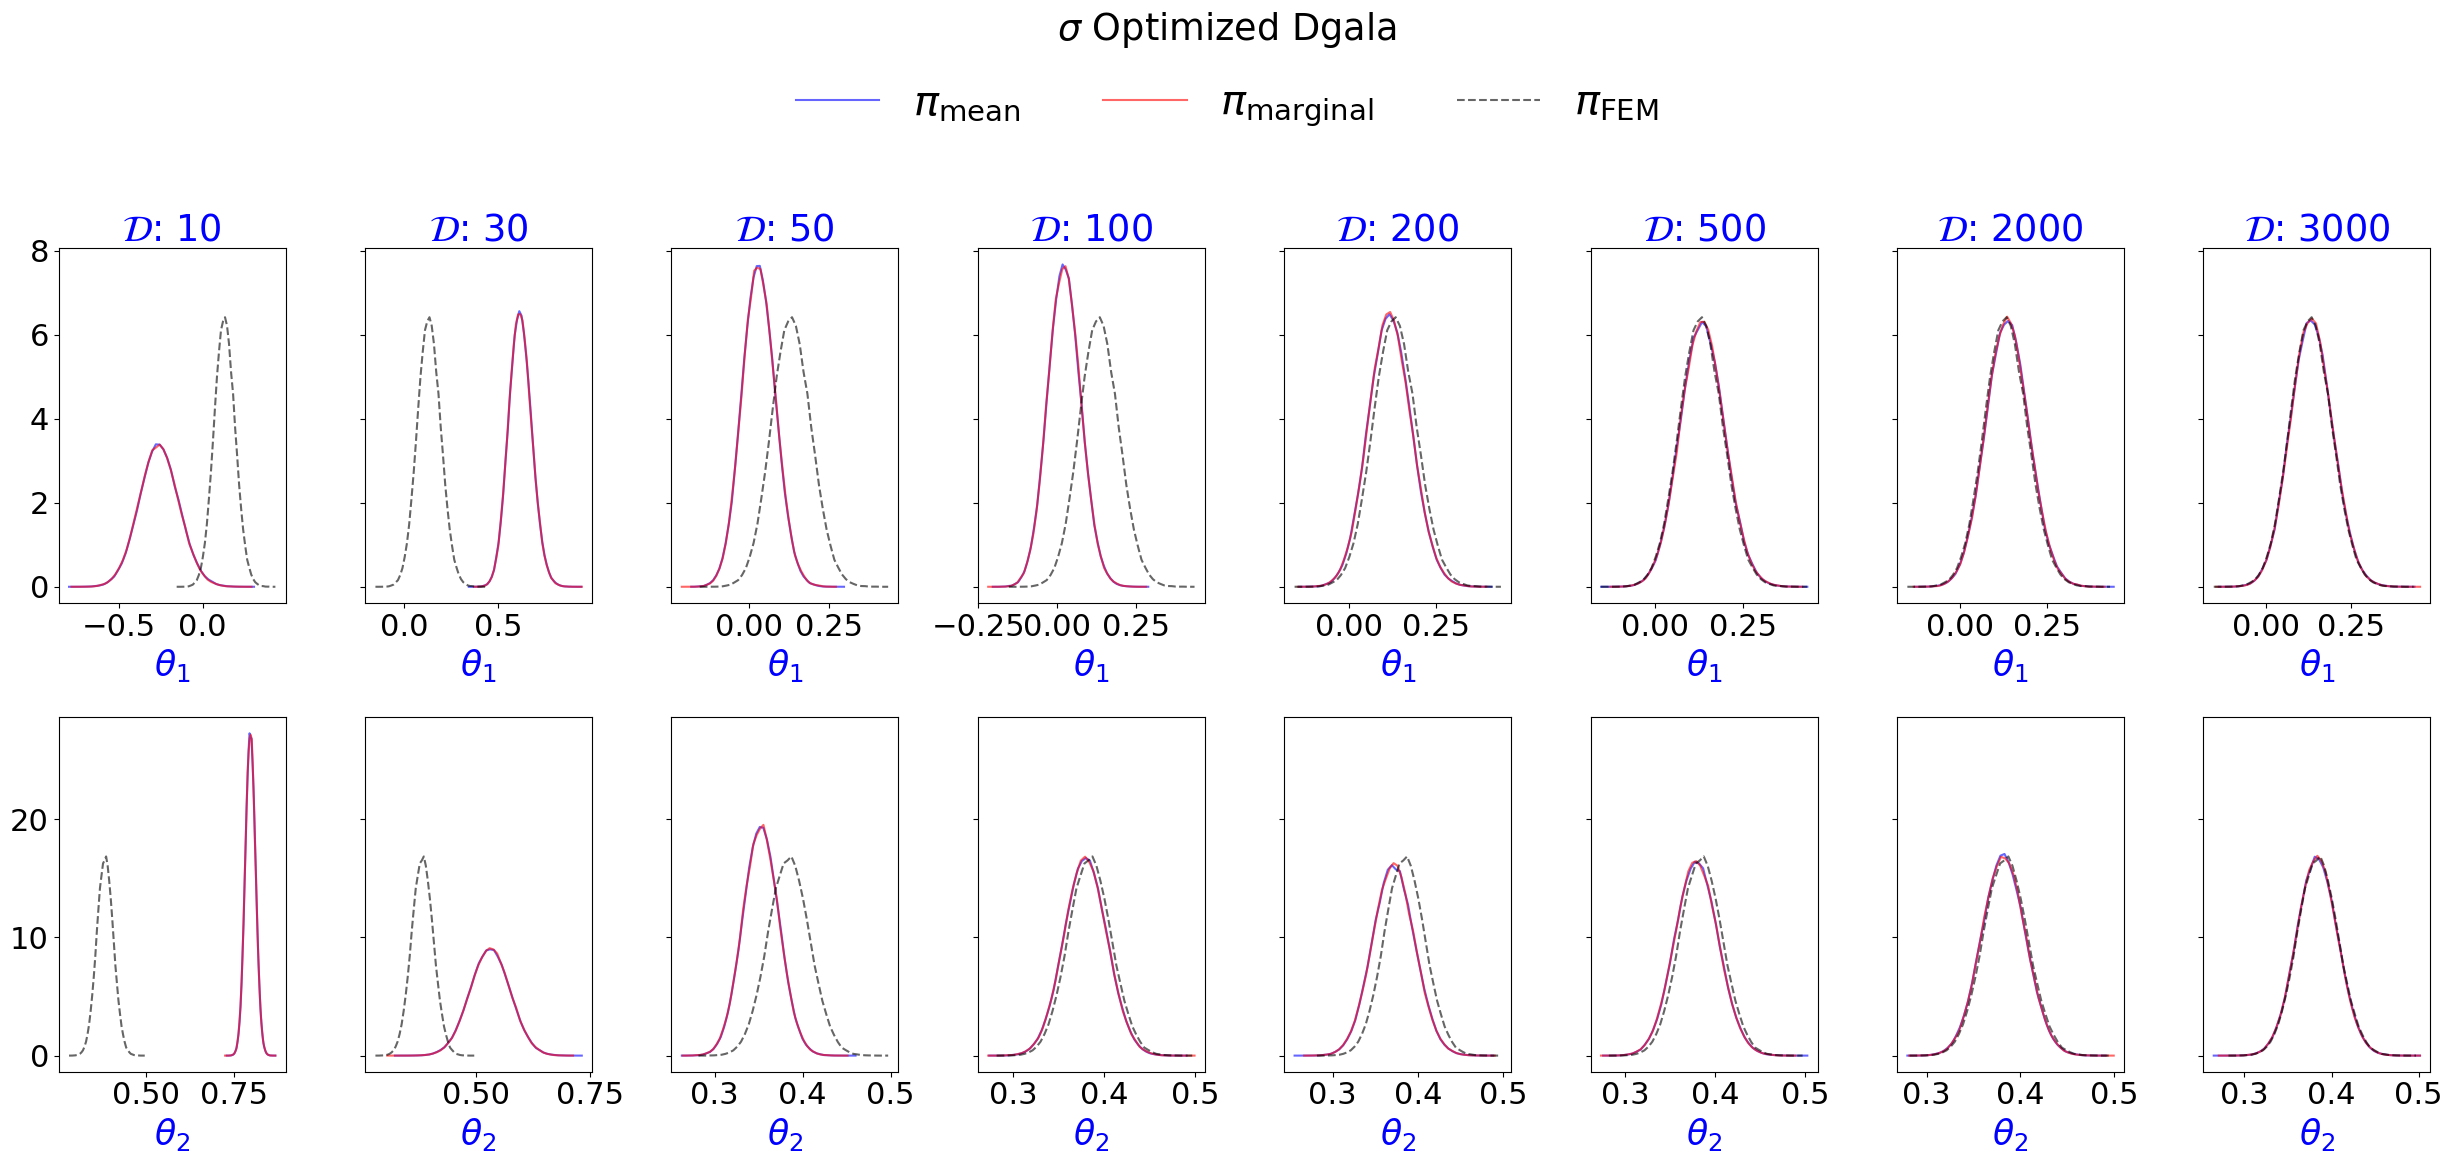

In [154]:

theta_th = np.array([0.098, 0.430, 0.206, 0.090, -0.153, 0.292])
# N = [10,20,30,50,100,200,500]
# batches = [10,10,10,10,100,100,100]
N = [10,30,50,100,200,500,2000,3000]
batches = [10,10,10,100,100,100,100,100]
bins = 50
kl = 2
nn = 20

fig, axs = plt.subplots(2,len(N), figsize=(25, 12), sharey="row")
fig.suptitle(f"$\sigma$ Optimized Dgala")
plt.rcParams.update({'font.size': 22})
ylims = []

for i,(nobs,batch) in  enumerate(zip(N,batches)):

    sample = np.load(f'./results/dgala_mcmc_mean_hl{2}_hd{nn}_s{nobs}_b{batch}_kl{kl}_0.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{mean}}$",color = "blue")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{mean}}$",color = "blue")

    sample = np.load(f'./results/dgala_mcmc_marginal_hl{2}_hd{nn}_s{nobs}_b{batch}_kl{kl}_0.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label =r"$\pi_{\text{marginal}}$",color = "red")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{marginal}}$",color = "red")
    
    sample = np.load(f'./results/FEM_mcmc_kl{kl}_0.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0,i].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=1.5, label = r"$\pi_{\text{FEM}}$",color = "black")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1,i].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=1.5, label = r"$\pi_{\text{FEM}}$",color = "black")
    
    axs[0,i].set_xlabel("$\\theta_{1}$",color="blue",fontsize = 25),axs[1,i].set_xlabel("$\\theta_{2}$",color="blue",fontsize = 25)
    axs[0,i].set_title(f"$\mathcal{{D}}$: {nobs}", color ="blue")
    
    axs[0,i].tick_params(axis='both', labelsize=22)
    axs[1,i].tick_params(axis='both', labelsize=22)

plt.tight_layout(rect=[0, 0, 1, 0.90])  # leave space for both title and legend

# --- ADD HORIZONTAL LEGEND ON TOP ---
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels,loc="upper center", ncol=3, fontsize=30, frameon=False, bbox_to_anchor=(0.5, 0.95))

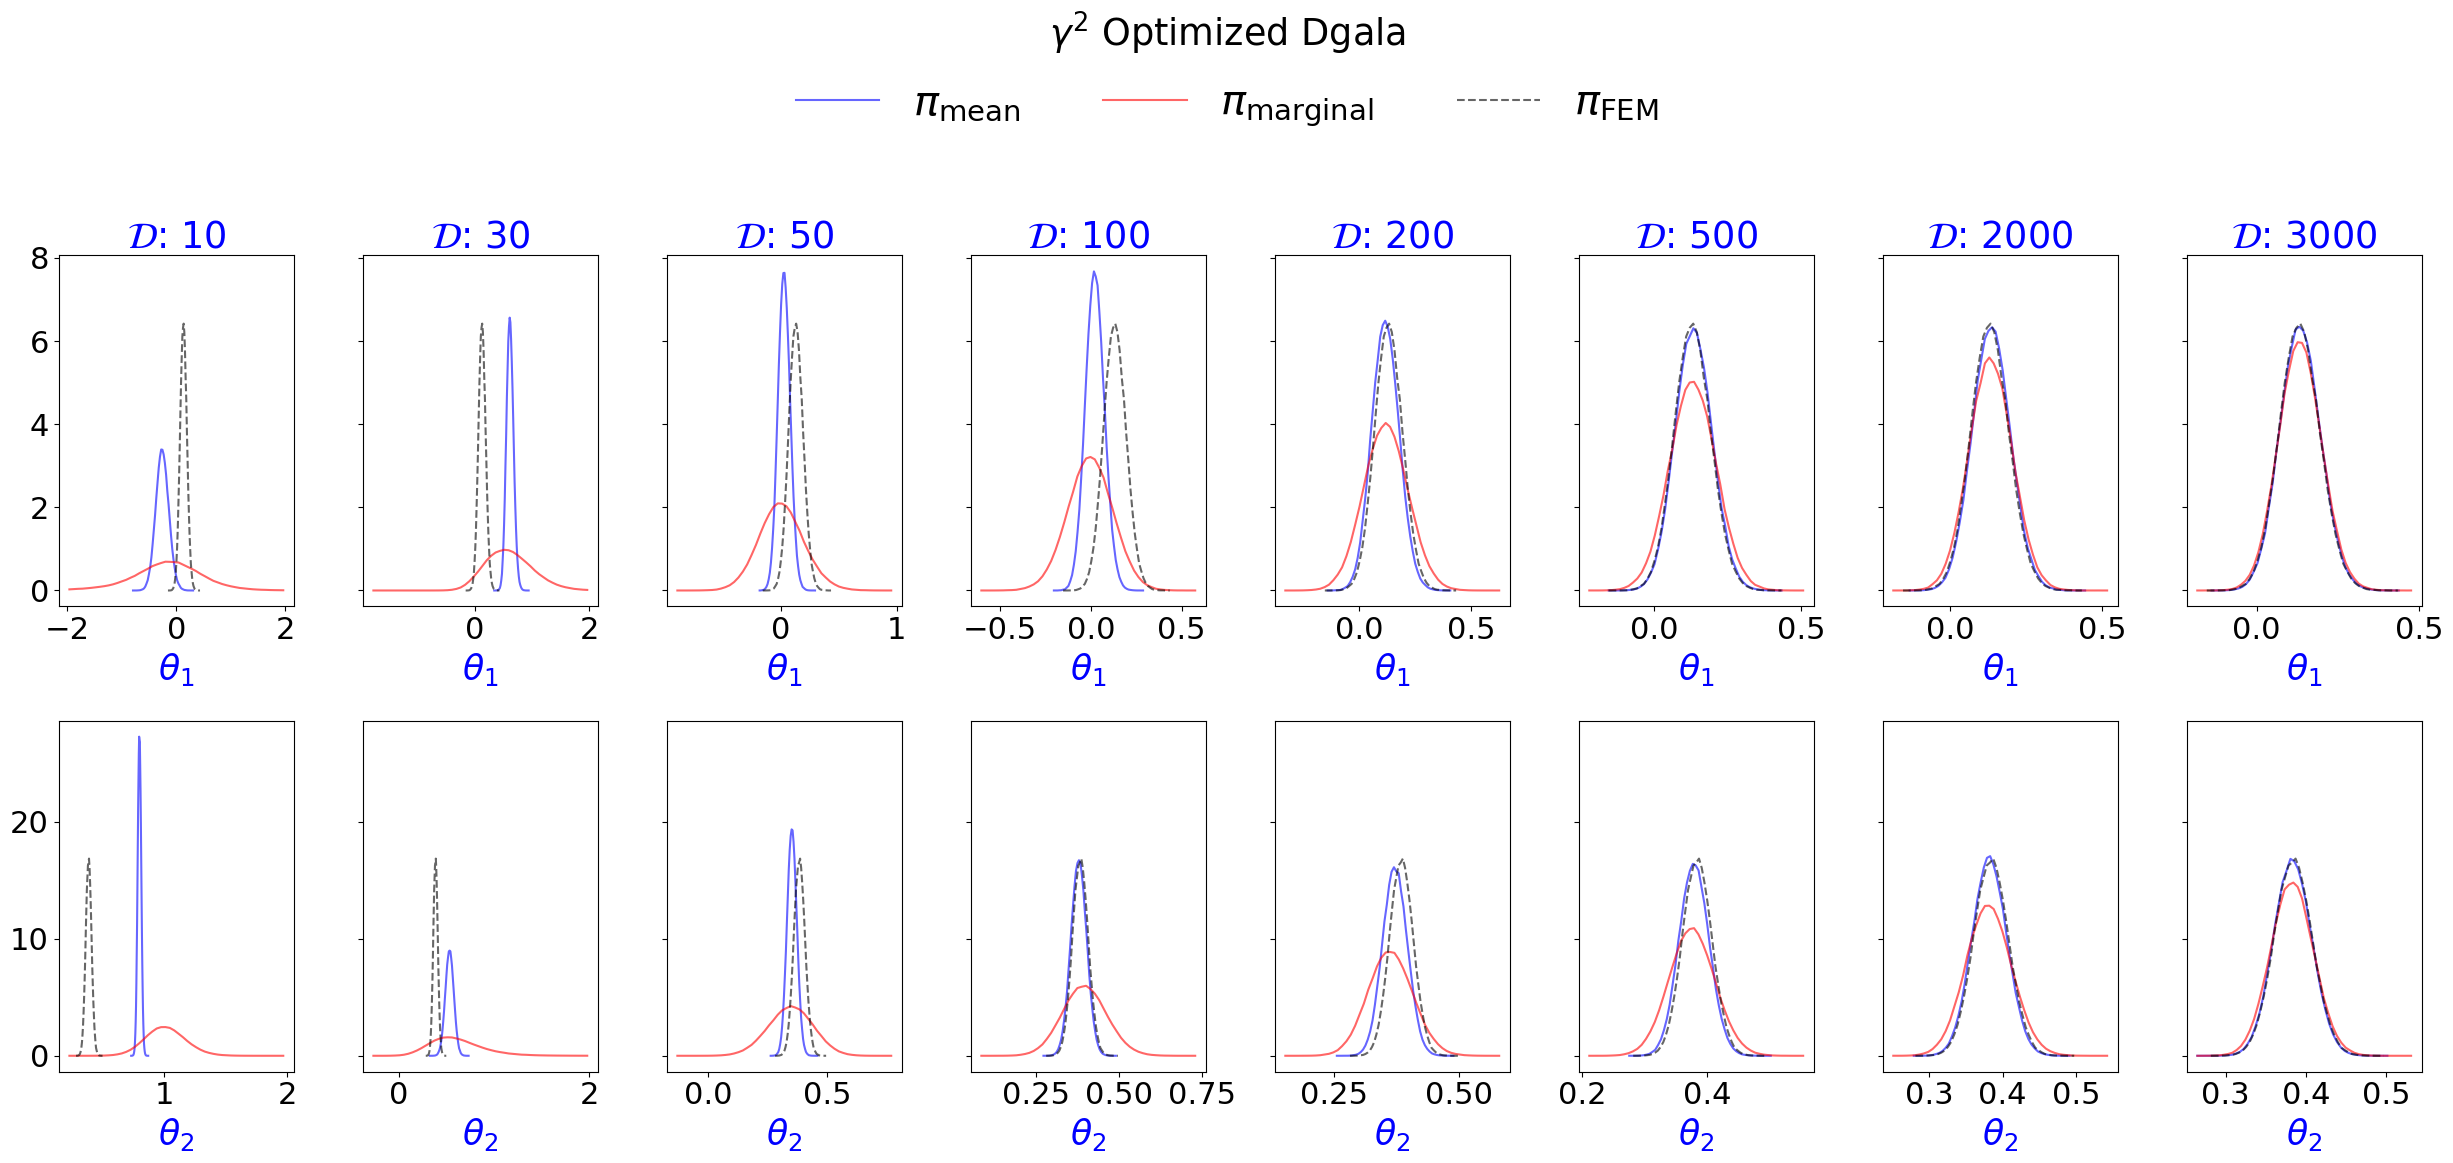

In [152]:
vr = 1e-4
theta_th = np.array([0.098, 0.430, 0.206, 0.090, -0.153, 0.292])
# N = [10,20,30,50,100,200,500]
# batches = [10,10,10,10,100,100,100]
N = [10,30,50,100,200,500,2000,3000]
batches = [10,10,10,100,100,100,100,100]
bins = 50
kl = 2
nn = 20

fig, axs = plt.subplots(2,len(N), figsize=(25, 12), sharey="row")
fig.suptitle(f"$\gamma^{2}$ Optimized Dgala")
plt.rcParams.update({'font.size': 22})
ylims = []

for i,(nobs,batch) in  enumerate(zip(N,batches)):

    sample = np.load(f'./results/dgala_mcmc_mean_hl{2}_hd{nn}_s{nobs}_b{batch}_kl{kl}_0.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{mean}}$",color = "blue")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{mean}}$",color = "blue")

    sample = np.load(f'./results/dgala_mcmc_marginal_hl{2}_hd{nn}_s{nobs}_b{batch}_kl{kl}_0.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label =r"$\pi_{\text{marginal}}$",color = "red")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{marginal}}$",color = "red")
    
    sample = np.load(f'./results/FEM_mcmc_kl{kl}_0.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0,i].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=1.5, label = r"$\pi_{\text{FEM}}$",color = "black")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1,i].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=1.5, label = r"$\pi_{\text{FEM}}$",color = "black")
    
    axs[0,i].set_xlabel("$\\theta_{1}$",color="blue",fontsize = 25),axs[1,i].set_xlabel("$\\theta_{2}$",color="blue",fontsize = 25)
    axs[0,i].set_title(f"$\mathcal{{D}}$: {nobs}", color ="blue")
    
    axs[0,i].tick_params(axis='both', labelsize=22)
    axs[1,i].tick_params(axis='both', labelsize=22)

plt.tight_layout(rect=[0, 0, 1, 0.90])  # leave space for both title and legend

# --- ADD HORIZONTAL LEGEND ON TOP ---
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels,loc="upper center", ncol=3, fontsize=30, frameon=False, bbox_to_anchor=(0.5, 0.95))
#plt.savefig(f"./results/images/bvp1d_gp_marginal_convergence.pdf", bbox_inches='tight') 

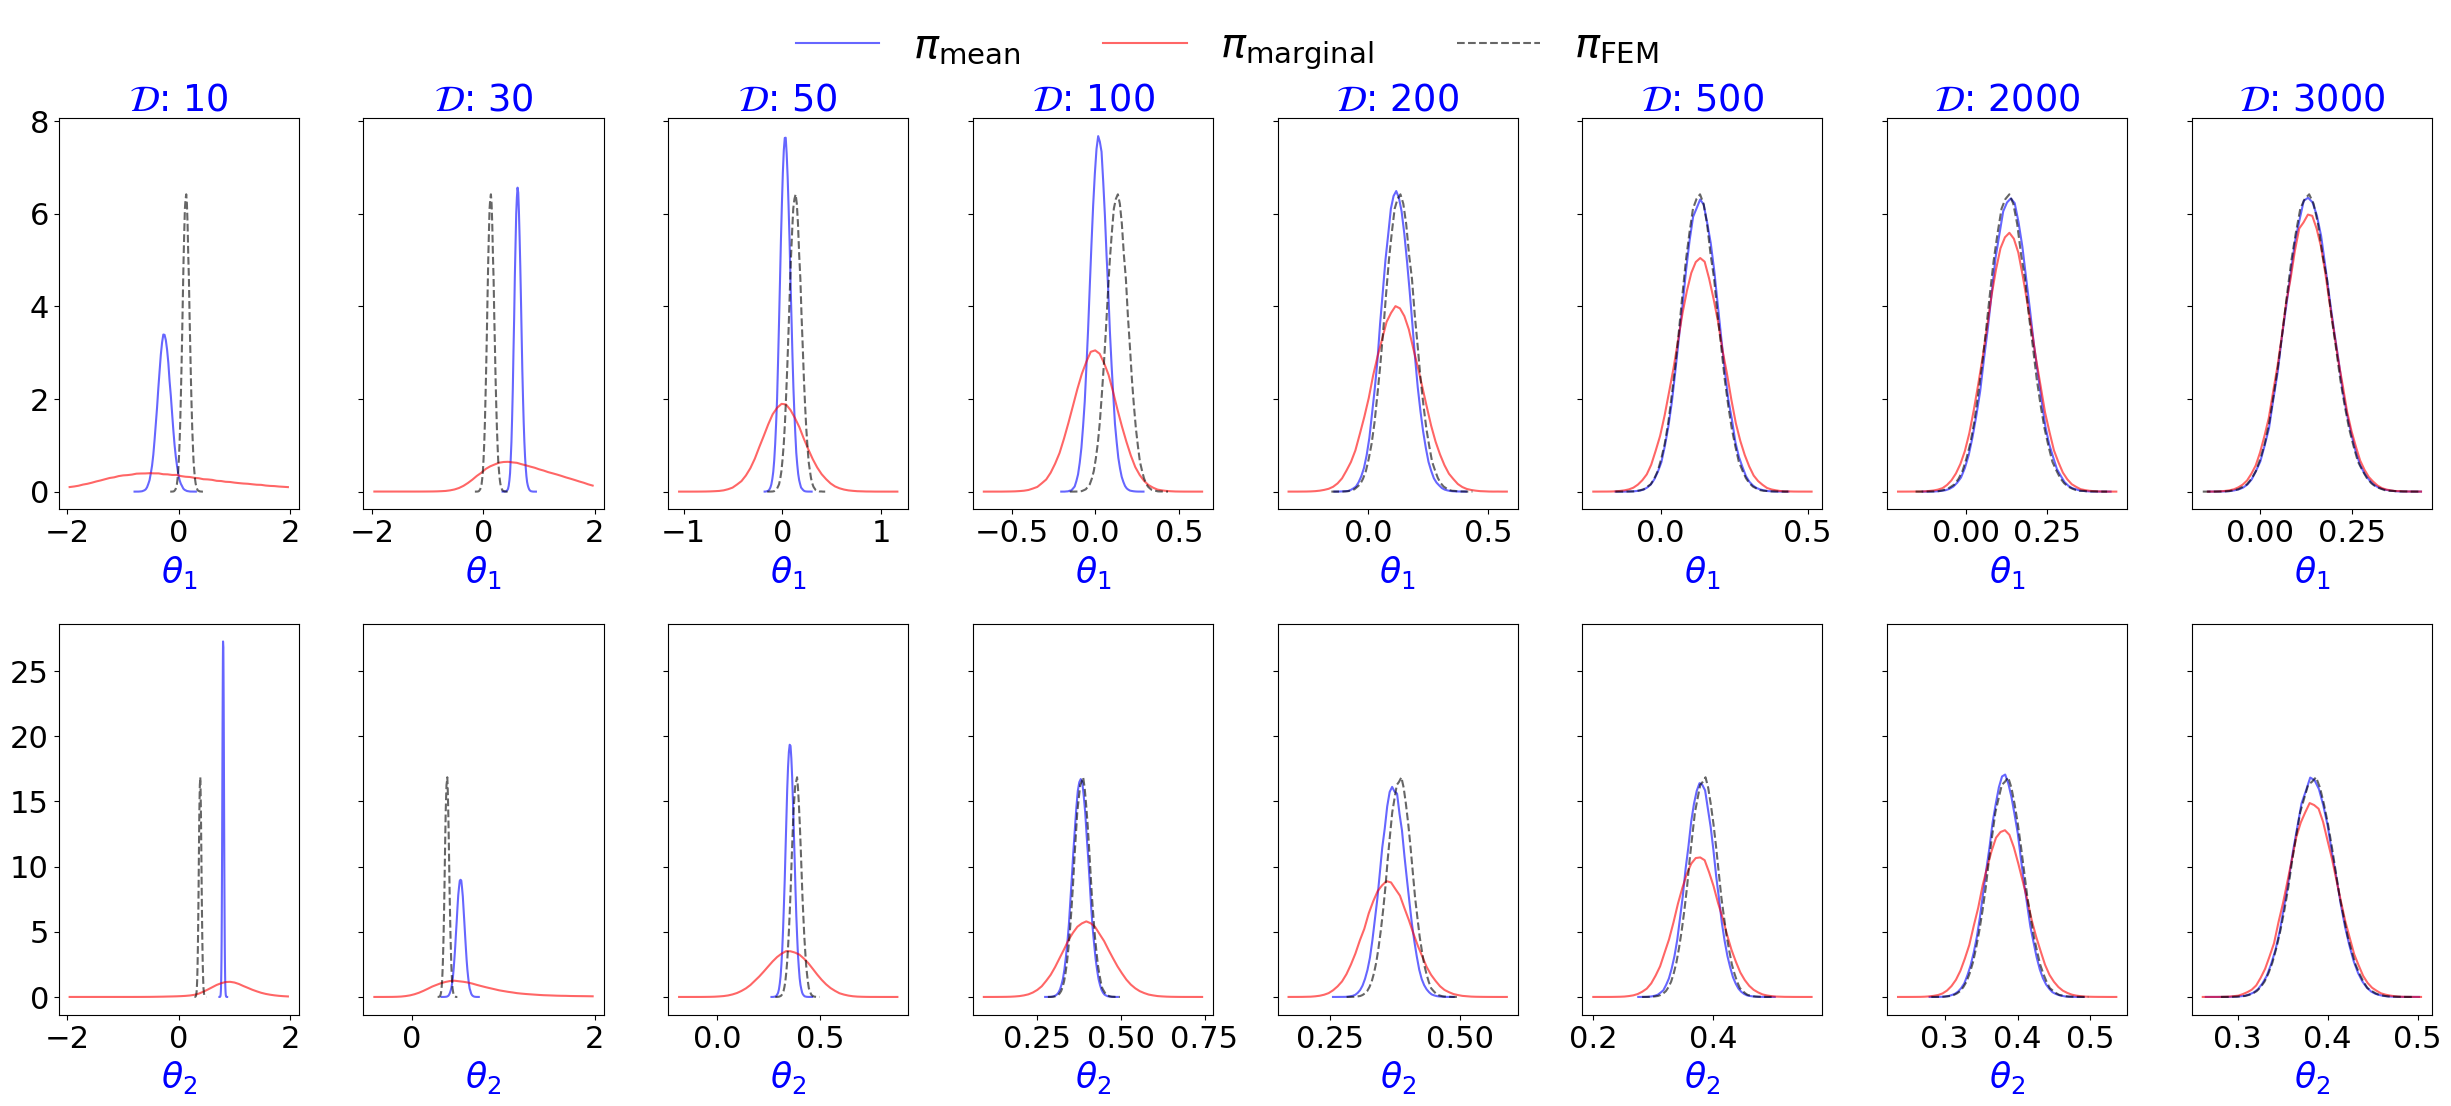

In [16]:
vr = 1e-4
theta_th = np.array([0.098, 0.430, 0.206, 0.090, -0.153, 0.292])
# N = [10,20,30,50,100,200,500]
# batches = [10,10,10,10,100,100,100]
N = [10,30,50,100,200,500,2000,3000]
batches = [10,10,10,100,100,100,100,100]
bins = 50
kl = 2
nn = 20

fig, axs = plt.subplots(2,len(N), figsize=(25, 12), sharey="row")
#fig.suptitle(f"Posterior Distributions")
plt.rcParams.update({'font.size': 22})
ylims = []

for i,(nobs,batch) in  enumerate(zip(N,batches)):

    sample = np.load(f'./results/dgala_mcmc_mean_hl{2}_hd{nn}_s{nobs}_b{batch}_kl{kl}_0.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{mean}}$",color = "blue")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{mean}}$",color = "blue")

    sample = np.load(f'./results/dgala_mcmc_marginal_hl{2}_hd{nn}_s{nobs}_b{batch}_kl{kl}_0.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label =r"$\pi_{\text{marginal}}$",color = "red")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{marginal}}$",color = "red")
    
    sample = np.load(f'./results/FEM_mcmc_kl{kl}_0.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0,i].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=1.5, label = r"$\pi_{\text{FEM}}$",color = "black")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1,i].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=1.5, label = r"$\pi_{\text{FEM}}$",color = "black")
    
    axs[0,i].set_xlabel("$\\theta_{1}$",color="blue",fontsize = 25),axs[1,i].set_xlabel("$\\theta_{2}$",color="blue",fontsize = 25)
    axs[0,i].set_title(f"$\mathcal{{D}}$: {nobs}", color ="blue")

    # if i==0:
    #     axs[0,0].set_xlim((-0.8,0.5))
    #     axs[1,0].set_xlim((0.2,1))
    # elif i==1:
    #     axs[0,1].set_xlim((-.2,1))
    #     axs[1,1].set_xlim((0.2,0.75))
    # elif i==2:
    #     axs[0,2].set_xlim((-.2,0.45))
    #     axs[1,2].set_xlim((0.25,0.5))
    # else:
    # axs[0,i].set_xlim((-1,1))
    # axs[1,i].set_xlim((-1,1))
    
    axs[0,i].tick_params(axis='both', labelsize=22)
    axs[1,i].tick_params(axis='both', labelsize=22)

plt.tight_layout(rect=[0, 0, 1, 0.90])  # leave space for both title and legend

# --- ADD HORIZONTAL LEGEND ON TOP ---
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels,loc="upper center", ncol=3, fontsize=30, frameon=False, bbox_to_anchor=(0.5, 0.95))
#plt.savefig(f"./results/images/bvp1d_gp_marginal_convergence.pdf", bbox_inches='tight') 

In [54]:
# N = [30,50,100,200,500,2000,3000]
# batches = [10,10,100,100,100,100,100]

N = [100,200,500,2000,3000]
batches = [100,100,100,100,100]

npoints = 100
results = torch.zeros((npoints, npoints, len(N)))
sigma_limits = [(1e-2,0.1), (1e-2,0.2), (1e-2,.05),(4e-3,0.05), (4e-3,0.05)]

for z, (n, bc) in enumerate(zip(N, batches)):
    llp = torch.load(f"./models/dgala_marginal_hl2_hd20_s{n}_b{bc}_kl2.pth")
    llp.model.set_last_layer("output_layer")  # Re-register hooks

    # Define scan ranges
    sn = torch.linspace(sigma_limits[z][0], sigma_limits[z][1], 100)          # sigma_noise
    priorpre = torch.linspace(10, 1000, npoints)      # prior_precision

    # Create meshgrid
    SN, PP = torch.meshgrid(sn, priorpre, indexing="ij")

    # Allocate result grid: [n_sn, n_pp]
    log_marg_grid = torch.zeros(npoints, npoints)

    # Evaluate log-marginal likelihood on the 2D grid
    for i in range(npoints):
        for j in range(npoints):
            llp.sigma_noise = SN[i, j].item()
            llp.prior_precision = [PP[i, j].item()]
            log_marg_grid[i, j] = llp.log_marginal_likelihood()

    # Store into results tensor
    results[:, :, z] = log_marg_grid.detach()

In [81]:
N = [100,200,500,2000,3000]
batches = [100,100,100,100,100]

for z, (n, bc) in enumerate(zip(N, batches)):
    data_fit = deepgala_data_fit(n,2,device)

    nn = torch.load(f"./models/dgala_marginal_hl2_hd20_s{n}_b{bc}_kl2.pth")
    print(nn.mean.shape[0] / (torch.linalg.norm(nn.mean,ord=2)**2 + torch.trace(nn.posterior_covariance)))
    # u_bcl = (nn.u(data_fit["data_fit"]["left_bc"]))**2
    # u_bcr = (nn.u(data_fit["data_fit"]["right_bc"])-2)**2
    # pde = (nn.elliptic_pde(data_fit["data_fit"]["pde"]))**2

    # loss = pde*nn.lambdas["elliptic"] + u_bcl*nn.lambdas["ubcl"] + u_bcr*nn.lambdas["ubcr"]
    # print(loss.log().std().item())

tensor(35.3348)
tensor(35.4253)
tensor(36.3825)
tensor(42.4517)
tensor(48.6437)


In [72]:
((-1)*nn.log_likelihood + nn.sigma_noise*torch.trace(nn.posterior_covariance@nn.H))/3000

tensor(2.7645)

tensor(47.9929)

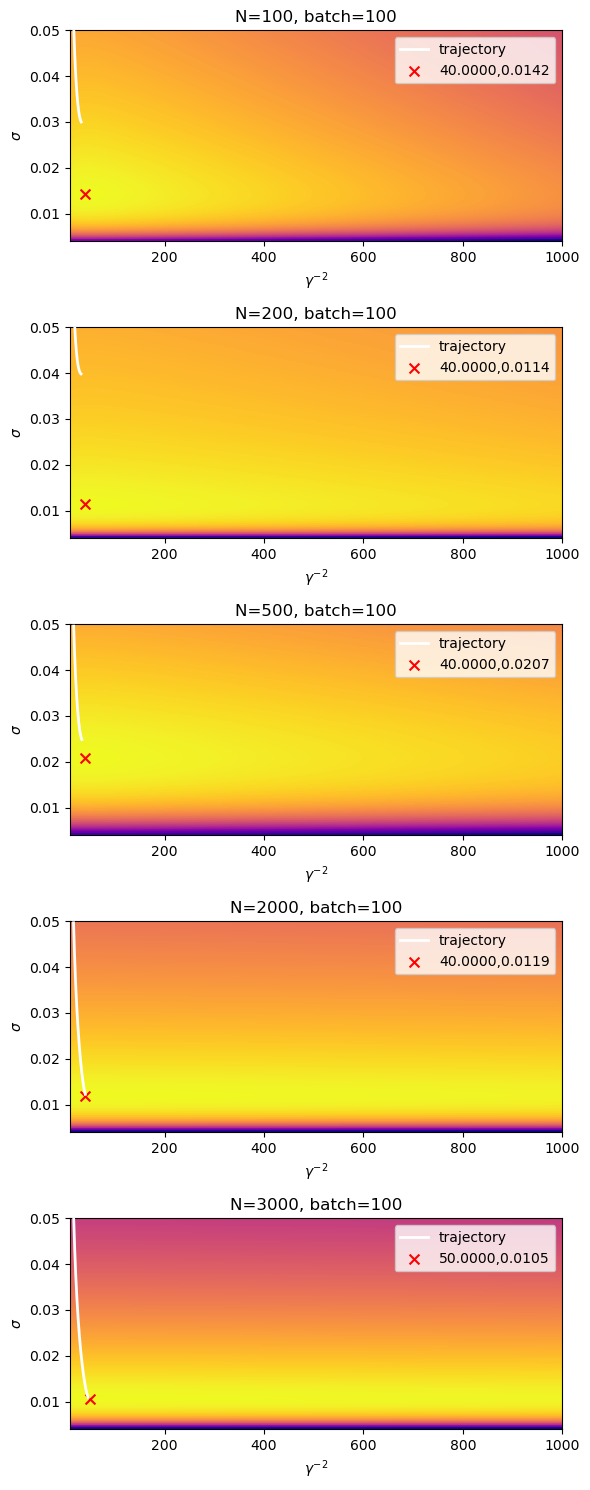

In [55]:
fig, axs = plt.subplots(len(N), 1, figsize=(6, 15))
plt.rcParams.update({'font.size': 10})

for i, (nobs, batch) in enumerate(zip(N, batches)):

    llp = torch.load(f"./models/dgala_marginal_hl2_hd20_s{nobs}_b{batch}_kl2.pth")
    llp.model.set_last_layer("output_layer")

    sigma_trace = np.load(f"./models/sigma_trace_{nobs}.npy")
    prior_trace = np.load(f"./models/prior_trace_{nobs}.npy")

    # Heatmap domain (convert to Python floats)
    prior_min = priorpre.min().item()
    prior_max = priorpre.max().item()
    sigma_min = sn.min().item()
    sigma_max = sn.max().item()

    # Mask points inside heatmap box
    mask = (
        (prior_trace >= prior_min) &
        (prior_trace <= prior_max) &
        (sigma_trace >= sigma_min) &
        (sigma_trace <= sigma_max)
    )

    # Filtered trajectory
    prior_plot = prior_trace[mask]
    sigma_plot = sigma_trace[mask]

    # Use full grid (recommended)
    log_marg_grid = results[:, :, i]

    # Find max
    max_idx = torch.argmax(log_marg_grid)
    imax, jmax = divmod(max_idx.item(), log_marg_grid.shape[1])

    sigma_max = sn[imax].item()
    prior_max = priorpre[jmax].item()

    plot = axs[i].imshow(
        log_marg_grid.detach().numpy(),
        extent=[priorpre.min(), priorpre.max(), sn.min(), sn.max()],
        origin="lower",
        aspect="auto",cmap="plasma"
    )
    #plt.colorbar(=plot)

    axs[i].plot(prior_plot, sigma_plot, color="white", lw=2, label="trajectory", zorder=5)

    axs[i].scatter(prior_max, sigma_max, color="red", s=50, marker="x",
                   label=f"{prior_max:.4f},{sigma_max:.4f}")
    axs[i].set_xlabel("$\\gamma^{-2}$")
    axs[i].set_ylabel("$\\sigma$") 
    axs[i].set_title(f"N={nobs}, batch={batch}")

    axs[i].legend()

plt.tight_layout()

In [178]:
llp = torch.load(f"./models/dgala_marginal_hl2_hd20_s{100}_b{100}_kl2.pth")
llp.model.set_last_layer("output_layer")

llp.H

tensor([[ 1.9536e+04, -2.3033e+04, -1.4806e+04, -2.3957e+02, -1.5318e+04,
          1.7381e+04,  8.8469e+03, -3.5609e+03, -1.6876e+04,  6.2631e+02,
         -2.6222e+03, -2.4559e+03, -1.5306e+04, -2.4700e+03,  4.1708e+03,
         -1.4469e+03, -2.9262e+03,  5.8999e+03, -4.0924e+03,  1.0411e+04,
          8.2986e+03, -7.3083e+03, -1.2006e+03],
        [-2.3033e+04,  5.9479e+04,  1.4959e+04,  5.0485e+03,  1.9962e+04,
         -2.0267e+04, -3.7366e+03,  5.2071e+03,  2.3575e+04, -8.3297e+02,
          7.1001e+03,  8.8483e+03,  1.6692e+04, -9.9563e+02,  2.0290e+03,
          3.0680e+03,  4.9833e+02, -8.4561e+03, -5.8705e+03, -1.1716e+04,
         -7.8277e+03,  6.8852e+03,  1.3218e+03],
        [-1.4806e+04,  1.4959e+04,  3.0178e+04,  4.0677e+03,  1.0375e+04,
         -2.1440e+04, -2.7550e+03, -2.6459e+02,  1.1356e+04, -3.0663e+03,
          4.9121e+02, -1.2537e+03,  1.0925e+04, -6.4336e+03, -6.8470e+02,
          8.3852e+01, -1.1082e+04, -5.3682e+03, -1.1406e+04,  9.3347e+03,
         -8.10

# Bad Optimizer

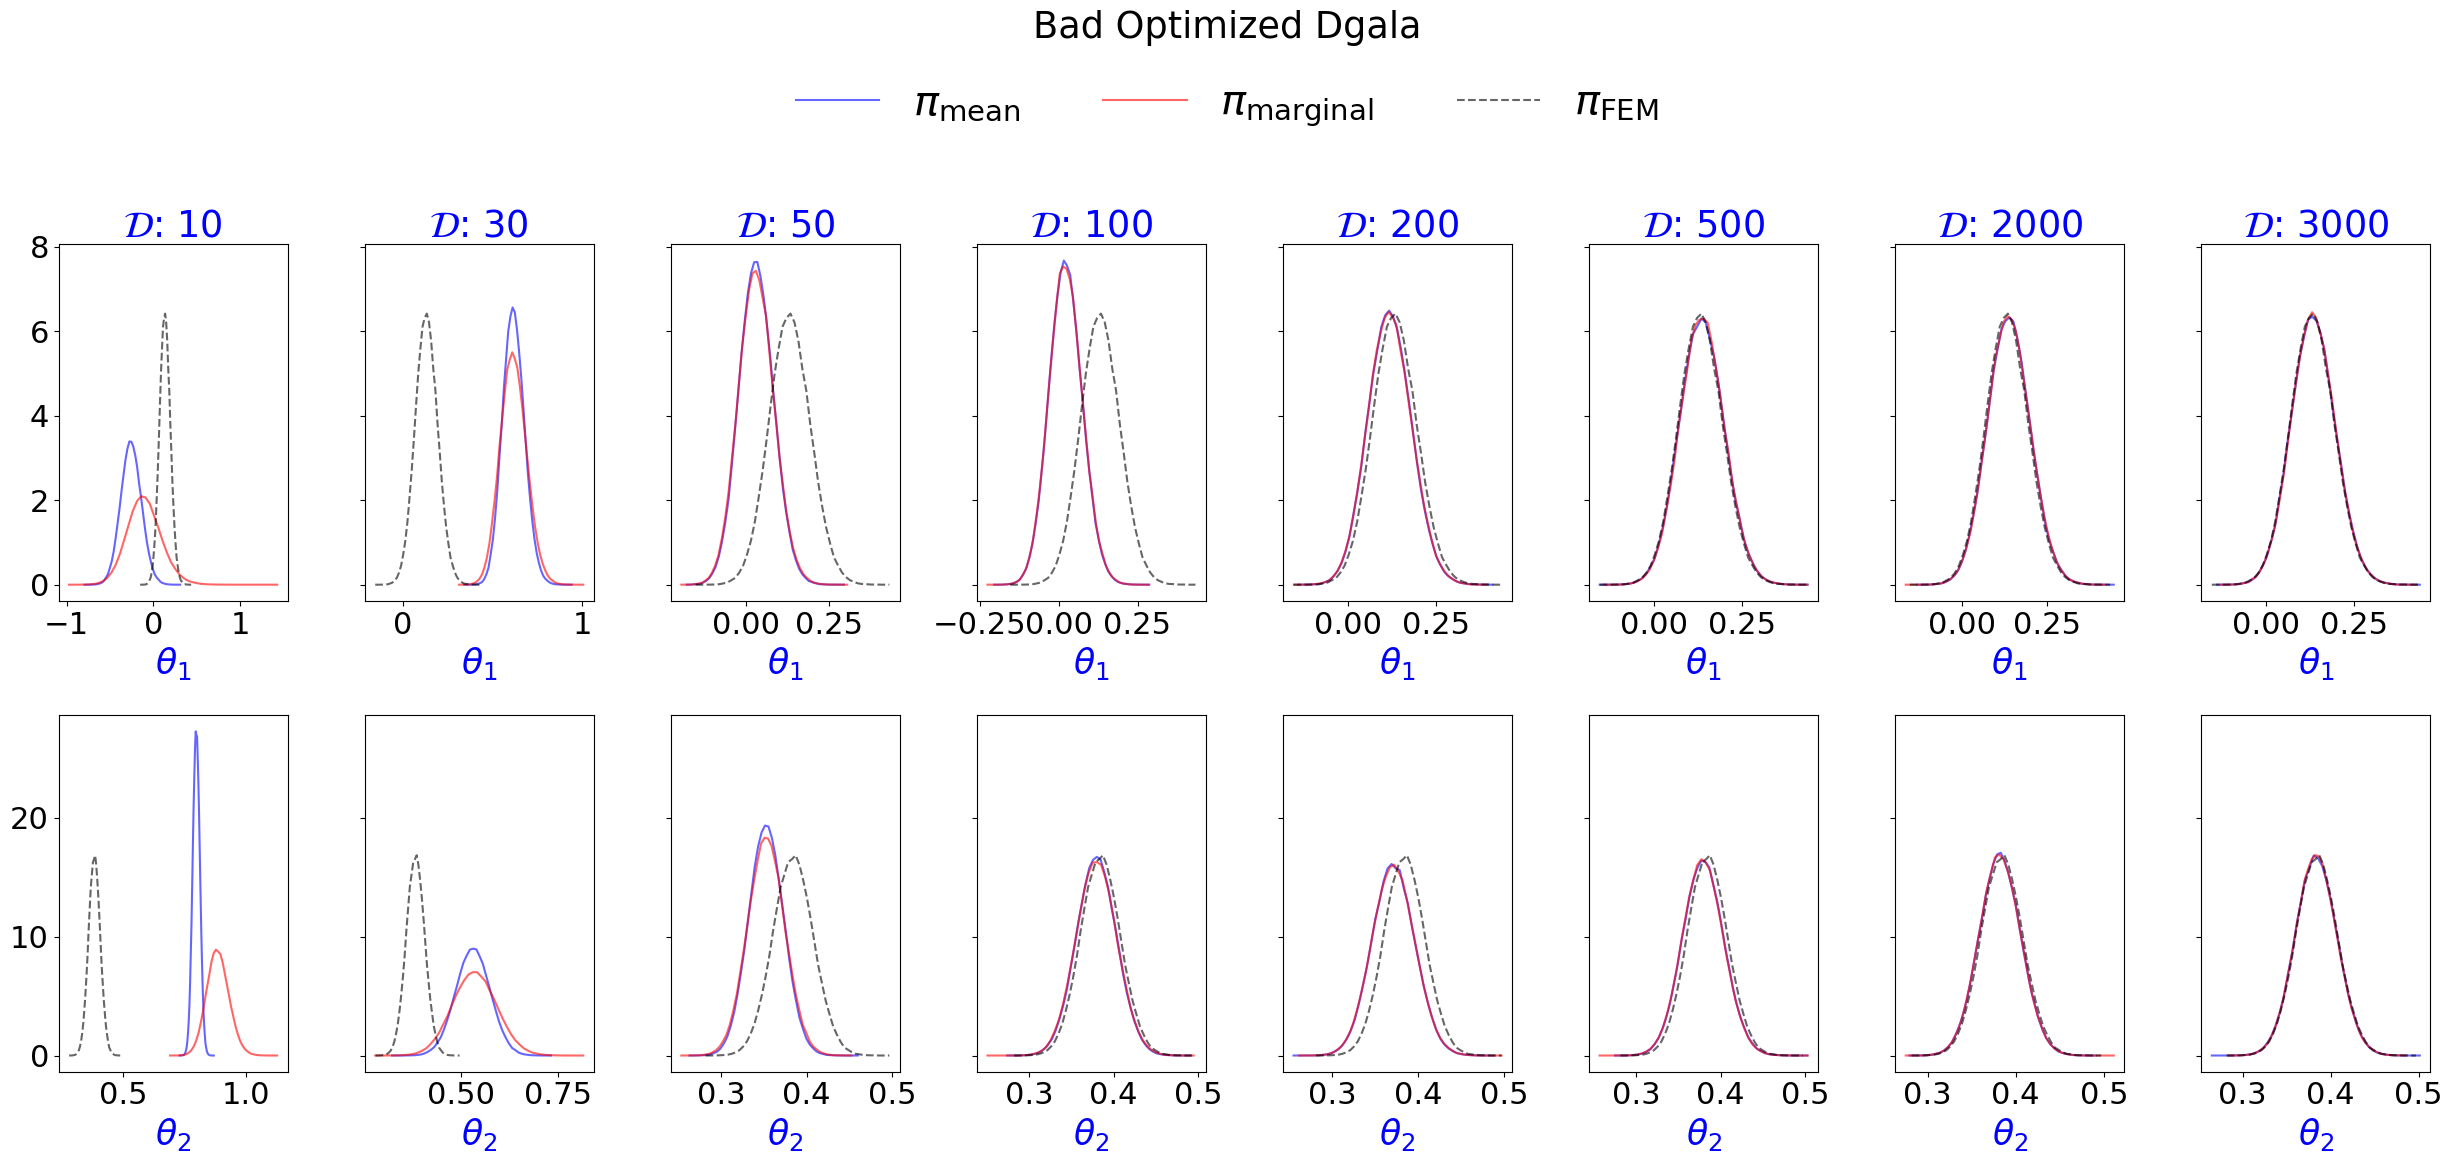

In [162]:
vr = 1e-4
theta_th = np.array([0.098, 0.430, 0.206, 0.090, -0.153, 0.292])
# N = [10,20,30,50,100,200,500]
# batches = [10,10,10,10,100,100,100]
N = [10,30,50,100,200,500,2000,3000]
batches = [10,10,10,100,100,100,100,100]
bins = 50
kl = 2
nn = 20

fig, axs = plt.subplots(2,len(N), figsize=(25, 12), sharey="row")
fig.suptitle(f"Bad Optimized Dgala")
plt.rcParams.update({'font.size': 22})
ylims = []

for i,(nobs,batch) in  enumerate(zip(N,batches)):

    sample = np.load(f'./results/dgala_mcmc_mean_hl{2}_hd{nn}_s{nobs}_b{batch}_kl{kl}_0.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{mean}}$",color = "blue")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{mean}}$",color = "blue")

    sample = np.load(f'./results/dgala_mcmc_marginal_hl{2}_hd{nn}_s{nobs}_b{batch}_kl{kl}_0.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label =r"$\pi_{\text{marginal}}$",color = "red")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{marginal}}$",color = "red")
    
    sample = np.load(f'./results/FEM_mcmc_kl{kl}_0.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0,i].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=1.5, label = r"$\pi_{\text{FEM}}$",color = "black")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1,i].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=1.5, label = r"$\pi_{\text{FEM}}$",color = "black")
    
    axs[0,i].set_xlabel("$\\theta_{1}$",color="blue",fontsize = 25),axs[1,i].set_xlabel("$\\theta_{2}$",color="blue",fontsize = 25)
    axs[0,i].set_title(f"$\mathcal{{D}}$: {nobs}", color ="blue")
    
    axs[0,i].tick_params(axis='both', labelsize=22)
    axs[1,i].tick_params(axis='both', labelsize=22)

plt.tight_layout(rect=[0, 0, 1, 0.90])  # leave space for both title and legend

# --- ADD HORIZONTAL LEGEND ON TOP ---
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels,loc="upper center", ncol=3, fontsize=30, frameon=False, bbox_to_anchor=(0.5, 0.95))
#plt.savefig(f"./results/images/bvp1d_gp_marginal_convergence.pdf", bbox_inches='tight') 

tensor(49.4197)
sigma
tensor(0.0046)
tensor(0.0074)
tensor(59.8910)
sigma
tensor(0.0101)
tensor(0.0169)
tensor(35.3380)
sigma
tensor(0.0157)
tensor(0.0267)
tensor(35.4270)
sigma
tensor(0.0190)
tensor(0.0327)
tensor(36.3830)
sigma
tensor(0.0109)
tensor(0.0188)
tensor(42.4518)
sigma
tensor(0.0060)
tensor(0.0104)
tensor(48.6438)
sigma
tensor(0.0052)
tensor(0.0089)


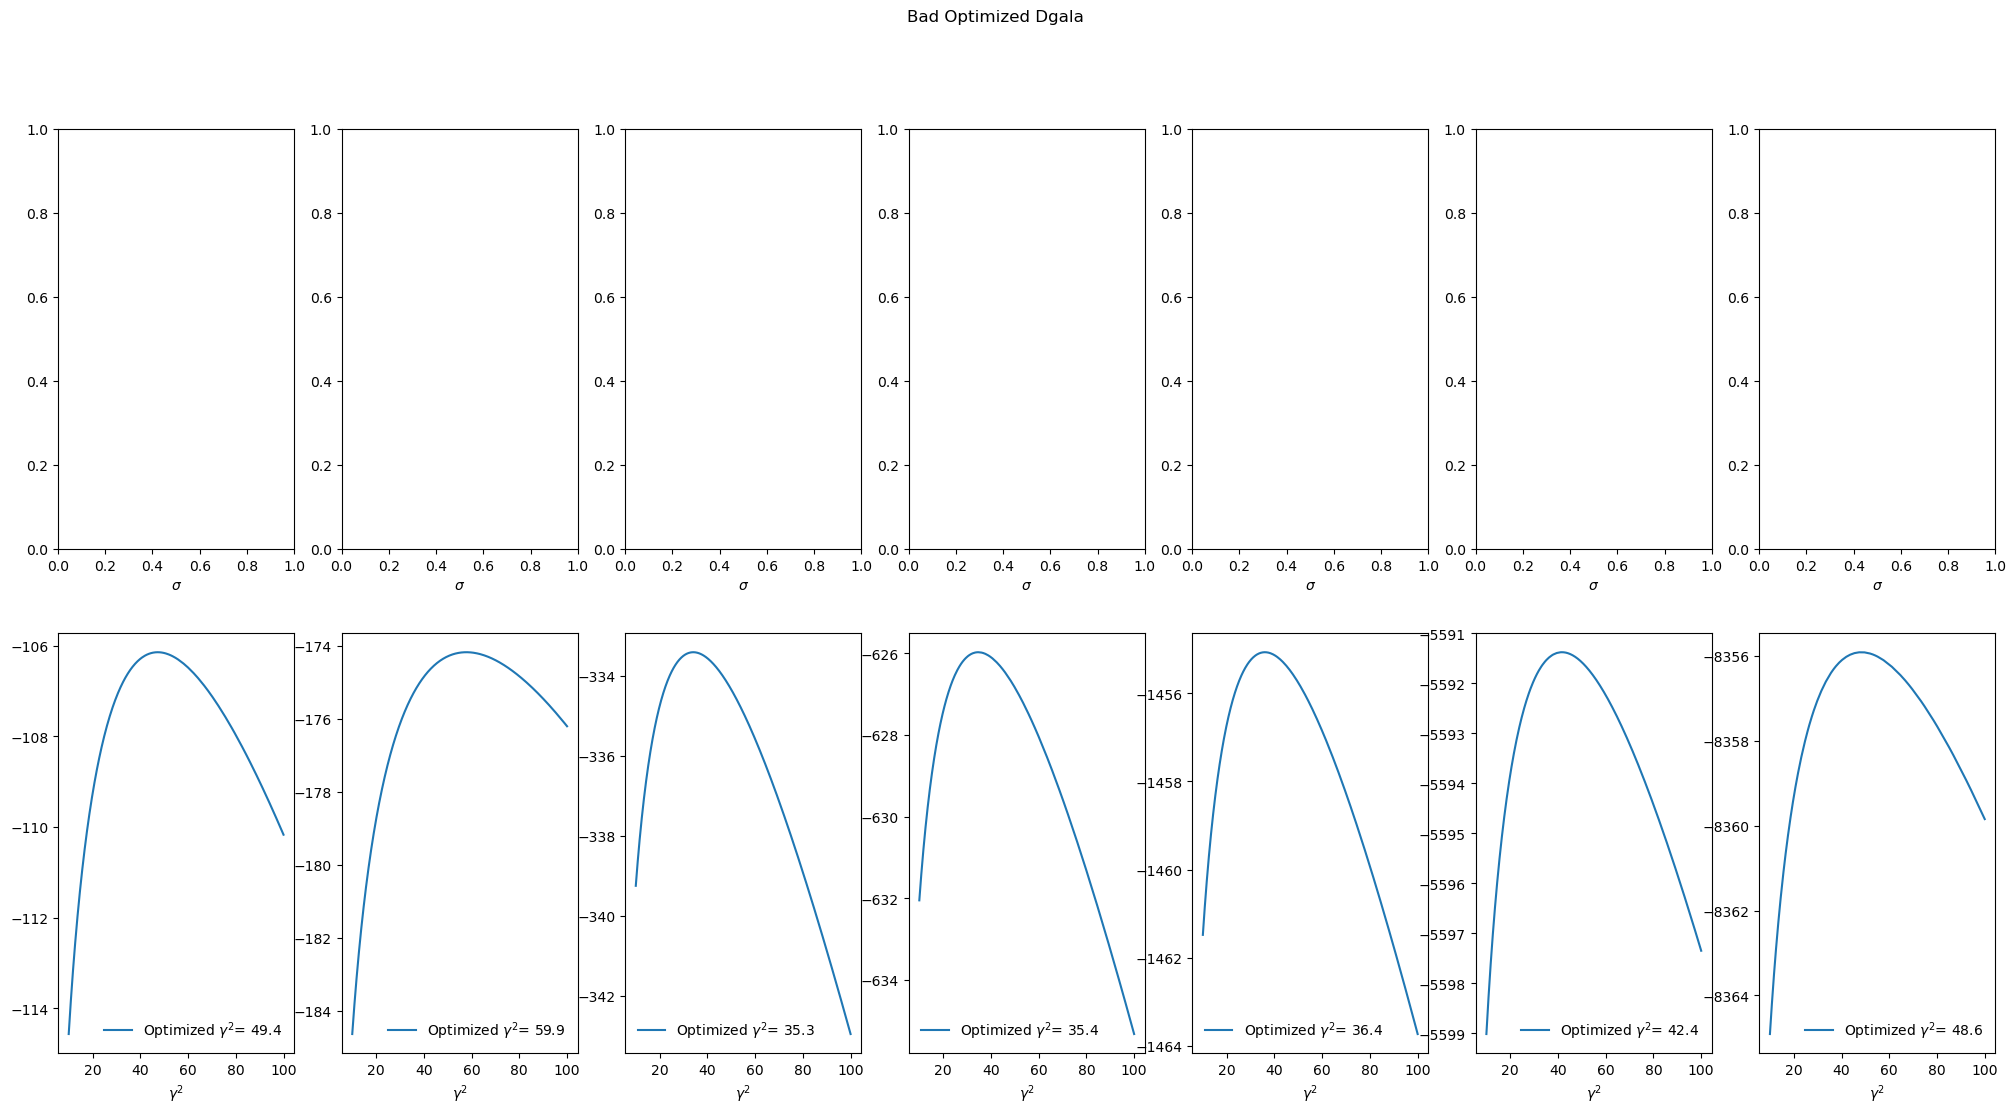

In [100]:
N = [30,50,100,200,500,2000,3000]
batches = [10,10,100,100,100,100,100]

npoints = 1000
results = torch.zeros((npoints, 2, len(N)))

for i, (n, bc) in enumerate(zip(N, batches)):
    llp = torch.load(f"./models/dgala_marginal_hl2_hd20_s{n}_b{bc}_kl2.pth")
    llp.model.set_last_layer("output_layer")  # Re-register hooks

    # # Sigma noise scan
    # llp.prior_precision = [1.]
    # sn = torch.linspace(0.0000001, 0.2, npoints)
    # log_marg_lh = []
    # for sn_val in sn:
    #     llp.sigma_noise = sn_val
    #     log_marg_lh.append(llp.log_marginal_likelihood())

    # Prior precision scan
    llp.sigma_noise = 1.
    priorpre = torch.linspace(10, 100, npoints)
    log_marg_pp = []
    for pp in priorpre:
        llp.prior_precision = [pp]
        log_marg_pp.append(llp.log_marginal_likelihood())

    #results[:,0,i] = torch.tensor(log_marg_lh)
    results[:,1,i] = torch.tensor(log_marg_pp)
    
fig, axs = plt.subplots(2,len(N), figsize=(25, 12))
fig.suptitle(f"Bad Optimized Dgala")
plt.rcParams.update({'font.size': 10})

for i,(nobs,batch) in  enumerate(zip(N,batches)):
    llp = torch.load(f"./models/dgala_marginal_hl2_hd20_s{nobs}_b{batch}_kl2.pth")
    llp.model.set_last_layer("output_layer")  # Re-register hooks

    print(llp.mean.shape[0] / (torch.linalg.norm(llp.mean,ord=2)**2 + torch.trace(llp.posterior_covariance)))
    print("sigma")
    print(llp.sigma_noise)
    loss = 0
    for key, loss_value in llp.loss.items():
        n_data_key = llp.n_data[key]
        weight = llp.dgala.lambdas[key]

        loss += n_data_key*loss_value*weight

    print(torch.sqrt((loss + .5*torch.trace(llp.posterior_covariance@llp.H))/nobs))


    log_marg_lh = results[:,0,i] 
    log_marg_pp = results[:,1,i] 

    #axs[0,i].plot(sn,np.log(log_marg_lh),label = f"Optimized $\sigma$= {llp.sigma_noise:0.3}")
    axs[0,i].set_xlabel("$\sigma$")

    axs[1,i].plot(priorpre,log_marg_pp,label = f"Optimized $\gamma^{2}$= {llp.prior_precision[0]:0.3}")
    axs[1,i].set_xlabel("$\gamma^{2}$")

    axs[0,i].legend(frameon =False)
    axs[1,i].legend(frameon =False)

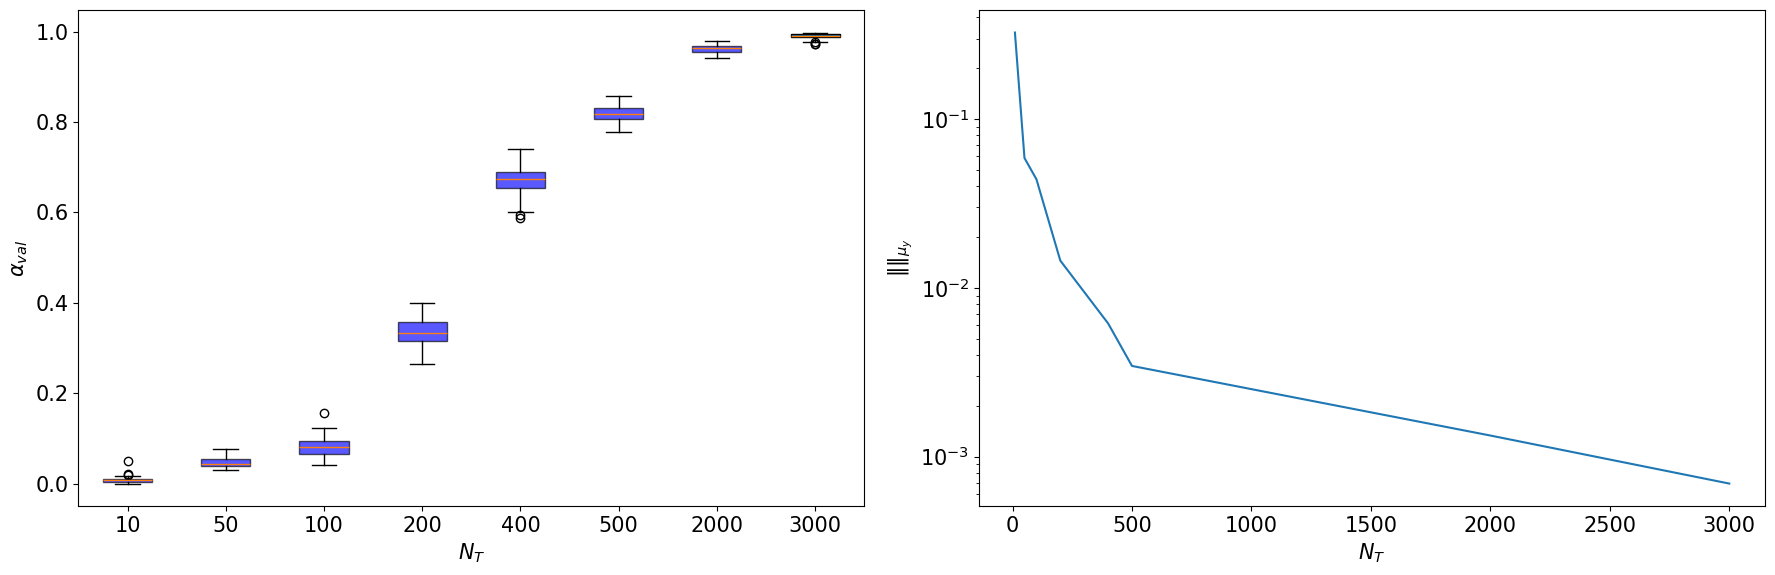

In [109]:
N = [ 10,50,100,200,400,500,2000,3000]
batches = [10,10,100,100,100,100,100,100,100,100]
hd = [20,20,20,20,20,20,20,20,20,20]
KLs = [2,2,2,2,2,2,2,2,2,2]

results_experiment_mean,results_experiment_std = final_results(model_type="dgala",KLs=KLs,Nts=N,batch_size=batches,hidden_dim=hd,marginal_approximation=True)
    

acceptance_mean_list = np.array([stat_ar(np.load(f"./results/dgala_da_mcmc_mean_hl2_hd20_s{n}_b{bth}_kl{kl}_0.npy"),every=500)[-1] for n,bth in zip(N,batches)])
cl = ["red", "blue", "green", "orange", "black","orange","tomato"]

fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharex="col")
plt.rcParams.update({'font.size': 15})

bplot = axs[0].boxplot(acceptance_mean_list.T,patch_artist=True, tick_labels=[str(n) for n in N])  # Transpose to plot along axis 1
#plt.suptitle(f"Acceptance Rate for different NN",color = "blue")
# fill with colors
for patch, color in zip(bplot['boxes'], cl):
    patch.set_facecolor("blue")
    patch.set_alpha(0.65)
    patch.set_linewidth(1)

# Customize the plot
axs[0].set_xlabel("$N_{{T}}$")
axs[0].set_ylabel("$\\alpha_{val}$")

axs[1].semilogy(N, results_experiment_mean["error"][str(kl)], label=f"KL={k}")
axs[1].set_xlabel("$N_{{T}}$")
axs[1].set_ylabel("$\\| \\|_{\\mu_{{y}}}$")

# Save the plotx
plt.savefig(f"./results/images/elliptic_da_ar_kl{kl}_{vr}.pdf")
plt.tight_layout()
plt.show()

n


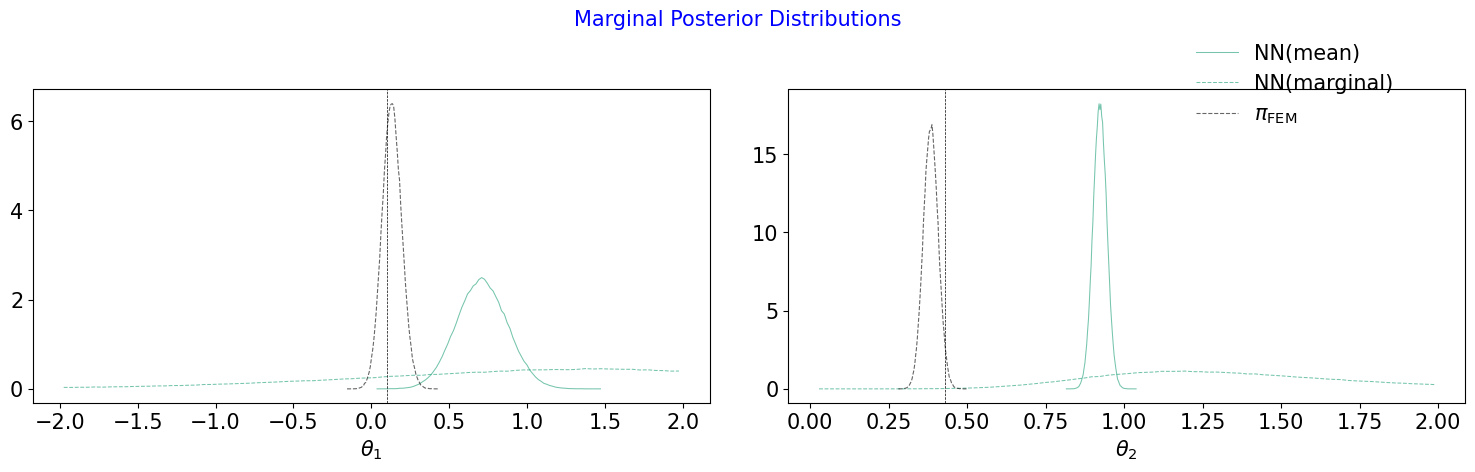

In [39]:
theta_th = theta_thruth = np.array([0.098, 0.430, 0.206, 0.090, -0.153,
                              0.292, -0.125, 0.784, 0.927, -0.233,
                              0.762,-0.084, -0.492,0.328,0.521,
                              0.005,-0.482,0.123,-0.765,0.981])


N2 = [ 10,30,100,200,400,500,2000,3000]
batches2 = [10,10,100,100,100,100,100,100,100,100]
hd2 = [20]*len(N2)

N3 = [10,100,500,700,1000,5000]
batches3 = [5,50,50,50,500,500]
hd3 = [100]*len(N3)

N4 = [100,500,700,1000,5000]
batches4 = [70,70,100,700,700]
hd4 = [100]*len(N4)

N5 = [500,1000,2000,5000,7000]
batches5 = [50,500,500,500,600]
hd5 = [100]*len(N5)

nobs = 10  # All N you want to plot
hd =90
kl = [2]
bins = 80
#100 160 200 250 400 500
batches = [10]

colors = plt.cm.Dark2(np.linspace(0, 1, len(batches)))  # Color map for different N

fig, axs = plt.subplots(len(kl), max(kl), figsize=(15, 5), sharex="col")
fig.suptitle(f"Marginal Posterior Distributions", color="blue", fontsize =15)
plt.rcParams.update({'font.size': 15})

# Ensure axs is always 2D
if len(kl) == 1:
    axs = axs[np.newaxis, :]

for i, k in enumerate(kl):  # loop over kl rows
    for z,batch in enumerate(batches):
        try:
            print("n")
            sample_nn = np.load(f'./results/dgala_mcmc_mean_hl2_hd{hd}_s{nobs}_b{batch}_kl{k}_0.npy')
            sample_marginal = np.load(f'./results/dgala_mcmc_marginal_hl2_hd{hd}_s{nobs}_b{batch}_kl{k}_0.npy')

        except FileNotFoundError:
            print(f"Warning: file for N={nobs}, KL={k} not found.")
            continue  # skip if file is missing

        for j in range(k):  # only kl[i] subplots active
            bin_centers, counts = histogram_(sample_nn[:, j], bins=bins)
            axs[i, j].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75,
                        color=colors[z], label=f"NN(mean)" if j == 0 else None)  # Label only once per N
            
            bin_centers, counts = histogram_(sample_marginal[:, j], bins=bins)
            axs[i, j].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75,
                        color=colors[z], label=f"NN(marginal)" if j == 0 else None)  # Label only once per N
            
            axs[i, j].axvline(x=theta_th[j], color='black', linestyle="--", linewidth=0.5)

            if z == 0 :
                sample = np.load(f'./results/FEM_mcmc_kl{k}_{0}.npy')
    
                bin_centers, counts = histogram_(sample[:, j],bins=bins)
                axs[i,j].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.8, label = r"$\pi_{\text{FEM}}$",color = "black")
        
            if i == len(kl) - 1:
                axs[i, j].set_xlabel(f"$\\theta_{j+1}$")
            
            #axs[-1,j].set_xlim(-2,2)

    # Hide unused subplots in each row
    for j in range(k, max(kl)):
        axs[i, j].axis('off')


# Add legend only once (you can also do per-plot legends if you prefer)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.95),frameon = False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Text(0, 0.5, '$\\| \\|_{\\mu_{{y}}}$')

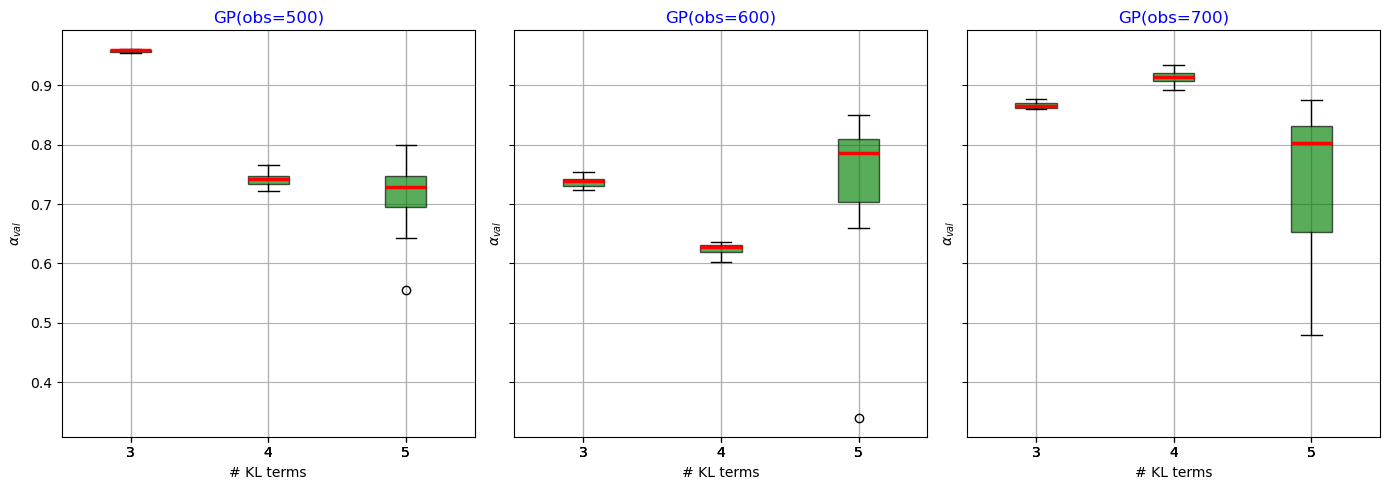

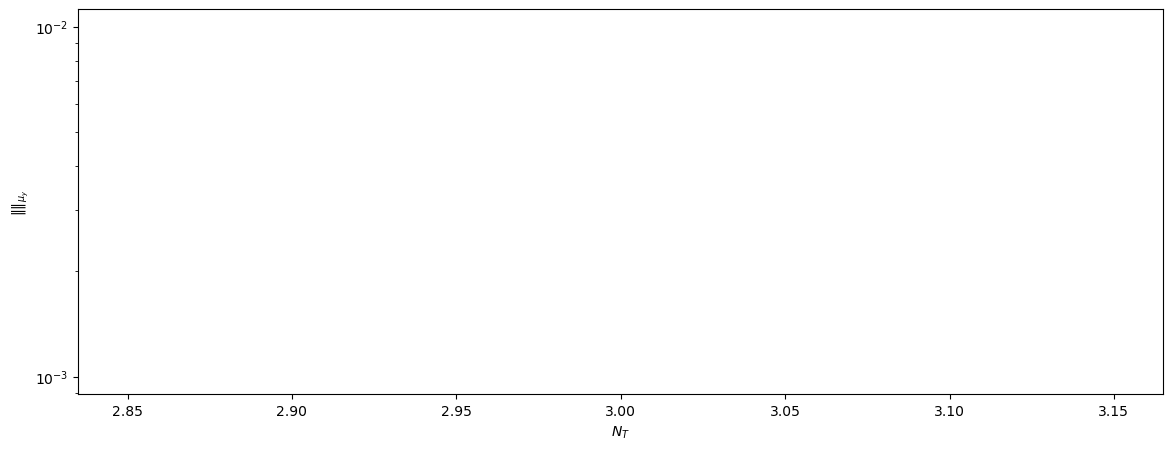

In [15]:

bins = 80
N = [1000,2000,3000,4000,5000]
batches = [500,600,700]
hd = [100]
KLs = [3,4,5]


# For each kl, collect acceptance means across N
acceptance_mean_list = []
m="mean"
for k in KLs:
    tmp = []
    for batch in batches:
        data = np.load(f"./results/dgala_da_mcmc_mean_hl2_hd{100}_s{5000}_b{batch}_kl{k}_0.npy")
        stat = stat_ar(data, every=5000)[-1]
        tmp.append(stat)
    acceptance_mean_list.append(tmp)

acceptance_mean_array = np.array(acceptance_mean_list)  # shape: (len(kl), len(N))

# Now plot
fig, ax = plt.subplots(1,len(batches),figsize=(14, 5), sharex=True, sharey=True)
plt.rcParams.update({'font.size': 10})

# Create boxplot
for i,n in enumerate(batches):
    bplot = ax[i].boxplot(acceptance_mean_array[:,i].T, patch_artist=True, tick_labels=[str(k) for k in KLs])

    # Fill each box with color (one color per kl)
    for patch in bplot['boxes']:
        patch.set_facecolor("green")
        patch.set_alpha(0.65)
        patch.set_linewidth(1)

    # Customize median lines
    for median in bplot['medians']:
        median.set_color('red')     # Black medians
        median.set_linewidth(2.5)      # Thicker line

    # Labeling
    ax[i].set_ylabel("$\\alpha_{val}$")
    ax[i].set_title(f"GP(obs={n})", color="blue")
    ax[i].grid(True)
    ax[i].set_xlabel("# KL terms")

plt.tight_layout()
#plt.savefig(f"./results/images/elliptic_da_ar_kls_gp{nn}_{vr}.pdf", bbox_inches='tight')

N = [1000,2000,3000,4000,5000]
batches = [500]
hd = [100]*len(N)
KLs = [3]


results_experiment_mean,results_experiment_std = final_results(model_type="dgala",KLs=KLs,Nts=N,batch_size=batches,hidden_dim=hd,marginal_approximation=False)
x = list(map(int, results_experiment_mean["error"].keys()))
y = [val[0] for val in results_experiment_mean["error"].values()]

fig, ax = plt.subplots(1,figsize=(14, 5), sharex=True, sharey=True)
plt.rcParams.update({'font.size': 10})

ax.semilogy(x, y, label=f"KL={k}")
ax.set_xlabel("$N_{{T}}$")
ax.set_ylabel("$\\| \\|_{\\mu_{{y}}}$")


In [68]:
import sys
import os
import argparse
import numpy as np

# project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), "../.."))
# sys.path.append(project_root)  # This allows importing from base, Elliptic, etc.
# sys.path.append(os.path.join(project_root, "navier_stokes"))  # Explicitly add Elliptic folder

from copy import deepcopy
from math import sqrt, pi
from Base.utilities import FeatureExtractor,get_decorated_methods

from torch.nn.utils import parameters_to_vector

class dgala(torch.nn.Module):
    def __init__(self, dga, sigma_noise=1., prior_precision=1.,prior_mean=0., last_layer_name = "output_layer"):
        super(dgala, self).__init__()

        self.dgala = deepcopy(dga)
        self.model = FeatureExtractor(deepcopy(dga.model), last_layer_name = last_layer_name)
        self._device = next(dga.model.parameters()).device
        self.lossfunc = torch.nn.MSELoss(reduction ='mean')
        
        self.loss = 0
        self.temperature = 1
        self.H = None
        self.mean = None
        self.n_params = None
        self.n_data = {key: None for key in self.dgala.lambdas.keys()}

        self._prior_precision = torch.tensor([prior_precision], device=self._device)
        self._prior_mean = torch.tensor([prior_mean], device=self._device)
        self._sigma_noise = torch.tensor(sigma_noise,device=self._device).float()

        if hasattr(self.dgala, "chunks"):
            self.chunks = self.dgala.chunks
            self.gamma = self.dgala.gamma.clone()
        else:
            self.chunks = None

    @property
    def prior_precision(self):
        return self._prior_precision
    
    @prior_precision.setter
    def prior_precision(self, new_prior_precision):
        if isinstance(new_prior_precision, torch.Tensor):
            self._prior_precision = new_prior_precision.to(self._device)
        else:
            self._prior_precision = torch.tensor([new_prior_precision], device=self._device).float()

    @property
    def sigma_noise(self):
        return self._sigma_noise

    @sigma_noise.setter
    def sigma_noise(self, new_sigma_noise):
        if isinstance(new_sigma_noise, torch.Tensor):
            self._sigma_noise = new_sigma_noise.to(self._device)
        else:
            self._sigma_noise = torch.tensor(new_sigma_noise, device=self._device,requires_grad=True).float()

    @property
    def posterior_precision(self):
        """Diagonal posterior precision \\(p\\)."""
        return self._H_factor * self.H + torch.diag(self.prior_precision_diag)

    @property
    def posterior_covariance(self):
        """Diagonal posterior variance \\(p^{-1}\\).""" 
        post_scale = _precision_to_scale_tril(self.posterior_precision)
        return post_scale @ post_scale.T

    @property
    def _H_factor(self):
        sigma2 = self.sigma_noise.square()
        return 1 / (2*sigma2) / self.temperature
    
    @property
    def prior_precision_diag(self):
        """Obtain the diagonal prior precision \\(p_0\\) constructed from either
        a scalar, layer-wise, or diagonal prior precision."""

        if len(self.prior_precision) == 1:  # scalar
            return self.prior_precision * torch.ones(self.n_params, device=self._device)

        elif len(self.prior_precision) == self.n_params:  # diagonal
            return self.prior_precision
        
    @property
    def scatter(self):
        """Computes the _scatter_, a term of the log marginal likelihood that
        corresponds to L-2 regularization:
        `scatter` = \\((\\theta_{MAP} - \\mu_0)^{T} P_0 (\\theta_{MAP} - \\mu_0) \\)."""

        delta = (self.mean - self.prior_mean)
        return (delta * self.prior_precision_diag) @ delta

    @property
    def log_det_prior_precision(self):
        """Compute log determinant of the prior precision
        \\(\\log \\det P_0\\)"""

        return self.prior_precision_diag.log().sum()

    @property
    def log_det_posterior_precision(self):
        """Compute log determinant of the posterior precision
        \\(\\log \\det P\\) which depends on the subclasses structure
        used for the Hessian approximation."""
        return self.posterior_precision.logdet()

    @property
    def log_det_ratio(self):
        """Compute the log determinant ratio, a part of the log marginal likelihood.
        \\[
            \\log \\frac{\\det P}{\\det P_0} = \\log \\det P - \\log \\det P_0
        \\]log"""
        return self.log_det_posterior_precision - self.log_det_prior_precision
    
    @property
    def log_likelihood(self):
        """Compute log likelihood on the training data after `.fit()` has been called.
        The log likelihood is computed on-demand based on the loss and, for example,
        the observation noise, which makes it differentiable in the latter for
        iterative updates."""

        factor = -self._H_factor
        total_log_likelihood = 0.0

        for key, loss_value in self.loss.items():
            # Compute the normalizer term for Gaussian likelihood
            n_data_key = self.n_data[key]  # Number of data points for this key
            normalizer = n_data_key * torch.log(self.sigma_noise*sqrt(2*pi))
            weight = self.dgala.lambdas[key]

            # Compute log likelihood contribution for this key
            log_likelihood_key = factor *n_data_key* loss_value*weight - normalizer

            # Accumulate total log likelihood
            total_log_likelihood += log_likelihood_key

        return total_log_likelihood
    

    def fit(self,fit_data):
        """Fit the local Laplace approximation at the parameters of the model."""
        
        self.class_methods = get_decorated_methods(self.dgala, decorator = "use_laplace")

       # assert set(self.class_methods) == set([element for sublist in fit_data["class_method"].values() for element in sublist])

        self.dgala.model.eval()
        #self.mean = parameters_to_vector(self.dgala.model.output_layer.parameters()).detach()
        self.mean = parameters_to_vector(self.model.last_layer.parameters()).detach()
        self.n_params = len(self.mean)
        self.prior_mean = self._prior_mean
        self._init_H()

        # Dynamically pass the `data_fit` contents as *args
        data_fit_args = fit_data.get("data_fit", {})
        unpacked_args = []
        for key, value in data_fit_args.items():
            if isinstance(value, tuple):
                # Unpack the tuple and add its elements individually
                unpacked_args.extend(value)
            else:
                # Add non-tuple values directly
                unpacked_args.append(value)

        loss = self.dgala.losses(*unpacked_args,loss_fn = self.lossfunc)

        self.loss = {key:loss.item() for key,loss in loss.items()}

        self.full_Hessian(fit_data)
        
    def _init_H(self):
        self.H = torch.zeros(self.n_params,self.n_params,device=self._device)

    def gradient_outograd(self, y, x):
        grad_p = torch.autograd.grad(outputs=y, 
                                 inputs=x, create_graph=True, allow_unused=True, materialize_grads=True)
        return [grp.detach() for grp in grad_p]
    
    def full_Hessian(self,fit_data):
        parameters_ = list(self.dgala.model.output_layer.parameters())
        h = torch.zeros(self.n_params,self.n_params,device = self._device)
        damping = torch.eye(self.n_params,device=self._device)

        for key,dt_fit in fit_data["data_fit"].items():
            dt_fit = dt_fit[1] if isinstance(dt_fit, tuple) else dt_fit

            for z,clm in enumerate(fit_data["class_method"][key]):
                self.dgala.model.zero_grad()
                fout = getattr(self.dgala, clm)(dt_fit)
                #damping_factor = 1e-5 if key =="pde" else 1

                if isinstance(fout, tuple):  # Check if fout is a tuple
                    for i, f_out_indv in enumerate(fout):  # Iterate over fout if it's a tuple
                        indv_h = self.compute_hessian(f_out_indv,parameters_,key)
                        h+= indv_h*self.dgala.lambdas[fit_data["outputs"][key][i]]
                        self.n_data[fit_data["outputs"][key][i]] = f_out_indv.shape[0]
                else:
                    indv_h = self.compute_hessian(fout,parameters_,key)
                    #print(indv_h)
                    h += indv_h*self.dgala.lambdas[fit_data["outputs"][key][z]]
                    self.n_data[fit_data["outputs"][key][z]] = fout.shape[0]
                
        # eigvals, eigvecs = torch.linalg.eigh(h)
        # #eigvals_clamped = torch.clamp(eigvals, min=0.0)
        # #hessian_psd = eigvecs @ torch.diag(eigvals_clamped) @ eigvecs.T
        # #hessian_psd = 0.5 * (hessian_psd + hessian_psd.T)

        # negative_eigvals = eigvals[eigvals < 0]

        # if len(negative_eigvals) > 0:
        #     largest_negative = -negative_eigvals.min()
        # else:
        #     largest_negative = 0  # or handle case with no negative eigenvalues

        # # hessian_loss += (largest_negative + 1e-10)*damping
        # # choose eps relative to largest eigenvalue
        # α = 1e-7  # float32
        # eps = α * eigvals.abs().max()

        # print(f"Largest negative eigenvalue {largest_negative}")
        # print((largest_negative + eps)*damping)
        self.H = h 
        #self.H = h


                
    def compute_hessian (self,output,parameters_,key):
        hessian_loss = torch.zeros(self.n_params,self.n_params,device = self._device)
        damping = torch.eye(self.n_params,device=self._device)
        neg_eigvals = []
        if self.chunks: 
            nitems_chunk = output.shape[0] // self.chunks
            chunk_counter = 0

        for i,fo in enumerate(output):
            grad_p = self.gradient_outograd(fo,parameters_)
            
            ndim = grad_p[0].shape[0]

            reshaping_grads = [g.reshape(ndim,-1) for g in grad_p]
            # Concatenate along the parameter axis
            jacobian_matrix = torch.cat(reshaping_grads, dim=1).reshape(1,-1)
            h_indv = jacobian_matrix.T @ jacobian_matrix
            hessian_loss +=  h_indv 
            if self.chunks and (i + 1) % nitems_chunk == 0 and key == "pde":

                hessian_loss *= self.gamma[chunk_counter]
                chunk_counter += 1

        # Compute eigen-decomposition
        eigvals, eigvecs = torch.linalg.eigh(hessian_loss)

        # # Clamp negative eigenvalues to zero
        eigvals_clamped = torch.clamp(eigvals, min=0.0)

        # # Reconstruct the PSD Hessian
        hessian_psd = eigvecs @ torch.diag(eigvals_clamped) @ eigvecs.T

        # # Optional: ensure symmetry (numerical stability)
        # hessian_psd = 0.5 * (hessian_psd + hessian_psd.T)

        negative_eigvals = eigvals[eigvals < 0]

        if len(negative_eigvals) > 0:
            largest_negative = -negative_eigvals.min()
        else:
            largest_negative = 0  # or handle case with no negative eigenvalues

        # # hessian_loss += (largest_negative + 1e-10)*damping

        # print(f"Largest negative eigenvalue {largest_negative}")
        return hessian_psd


In [71]:
N = 9000
data_fit = deepgala_data_fit(N,2,device)
nn = torch.load(f"./models/dgala_mean_hl2_hd60_s{N}_b{800}_kl2.pth")
llp = dgala(nn)
llp.fit(data_fit)

KeyboardInterrupt: 

In [70]:
torch.linalg.eigh(llp.H)

torch.return_types.linalg_eigh(
eigenvalues=tensor([-2.0492e-03, -1.2814e-03, -9.2167e-04, -7.8861e-04, -4.8809e-04,
        -4.5108e-04, -3.3989e-04, -2.2123e-04, -7.5254e-05, -3.8880e-06,
         4.3813e-05,  5.1586e-05,  8.6510e-05,  1.5710e-04,  2.0928e-04,
         2.2975e-04,  2.4567e-04,  3.1626e-04,  3.9802e-04,  4.0570e-04,
         5.0048e-04,  6.4786e-04,  6.6629e-04,  6.7729e-04,  1.0935e-03,
         1.1387e-03,  1.2005e-03,  1.5057e-03,  1.5540e-03,  1.7521e-03,
         1.9712e-03,  2.3238e-03,  2.3905e-03,  2.7608e-03,  3.1743e-03,
         5.1972e-03,  7.7292e-03,  1.2316e-02,  4.7411e-02,  1.0493e-01,
         2.6606e-01,  4.9477e-01,  9.7805e-01,  1.7636e+00,  2.4454e+00,
         5.0763e+00,  8.0524e+00,  1.1498e+01,  1.5520e+01,  2.5887e+01,
         6.0197e+01,  1.2479e+02,  1.6892e+02,  2.2407e+02,  3.7542e+02,
         8.0413e+02,  1.0188e+03,  1.8468e+03,  4.3767e+03,  8.1145e+03,
         2.4051e+04]),
eigenvectors=tensor([[-0.0304,  0.0000, -0.0587,  ..., -0

In [27]:
nn = torch.load(f"./models/dgala_marginal_hl2_hd60_s{10}_b{10}_kl2.pth")
nn.H

tensor([[41238.5156, 41237.8828, 41237.8828,  ..., 41237.8828, 41237.8828,
         41237.8828],
        [41237.8828, 41238.5156, 41237.8828,  ..., 41237.8828, 41237.8828,
         41237.8828],
        [41237.8828, 41237.8828, 41238.5156,  ..., 41237.8828, 41237.8828,
         41237.8828],
        ...,
        [41237.8828, 41237.8828, 41237.8828,  ..., 41238.5156, 41237.8828,
         41237.8828],
        [41237.8828, 41237.8828, 41237.8828,  ..., 41237.8828, 41238.5156,
         41237.8828],
        [41237.8828, 41237.8828, 41237.8828,  ..., 41237.8828, 41237.8828,
         41238.5156]])

In [28]:
nn = torch.load(f"./models/dgala_marginal_hl2_hd60_s{9000}_b{800}_kl2.pth")
nn.H

tensor([[27951742., 27951432., 27951432.,  ..., 27951432., 27951432.,
         27951432.],
        [27951432., 27951742., 27951432.,  ..., 27951432., 27951432.,
         27951432.],
        [27951432., 27951432., 27951742.,  ..., 27951432., 27951432.,
         27951432.],
        ...,
        [27951432., 27951432., 27951432.,  ..., 27951742., 27951432.,
         27951432.],
        [27951432., 27951432., 27951432.,  ..., 27951432., 27951742.,
         27951432.],
        [27951432., 27951432., 27951432.,  ..., 27951432., 27951432.,
         27951742.]])

# GP

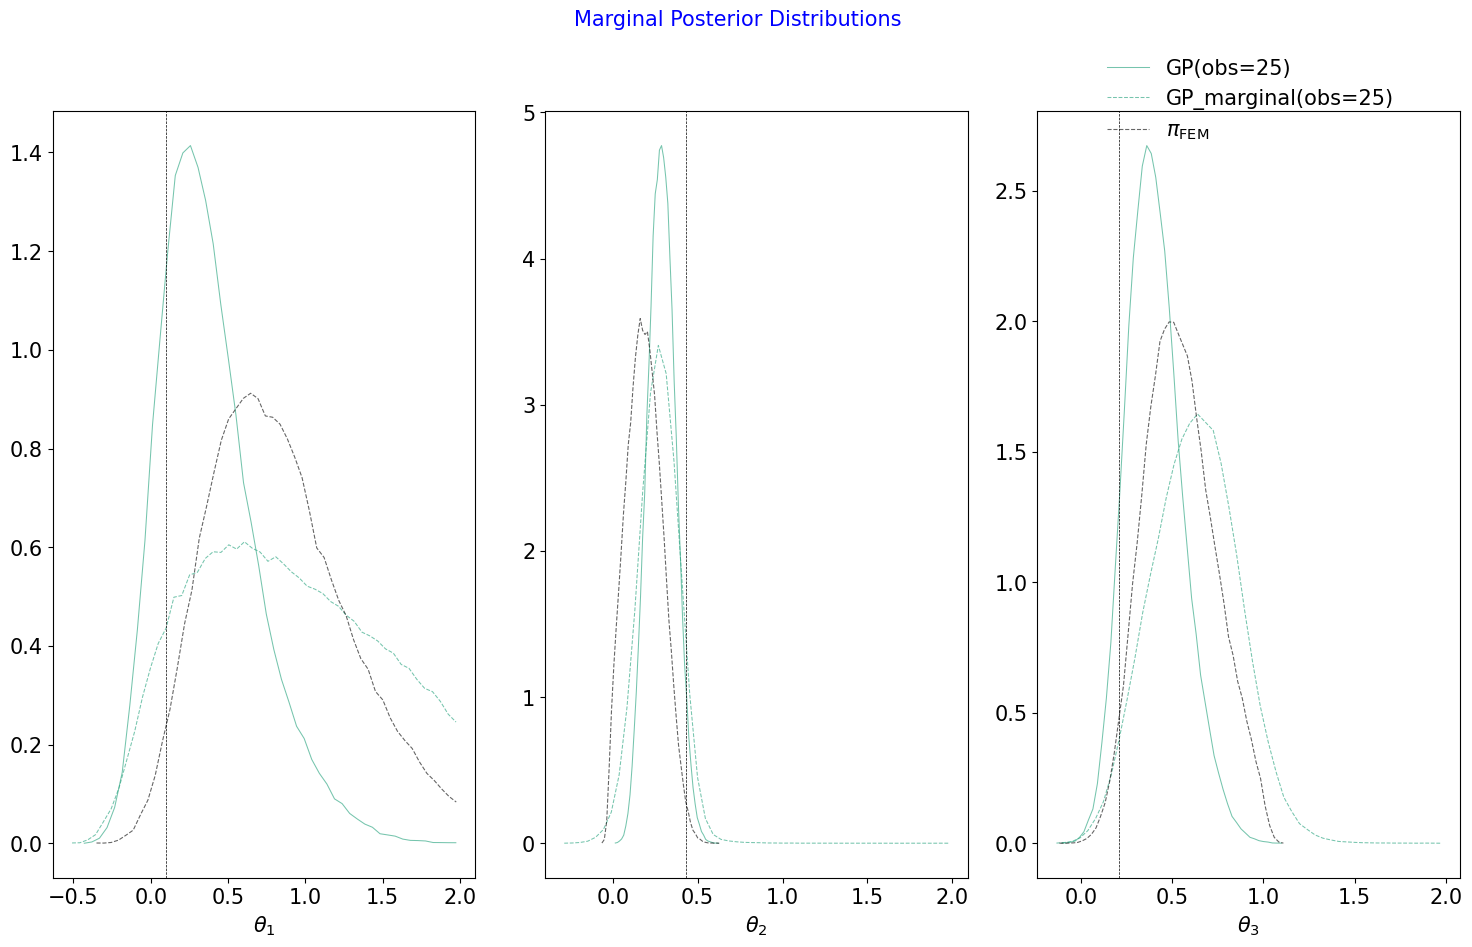

In [196]:
theta_th = np.array([0.098, 0.430, 0.206, 0.090, -0.153, 0.292])

nn = [25]
kl = [3]
m = "mean"
bins = 50
vr = 1e-4

colors = plt.cm.Dark2(np.linspace(0, 1, len(nn)))  # Color map for different N

fig, axs = plt.subplots(len(kl), max(kl), figsize=(15, 10), sharex="col")
fig.suptitle(f"Marginal Posterior Distributions", color="blue", fontsize =15)
plt.rcParams.update({'font.size': 15})

# Ensure axs is always 2D
if len(kl) == 1:
    axs = axs[np.newaxis, :]

for i, k in enumerate(kl):  # loop over kl rows
    for z,neurons in enumerate(nn):
        try:
            sample_gp = np.load(f'./results/pigp_mcmc_mean_kernel_spatialMatern52_kernel_parameterMatern52_spatial6_nsol{neurons}_kl{k}_0.npy')
            sample_gp_m = np.load(f'./results/pigp_mcmc_marginal_kernel_spatialMatern52_kernel_parameterMatern52_spatial6_nsol{neurons}_kl{k}_0.npy')

        except FileNotFoundError:
            print(f"Warning: file for N=, KL={k} not found.")
            continue  # skip if file is missing

        for j in range(k):  # only kl[i] subplots active
            bin_centers, counts = histogram_(sample_gp[:, j], bins=bins)
            axs[i, j].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75,
                        color=colors[z], label=f"GP(obs={neurons})" if j == 0 else None)  # Label only once per N
            
            bin_centers, counts = histogram_(sample_gp_m[:, j], bins=bins)
            axs[i, j].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75,
                        color=colors[z], label=f"GP_marginal(obs={neurons})" if j == 0 else None)  # Label only once per N
            
            axs[i, j].axvline(x=theta_th[j], color='black', linestyle="--", linewidth=0.5)

            if z == 0 :

                sample = np.load(f'./results/FEM_mcmc_kl{k}_{0}.npy')
    
                bin_centers, counts = histogram_(sample[:, j],bins=bins)
                axs[i,j].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.8, label = r"$\pi_{\text{FEM}}$",color = "black")
        
            if i == len(kl) - 1:
                axs[i, j].set_xlabel(f"$\\theta_{j+1}$")

    # Hide unused subplots in each row
    for j in range(k, max(kl)):
        axs[i, j].axis('off')

# Add legend only once (you can also do per-plot legends if you prefer)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.95),frameon = False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

#plt.savefig(f"./results/images/elliptic_pd_kls_gp{nn}_var{vr}.pdf")

In [41]:
kl =2

#samples = samples_param(1000, kl)
#theta = torch.tensor(samples[0,:]).reshape(1,-1)
obs_points, sol_test = generate_noisy_obs(obs=6,std=np.sqrt(1e-4),nparam=kl,vert=50)
# obs_points = torch.tensor(obs_points)
# data = torch.cat([obs_points, theta.repeat(obs_points.size(0), 1)], dim=1).float()

# nn_model = torch.load(f'./models/dgala_marginal_hl2_hd{20}_s{30}_b{10}_kl{kl}.pth')
# nn_model.model.set_last_layer("output_layer")

# nn_model = torch.load(f'./models/dgala_mean_hl2_hd{20}_s{30}_b{10}_kl{kl}.pth')

# #nn_model = nn_model.to(torch.double)  # convert *all* parameters + buffers

fem_solver = FEMSolver(np.zeros(kl), vert=50,M = kl)
model = torch.load("./models/dgala_mean_hl2_hd90_s10_b10_kl2.pth")

In [42]:
sampler = EllipticMCMCDA(model,fem_solver,obs_points, sol_test,nparameters=kl,marginal=False, 
                         observation_noise=np.sqrt(1e-4), iter_mcmc=1_500_000, iter_da = 100_000, burnin=None, 
                 proposal_type="random_walk",prior_type = "uniform",uniform_limit=2,my_reg = 1e-3, 
                 step_size=0.1,device=device)

sampler.run_chain(verbose=True)
sampler.run_da_(verbose=True)

Starting MCMC....


Running MCMC:  91%|█████████▏| 1712197/1875000 [05:56<00:33, 4803.07step/s, acceptance_rate=0.2184, proposal_variance=0.0926]


KeyboardInterrupt: 

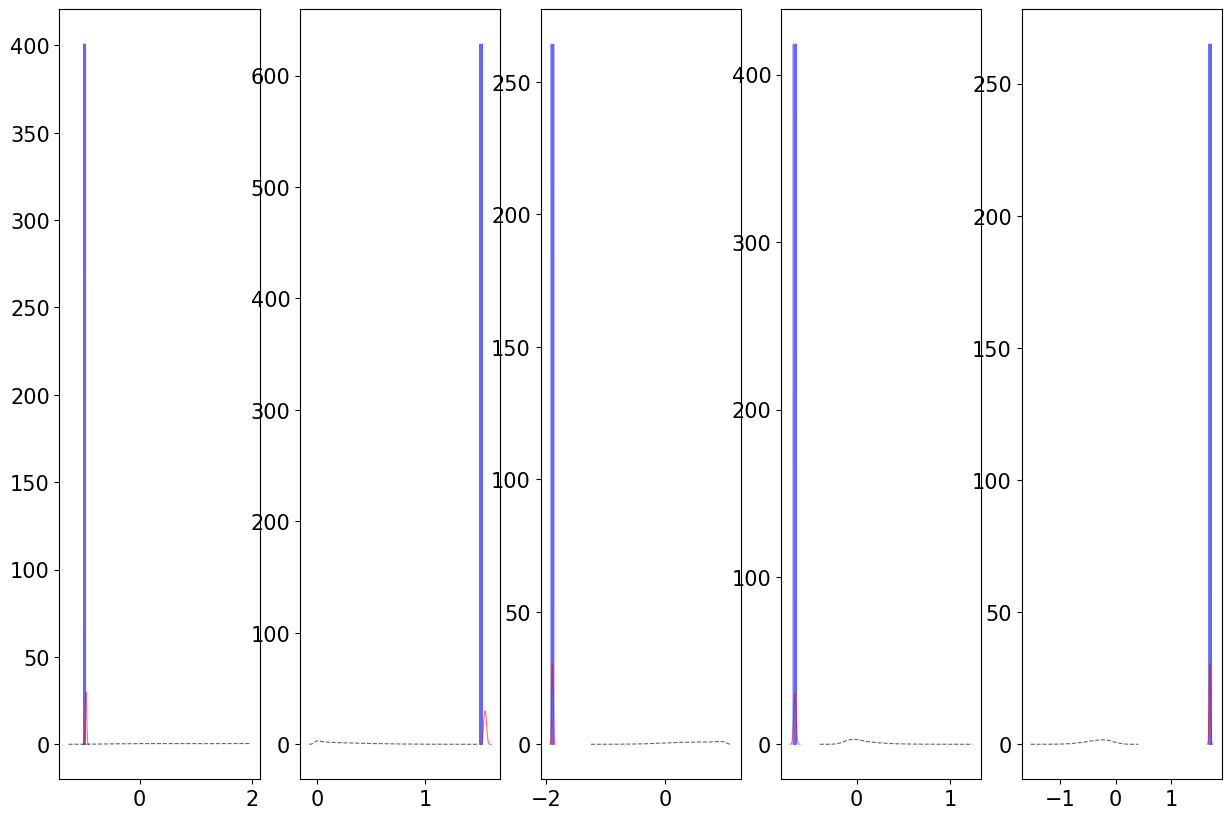

In [165]:
fig, axs = plt.subplots(1, 5, figsize=(15, 10), sharex="col")

sample = np.load(f'./results/FEM_mcmc_kl{5}_{0}.npy')

accepted_thetas = sampler.da_samples[sampler.da_acc_rej == 1]
rejected_thetas = sampler.da_samples[sampler.da_acc_rej == 0]

for j in range(5):
        bin_centers, counts = histogram_(accepted_thetas[:, j], bins=80)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75,
                    color="blue", label=f"GP" if j == 0 else None)  # Label only once per N
        
        bin_centers, counts = histogram_(rejected_thetas[:, j], bins=80)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75,
                    color="red", label=f"GP" if j == 0 else None)  # Label only once per N
        
        bin_centers, counts = histogram_(sample[:, j],bins=80)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.8, label = r"$\pi_{\text{FEM}}$",color = "black")


In [166]:
sampler = EllipticMCMCDA(model,fem_solver,obs_points, sol_test,nparameters=kl,marginal=True, 
                         observation_noise=np.sqrt(1e-4), iter_mcmc=1_500_000, iter_da = 100_000, burnin=None, 
                 proposal_type="random_walk",prior_type = "uniform",uniform_limit=2,my_reg = 1e-3, 
                 step_size=0.1,device=device)

sampler.run_chain(verbose=True)
sampler.run_da_(verbose=True)

Starting MCMC....


Running MCMC: 100%|██████████| 1875000/1875000 [11:41<00:00, 2671.11step/s, acceptance_rate=0.2383, proposal_variance=1.2326]


Starting DA Montecarlo....


Running Delayed Acceptance: 100%|██████████| 100000/100000 [23:15<00:00, 71.65step/s, acceptance_rate=0.0001]

Times inner step 100000.0000, Acceptance Rate: 0.0001


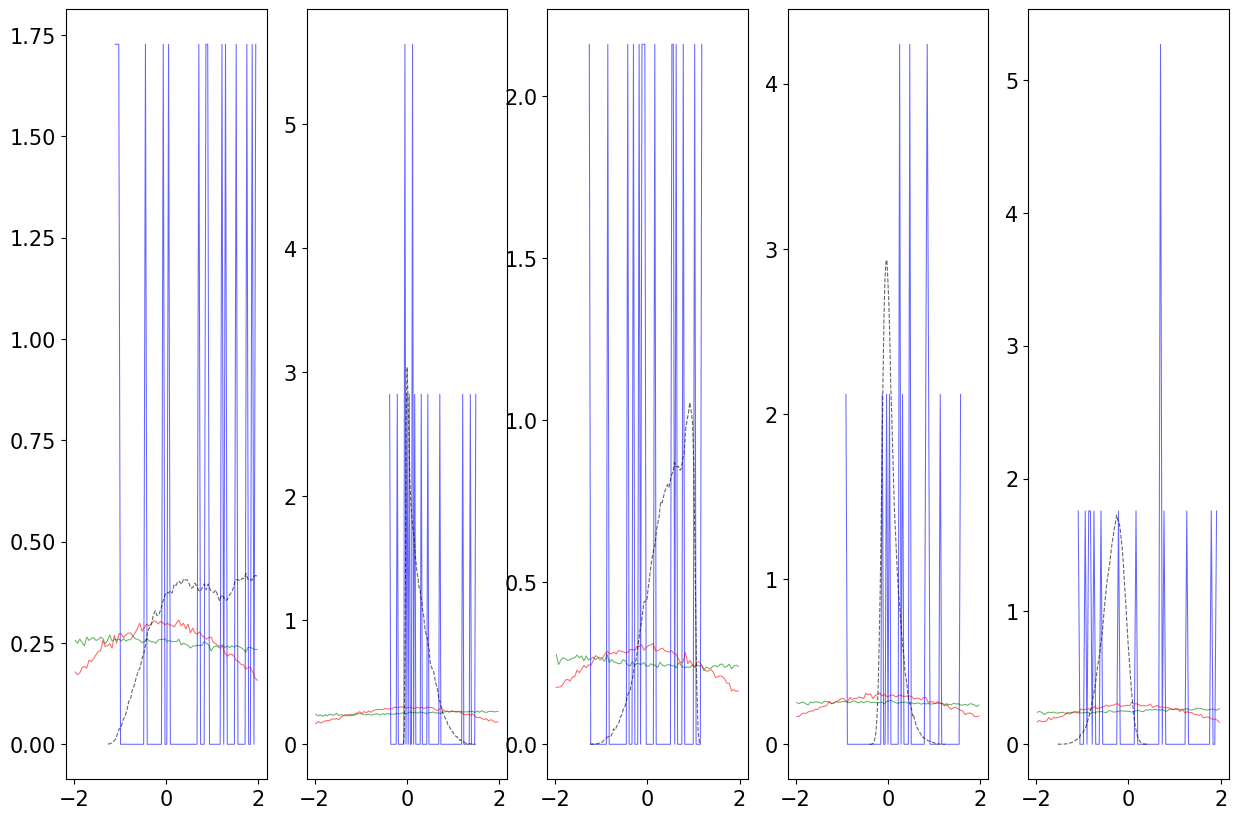

In [167]:
fig, axs = plt.subplots(1, 5, figsize=(15, 10), sharex="col")

sample = np.load(f'./results/FEM_mcmc_kl{5}_{0}.npy')

accepted_thetas = sampler.da_samples[sampler.da_acc_rej == 1]
rejected_thetas = sampler.da_samples[sampler.da_acc_rej == 0]

for j in range(5):
        bin_centers, counts = histogram_(sampler.mcmc_samples[:, j], bins=80)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75,
                    color="green", label=f"GP" if j == 0 else None)  # Label only once per N
        
        bin_centers, counts = histogram_(accepted_thetas[:, j], bins=80)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75,
                    color="blue", label=f"GP" if j == 0 else None)  # Label only once per N
        
        bin_centers, counts = histogram_(rejected_thetas[:, j], bins=80)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75,
                    color="red", label=f"GP" if j == 0 else None)  # Label only once per N
        
        bin_centers, counts = histogram_(sample[:, j],bins=80)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.8, label = r"$\pi_{\text{FEM}}$",color = "black")


In [168]:
torch.sum(sampler.da_acc_rej)

tensor(15.)

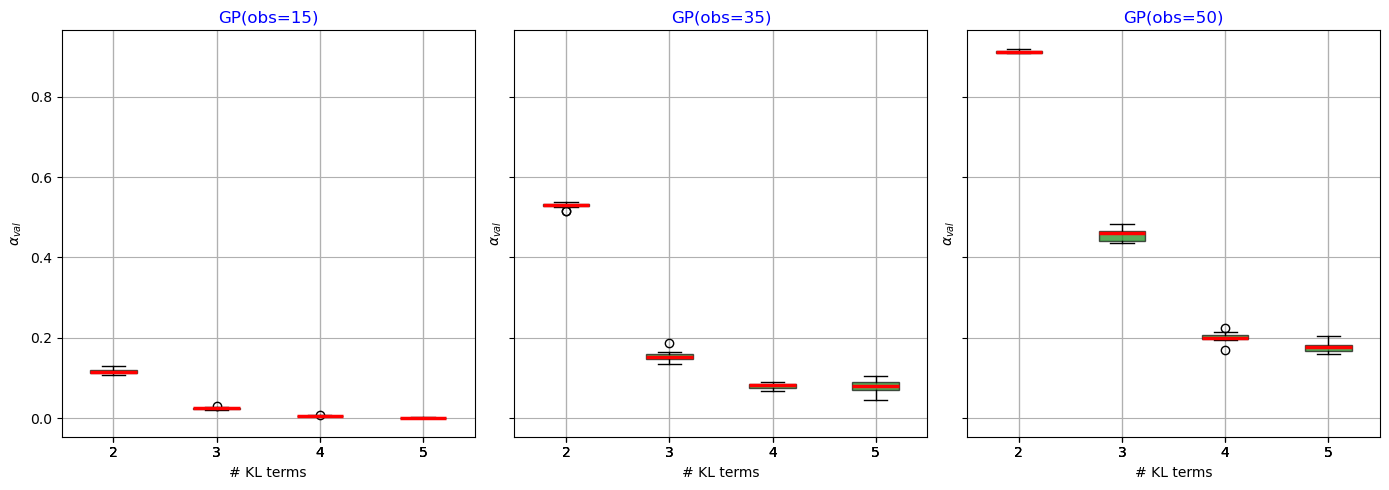

In [107]:
#nn = [10, 25,50,75,100]
nn = [15,35,50]
kl = [2,3,4,5]
# For each kl, collect acceptance means across N
acceptance_mean_list = []
m="mean"
for kls in kl:
    tmp = []
    for n in nn:
        data = np.load(f"./results/pigp_da_mcmc_marginal_kernel_spatialMatern52_kernel_parameterMatern52_spatial6_nsol{n}_kl{kls}_0.npy")
        #data = np.load(f"./results/mcmc_da_pigp_{m}_spatial6_nsol{n}_kl{kls}_0.0001_0.npy")
        stat = stat_ar(data, every=5000)[-1]
        tmp.append(stat)
    acceptance_mean_list.append(tmp)

acceptance_mean_array = np.array(acceptance_mean_list)  # shape: (len(kl), len(N))

# Now plot
fig, ax = plt.subplots(1,len(nn),figsize=(14, 5), sharex=True, sharey=True)
plt.rcParams.update({'font.size': 10})

# Create boxplot
for i,n in enumerate(nn):
    bplot = ax[i].boxplot(acceptance_mean_array[:,i].T, patch_artist=True, labels=[str(k) for k in kl])

    # Fill each box with color (one color per kl)
    for patch in bplot['boxes']:
        patch.set_facecolor("green")
        patch.set_alpha(0.65)
        patch.set_linewidth(1)

    # Customize median lines
    for median in bplot['medians']:
        median.set_color('red')     # Black medians
        median.set_linewidth(2.5)      # Thicker line

    # Labeling
    ax[i].set_ylabel("$\\alpha_{val}$")
    ax[i].set_title(f"GP(obs={n})", color="blue")
    ax[i].grid(True)
    ax[i].set_xlabel("# KL terms")

plt.tight_layout()
#plt.savefig(f"./results/images/elliptic_da_ar_kls_gp{nn}_{vr}.pdf", bbox_inches='tight')